# BL 1-5: SAXS data correction and reduction



#!/usr/bin/env python3

"""
Created on Fri Apr 21 23:41:02 2023

@author: akmaurya
"""

Global stuff

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
#from axis_plot_prop import axis_plot_prop 
import pyFAI
import shutil
import fabio
from pyFAI.gui.jupyter.calib import Calibration
from typing import List, Dict, Tuple, Optional, Union, Any
import pandas as pd

import os
import fnmatch


import warnings
warnings.filterwarnings('ignore')

# Common functions for the project

In [ ]:
# plot setting fucntion

def axis_plot_prop(ax: plt.Axes) -> None:
    """
    Set axis properties for plotting.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object to set properties for.
    """

    co = [
        [0, 0, 0],
        [1, 0, 0],
        [0.44, 0.00, 0.99],
        [1.00, 0.50, 0.10],
        [0.75, 0.00, 0.75],
        [0.50, 0.50, 0.50],
        [0.50, 0.57, 0.00],
        [0.64, 0.08, 0.18],
        [0.93, 0.00, 0.00]
    ]

    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=co)

    ax.set_facecolor('white')
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.tick_params(axis='both', which='both', direction='in', length=4, width=1)
    ax.minorticks_on()
    ax.set_xlabel('X Label', fontsize=20, fontname='Arial')
    ax.set_ylabel('Y Label', fontsize=20, fontname='Arial')
    ax.tick_params(axis='both', labelsize=20)
    ax.legend(frameon=False)
    #ax.set_box_aspect(1)
    plt.tight_layout()
#2D plot settings function
# import matplotlib.pyplot as plt

def set_pcolor_properties() -> None:
    """
    Sets the best figure properties for pcolormap plot
    """
    plt.rcParams["figure.figsize"] = (6, 6)  # Set the figure size to 8 inches by 6 inches
    plt.rcParams["font.size"] = 20  # Set the font size to 12 points
    plt.rcParams["axes.linewidth"] = 1.5  # Set the linewidth of the axes to 1.5
    #plt.rcParams["axes.grid"] = True  # Show the grid
    #plt.rcParams["grid.alpha"] = 0.5  # Set the transparency of the grid to 0.5
    #plt.rcParams["grid.linewidth"] = 0.5  # Set the linewidth of the grid to 0.5
    plt.rcParams["image.cmap"] = "viridis"  # Set the colormap to viridis
    plt.rcParams["image.interpolation"] = "nearest"  # Set the interpolation to nearest

# create and update folder to save data
def create_update_subfolder(base_folder: str, common_keyword: str) -> str:
    """
    Create or update a subfolder within a base folder.
    
    Parameters
    ----------
    base_folder : str
        Path to the base folder
    common_keyword : str
        Name of the subfolder to create
        
    Returns
    -------
    str
        Path to the created/existing subfolder
    """
    common_folder_path = os.path.join(base_folder, common_keyword)
    
    if os.path.exists(base_folder) and os.path.isdir(common_folder_path):
        print(f"Subfolder '{common_keyword}' already exists within the base folder.")
    else:
        os.makedirs(common_folder_path)
        print(f"Subfolder '{common_keyword}' created within the base folder.")

    return common_folder_path

# Convert pixel by pixel to qx by qy 2D SAXS plot

def convert_saxs_to_q(data: np.ndarray, pixel_size: float, wavelength: float, 
                     detector_distance: float, beam_x: float, beam_y: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert SAXS detector pixel coordinates to q-space coordinates.
    
    Parameters
    ----------
    data : np.ndarray
        2D detector data array
    pixel_size : float
        Size of detector pixels in meters
    wavelength : float
        X-ray wavelength in meters
    detector_distance : float
        Sample-to-detector distance in meters
    beam_x : float
        Beam center x-coordinate in pixels
    beam_y : float
        Beam center y-coordinate in pixels
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        qx and qy arrays in nm^-1
    """
    # Define grid of pixel coordinates (assumes data is square)
    #x_pixels,y_pixels = data.shape
    x_pixels = 981
    y_pixels = 1043
    x_coords = np.arange(x_pixels) - beam_x
    y_coords = np.arange(y_pixels) - beam_y
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Convert to q-space coordinates
    qx = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * xx / detector_distance)
    qy = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * yy / detector_distance)

    #print (len(xx))
    
    return qx, qy


    #print (qx)
    
def convert_waxs_to_q(data: np.ndarray, pixel_size: float, wavelength: float, 
                     detector_distance: float, beam_x: float, beam_y: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert WAXS detector pixel coordinates to q-space coordinates.
    
    Parameters
    ----------
    data : np.ndarray
        2D detector data array
    pixel_size : float
        Size of detector pixels in meters
    wavelength : float
        X-ray wavelength in meters
    detector_distance : float
        Sample-to-detector distance in meters
    beam_x : float
        Beam center x-coordinate in pixels
    beam_y : float
        Beam center y-coordinate in pixels
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        qx and qy arrays in nm^-1
    """
    # Define grid of pixel coordinates (assumes data is square)
    #x_pixels,y_pixels = data.shape
    x_pixels = 487
    y_pixels = 195
    x_coords = np.arange(x_pixels) - beam_x
    y_coords = np.arange(y_pixels) - beam_y
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Convert to q-space coordinates
    qx = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * xx / detector_distance)
    qy = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * yy / detector_distance)

    print (len(xx))
    
    return qx, qy


def set_plot_style(axs: plt.Axes, fonts: int, xlabel: str, ylabel: str) -> plt.Axes:
    """
    Set standardized plot style properties.
    
    Parameters
    ----------
    axs : plt.Axes
        Matplotlib axes object
    fonts : int
        Font size for labels and ticks
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
        
    Returns
    -------
    plt.Axes
        Modified axes object
    """
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(which='minor', width=1, size=2)  # Adjust size as needed
    #axs.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    axs.set_facecolor('white')
    axs.spines['top'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['left'].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)

    return axs    #print (qx) 
 


def darken_colors(num_colors: int, darker_factor: float = 0.7) -> np.ndarray:
    """
    Darken a set of colors by reducing the value component in the HSV color space.

    Parameters
    ----------
    num_colors : int
        Number of colors to generate.
    darker_factor : float, default 0.7
        Factor to control the darkness of the colors.

    Returns
    -------
    np.ndarray
        Darkened colors in RGB format.
    """
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))

    # Make the colors darker by reducing the value component
    darker_colors = colors.copy()

    for i in range(num_colors):
        rgb = darker_colors[i, :3]  # Extract the RGB values
        hsv = plt.cm.colors.rgb_to_hsv(rgb)  # Convert RGB to HSV
        hsv[2] *= darker_factor  # Reduce the value component
        darker_colors[i, :3] = plt.cm.colors.hsv_to_rgb(hsv)  # Convert back to RGB

    return darker_colors

# Inputs

# Poni

Vivek: What about making the naming scheme of the PONI files consistent. Have a base_dir that is modifiable and then store both poni files in a poni subdirectory with a predetermined naming scheme. That way we only need to specify the base_dir in the metadata file.

In [ ]:
#folder_path_poni_mask = '/Users/akmaurya/Library/CloudStorage/OneDrive-SLACNationalAcceleratorLaboratory/My Onedrive/Data_01/Methanolysis/Python/Data_Reduction/Convert_and_calibrate'
#folder_path_poni_mask = r'C:\Users\b_tassone\Desktop\Anjani\Python\Convert_and_calibrate'
#folder_path_poni_mask = '/Users/akmaurya/OneDrive - Stanford/Python_library/Acetolysis/May2024/Python/Convert_and_calibrate/Convert_and_calibrate'
base_dir = r'/Users/akmaurya/OneDrive - Stanford/Data_01/Autoxidation/Autoxidation/Jan2025/atT'
folder_path_poni_mask = os.path.join(base_dir, 'poni')


SAXS_poni_file = "atT_SAXS.poni"
WAXS_poni_file = "atT_WAXS.poni"

# SAXS

In [29]:
poni_file_path = os.path.join(folder_path_poni_mask,SAXS_poni_file)
print(poni_file_path)
ai = pyFAI.load(poni_file_path)

print(ai)

#Define detector parameters for 2D q conversion
pixel_size = ai.get_pixel1() # in meters 
wavelength = ai.get_wavelength() #1.54e-10  # in meters
detector_distance = ai.get_dist()  # in meters
beam_x=491.215
beam_y=626.705 # beam center x-coordinate in pixels


/Users/akmaurya/OneDrive - Stanford/Data_01/Autoxidation/Autoxidation/Jan2025/atT/poni/atT_SAXS.poni
Detector Pilatus 1M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.033202e-10 m
SampleDetDist= 2.909697e+00 m	PONI= 1.077932e-01, 8.448894e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 2909.697 mm	Center: x=491.215, y=626.705 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.033Å


#mask for SAXS

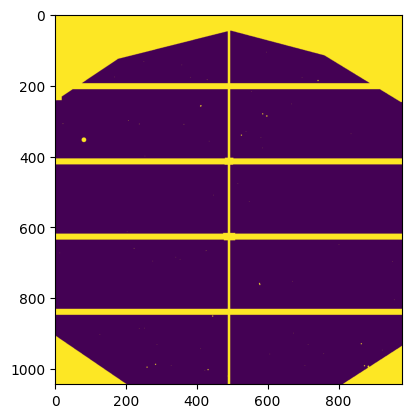

In [30]:
# Load the poni file and extract relevant parameters
saxs_mask = os.path.join(folder_path_poni_mask, "RT_SAXS_mask_03.edf")

#mask = "/Users/yuewu/Desktop/8091E/BL15_1M_gcarbon_mask_3.edf"
saxs_mask = fabio.open(saxs_mask).data
plt.imshow(saxs_mask)# display the mask

# WAXS

In [ ]:

# Load the poni file and extract relevant parameters
poni_file_path = os.path.join(folder_path_poni_mask, WAXS_poni_file)
ai_w = pyFAI.load(poni_file_path)

print(ai_w)



#Define detector parameters for 2D q conversion
pixel_size = ai_w.get_pixel1() # in meters 
wavelength = ai_w.get_wavelength() #1.54e-10  # in meters
detector_distance = ai_w.get_dist()  # in meters
beam_x= 668.647
beam_y= 105.765 # beam center x-coordinate in pixels


Detector Pilatus 100k	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.033202e-10 m
SampleDetDist= 1.576850e-01 m	PONI= 1.846850e-02, 1.468911e-02 m	rot1=-0.566608  rot2=-0.001481  rot3=0.000000 rad
DirectBeamDist= 186.891 mm	Center: x=668.647, y=105.765 pix	Tilt= 32.464° tiltPlanRotation= -0.158° 𝛌= 1.033Å


#mask for WAXS

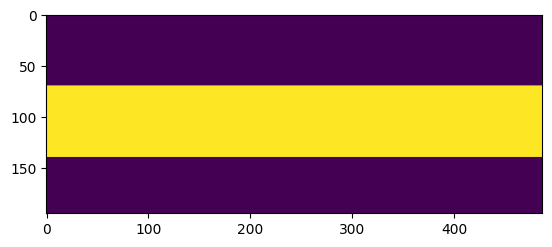

In [32]:
# Load the poni file and extract relevant parameters
waxs_mask = os.path.join(folder_path_poni_mask, "RT_WAXS_mask.edf")

#mask = "/Users/yuewu/Desktop/8091E/BL15_1M_gcarbon_mask_3.edf"
waxs_mask = fabio.open(waxs_mask).data
plt.imshow(waxs_mask)# display the mask

# offsets and air

In [33]:
# get this from Empty Beam: shutter closed 

i0_offset = 0.285816667
bstop_offset = 0.477621111

# average from without sample in the beam: named as "Air" is the satandard 

i0_air = 21.279793333333334
bstop_air = 18.650270000000003


# 

# function to calculate mu and thickness

Vivek: As discussed, we can pass the compound as a variable

In [ ]:
import periodictable as pt
import xraydb
import numpy as np

def calculate_sld_mu_thickness(energy_keV: float, density: float, transmission: float) -> Dict[str, float]:
    """
    Calculate scattering length density (SLD), absorption coefficient (mu), and thickness
    from transmission data for polyethylene (PE).
    
    Parameters
    ----------
    energy_keV : float
        X-ray energy in keV
    density : float
        Material density in g/cm³
    transmission : float
        Transmission factor (must be in range (0, 10])
        
    Returns
    -------
    Dict[str, float]
        Dictionary containing:
        - 'mu': absorption coefficient in 1/m
        - 'sld': scattering length density
        - 'thickness_m': sample thickness in meters
        
    Raises
    ------
    ValueError
        If transmission is outside valid range or calculation fails
    """
    try:
        # Define PE composition correctly
        material = pt.formula("C2H4")  # Assuming PE as (C2H4)n

        # Calculate scattering length density (SLD) and mu using periodictable
        sld, mu_pt = pt.xray_sld(material, energy=energy_keV, density=density)

        # Use xraydb for a more reliable absorption coefficient (mu) calculation
        mu_xraydb = xraydb.material_mu("C2H4", energy=energy_keV * 1000, density=density) * 100  # Convert to 1/m

        # Calculate thickness using transmission: T = exp(-mu * t) → t = -ln(T) / mu
        if transmission <= 0 or transmission > 10:
            raise ValueError("Transmission must be in the range (0, 1].")
        
        thickness = -np.log(transmission) / mu_xraydb  # Thickness in meters

        return {"mu": mu_xraydb, "sld": sld, "thickness_m": thickness}

    except Exception as e:
        raise ValueError(f"Error in calculating SLD, mu, and thickness for PE: {e}")

# Example usage
energy_keV = 12      # Energy in keV
density_PE = 0.92       # Density in g/cm^3
#transmission = 0.92   # Transmission (must be between 0 and 1)

#result = calculate_sld_mu_thickness(energy_keV, density_PE, transmission)
#print(result)

# Set the directory containing the raw and pdi files and list the keyword

Vivek: I would want more explanation on this. Are we looking for the raw and pdi files for the data of both WAXS and SAXS scattering through the directory? If we only need two folders (one for SAXS and another for WAXS), can we pass these in our eventual metadata file or read it in as an argument?

In [ ]:
import os
import fnmatch

def find_folders_with_keyword(folder_path: str, keyword: str, skip_folders: Optional[List[str]] = None) -> List[str]:
    """
    Find folders matching a keyword pattern, optionally skipping specified folders.
    
    Parameters
    ----------
    folder_path : str
        Path to search for folders
    keyword : str
        Pattern to match folder names (supports wildcards)
    skip_folders : Optional[List[str]], default None
        List of folder names to skip
        
    Returns
    -------
    List[str]
        List of folder names matching the keyword pattern
    """
    folder_names = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path) and fnmatch.fnmatch(item, keyword):
            if skip_folders is None or item not in skip_folders:
                folder_names.append(item)

    return folder_names

def get_keywords(raw_dir: str, common_keyword: str, keyword: str) -> Tuple[List[str], str, str, str]:
    """
    Get keywords and create folder structure for SAXS/WAXS data processing.
    
    Parameters
    ----------
    raw_dir : str
        Base directory containing raw data
    common_keyword : str
        Common folder name pattern
    keyword : str
        Specific keyword pattern to search for
        
    Returns
    -------
    Tuple[List[str], str, str, str]
        - List of sorted folder names (keywords)
        - SAXS folder path
        - WAXS folder path  
        - Data folder path
    """
    data_folder = os.path.join(raw_dir, common_keyword)
    base_SAXS_folder = "OneD_integrated_SAXS_01/Reduction"
    base_SAXS_folder = os.path.join(raw_dir, base_SAXS_folder)
    base_WAXS_folder = "OneD_integrated_WAXS_01/Reduction"
    base_WAXS_folder = os.path.join(raw_dir, base_WAXS_folder)

    SAXS_folder_name = create_update_subfolder(base_SAXS_folder, common_keyword)
    WAXS_folder_name = create_update_subfolder(base_WAXS_folder, common_keyword)

    folder_names_with_keyword = find_folders_with_keyword(data_folder, keyword)

    ctr_values = [int(name.split('_ctr')[-1]) for name in folder_names_with_keyword]
    sorted_folder_names = [x for _, x in sorted(zip(ctr_values, folder_names_with_keyword))]

    keywords = sorted_folder_names
    return keywords, SAXS_folder_name, WAXS_folder_name,data_folder



# read parameters function

In [ ]:
def process_and_store_selected_parameters_columns(data_folder: str, keywords: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Process CSV parameter files and extract selected columns for each keyword.
    
    Parameters
    ----------
    data_folder : str
        Path to folder containing CSV parameter files
    keywords : List[str]
        List of keyword patterns to search for files
        
    Returns
    -------
    Dict[str, pd.DataFrame]
        Dictionary mapping file names to DataFrames with selected columns
    """
    # Create an empty dictionary to store the selected columns for each file
    selected_columns_dict = {}

    for keyword in keywords:
        # Create a list of file paths that match the file types and current keyword
        #raw_file_pattern = f'*{keyword}/SAXS/*.raw'
        pdi_file_pattern = f'*{keyword}/*_scan1.csv'
        #raw_file_paths = sorted(glob.glob(os.path.join(raw_dir, raw_file_pattern)))
        pdi_file_paths = sorted(glob.glob(os.path.join(data_folder, pdi_file_pattern)))

        for pdi_file_path in pdi_file_paths:
            try:
                # Read the CSV file
                df = pd.read_csv(pdi_file_path)
                file_name = os.path.splitext(os.path.basename(pdi_file_path))[0]
                #print(f"Reading file: {file_name}")

                # Extract columns 4, 7, 9, and 15
                selected_columns = df.iloc[:, [2, 3, 6, 10, 29, 30]]

                # Store the selected columns in the dictionary with the file name as the key
                selected_columns_dict[file_name] = selected_columns

            except FileNotFoundError:
                print(f"File not found: {pdi_file_path}")
            except Exception as e:
                print(f"An error occurred: {e}")

    return selected_columns_dict

# Call the function and pass the raw_dir and keywords as arguments
#raw_dir = 'path_to_your_raw_files_directory'
#keywords = ['keyword1', 'keyword2', 'keyword3']  # Replace with your actual keywords
#
# To load the result_dict back from the file, you can use the following code:

#print(result_dict)

In [ ]:
import pandas as pd
import os
import glob

def read_parameters(data_folder: str, keyword: str, result_dict: Dict[str, pd.DataFrame]) -> Dict[str, List[float]]:
    """
    Reads and processes parameter data from CSV files matching a pattern, calculates averages, 
    and returns a dictionary with results.

    Parameters
    ----------
    data_folder : str
        Path to the folder containing CSV files.
    keyword : str
        Keyword to filter files.
    result_dict : Dict[str, pd.DataFrame]
        Dictionary containing preloaded DataFrames indexed by filenames.

    Returns
    -------
    Dict[str, List[float]]
        Dictionary containing averages and filenames with keys:
        - 'bstop_dx_avg': List of individual beamstop averages
        - 'ctemp_dx_avg': List of individual temperature averages  
        - 'timer_dx_avg': List of individual timer averages
        - 'i0_dx_avg': List of individual I0 averages
        - 'bstop_avg_all': List with overall beamstop average
        - 'ctemp_avg_all': List with overall temperature average
        - 'timer_avg_all': List with overall timer average
        - 'i0_avg_all': List with overall I0 average
        - 'avg_file_name': List of processed filenames
    """
    # Initialize lists to store results
    bstop_dx_avg, ctemp_dx_avg, timer_dx_avg, i0_dx_avg = [], [], [], []
    bstop_avg_all, ctemp_avg_all, timer_avg_all, i0_avg_all = [], [], [], []
    avg_file_name = []

    # File matching pattern
    pdi_file_pattern = f'*{keyword}/*_scan1.csv'
    pdi_file_paths = sorted(glob.glob(os.path.join(data_folder, pdi_file_pattern)))

    for pdi_file_path in pdi_file_paths:
        file_name = os.path.splitext(os.path.basename(pdi_file_path))[0]
        selected_columns = result_dict.get(file_name)

        if selected_columns is not None:
            try:
                # Access columns safely
                i0 = pd.to_numeric(selected_columns.iloc[:, 1], errors='coerce')
                bstop = pd.to_numeric(selected_columns.iloc[:, 2], errors='coerce')
                ctemp = pd.to_numeric(selected_columns.iloc[:, 4], errors='coerce')
                timer = pd.to_numeric(selected_columns.iloc[:, 5], errors='coerce')

                # Calculate averages
                i0_dx_avg.append(i0.mean(skipna=True))
                bstop_dx_avg.append(bstop.mean(skipna=True))
                ctemp_dx_avg.append(ctemp.mean(skipna=True))
                timer_dx_avg.append(timer.mean(skipna=True))

                # Add filename to results
                avg_file_name.append(file_name)
            except (ValueError, IndexError) as e:
                print(f"Error processing file '{file_name}': {str(e)}")
        else:
            print(f"File '{file_name}' not found in result_dict.")

    # Compute overall averages if data exists
    if i0_dx_avg:
        i0_avg_all.append(sum(i0_dx_avg) / len(i0_dx_avg))
        bstop_avg_all.append(sum(bstop_dx_avg) / len(bstop_dx_avg))
        ctemp_avg_all.append(sum(ctemp_dx_avg) / len(ctemp_dx_avg))
        timer_avg_all.append(sum(timer_dx_avg) / len(timer_dx_avg))

    return {
        'bstop_dx_avg': bstop_dx_avg,
        'ctemp_dx_avg': ctemp_dx_avg,
        'timer_dx_avg': timer_dx_avg,
        'i0_dx_avg': i0_dx_avg,
        'bstop_avg_all': bstop_avg_all,
        'ctemp_avg_all': ctemp_avg_all,
        'timer_avg_all': timer_avg_all,
        'i0_avg_all': i0_avg_all,
        'avg_file_name': avg_file_name,
    }

# SAXS Data reduction function

In [ ]:
from isort import file
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import re
#import warnings

# Filter warnings containing the substring "pyFAI.io"
#warnings.filterwarnings("ignore", message="pyFAI.io")

# Map a parameter (e.g., q) to a colormap


def custom_sort(file_name: str) -> Tuple[int, int]:
    """
    Custom sorting function for SAXS files based on keywords and counter values.
    
    Parameters
    ----------
    file_name : str
        File name to sort
        
    Returns
    -------
    Tuple[int, int]
        Tuple of (keyword_index, counter_value) for sorting
    """
    keywords = ['ctr', 'HoldT', 'Cooling','RampT', '']
    keyword_found = next((kw for kw in keywords if kw in file_name), '')
    ctr_value = int(file_name.split('ctr')[-1].split('_')[0]) if 'ctr' in file_name else 0
    return (keywords.index(keyword_found), ctr_value)



def process_SAXS_data(SAXS_folder_name: str, keywords: List[str], data_folder: str, 
                     ai: pyFAI.azimuthalIntegrator.AzimuthalIntegrator, mask: np.ndarray, 
                     i0_offset: float, bstop_offset: float, i0_air: float, bstop_air: float) -> None:
    """
    Process SAXS raw data files through normalization, correction, and 1D integration.
    
    Parameters
    ----------
    SAXS_folder_name : str
        Output folder path for processed SAXS data
    keywords : List[str]
        List of keyword patterns to process
    data_folder : str
        Path to folder containing raw data files
    ai : pyFAI.azimuthalIntegrator.AzimuthalIntegrator
        PyFAI integrator object with detector geometry
    mask : np.ndarray
        Detector mask array
    i0_offset : float
        I0 detector dark current offset
    bstop_offset : float
        Beamstop detector dark current offset  
    i0_air : float
        I0 reading for air/empty measurement
    bstop_air : float
        Beamstop reading for air/empty measurement
    """
    # print the processting saxs data
    print("Processing SAXS data...")

    save_SAXS_norm_files = os.path.join(SAXS_folder_name.replace("Reduction", ""), "Correction/Normlised")
    if not os.path.exists(save_SAXS_norm_files):
        os.makedirs(save_SAXS_norm_files)
    result_dict = process_and_store_selected_parameters_columns(data_folder, keywords)
    #warnings.filterwarnings('ignore')
    bstop = []
    ctemp = []
    timer = []
    i0 = []
    filename_p = []
    file_name_norm = []



    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(figsize=(8,8))
    c=0
    
    num_colors = len(keywords)  # Calculate the number of colors based on the maximum m_key
    
    #num_colors = 57
    
    print(num_colors)
    darker_colors = darken_colors(num_colors, darker_factor=0.7)
    for keyword in keywords:
        # Create a list of file paths that match the file types and current keyword
        raw_file_pattern = f'{keyword}/SAXS/*.raw'
        #raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)))
        raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)), key=custom_sort)
        #print(raw_file_paths)
        #print(keyword)



        # read parameters
        # Call the function
        averages_dict = read_parameters(data_folder, keyword, result_dict)

        # Access the averages from the returned dictionary
        bstop_avg_all = averages_dict['bstop_avg_all']
        ctemp_avg_all = averages_dict['ctemp_avg_all']
        timer_avg_all = averages_dict['timer_avg_all']
        i0_avg_all = averages_dict['i0_avg_all']
        avg_file_name = averages_dict['avg_file_name']


        #print(avg_file_name, raw_file_pattern, bstop_avg_all, ctemp_avg_all, timer_avg_all, i0_avg_all)

        bstop.append(bstop_avg_all[0])
        ctemp.append(ctemp_avg_all[0])
        timer.append(timer_avg_all[0])
        i0.append(i0_avg_all[0])
        filename_p.append(avg_file_name[0])  

        #print(i0_offset, bstop_offset)

        i0_avg_all[0] = i0_avg_all[0] - i0_offset
        bstop_avg_all[0] = bstop_avg_all[0] - bstop_offset

        i0_air = i0_air - i0_offset
        bstop_air = bstop_air - bstop_offset

        trans_factor = (bstop_avg_all[0])#/i0_avg_all[0])/(bstop_air/i0_air)
        
        trans_factor_t = (bstop_avg_all[0])#/i0_avg_all[0]
        #print(trans_factor)
        normfactor = trans_factor*i0_avg_all[0]

        result = calculate_sld_mu_thickness(energy_keV, density_PE, trans_factor_t)
        thickness = result['thickness_m']
        #thickness = 0.0001

        #normfactor = trans_factor #* thickness
        normfactor = float(normfactor)
        #print the transfactor, thicknes and normfactor in good format
        print(f"i0:{i0_avg_all[0]}, bstop: {bstop_avg_all[0]}, transmission factor: {trans_factor_t}, thickness: {thickness}, normfactor: {normfactor}")

        #normfactor = 1.0
        #print(normfactor)

        # Initialize the accumulators for the averaged image and pdi data
        avg_image = np.zeros((1043, 981))

        for i, raw_file_path in enumerate(raw_file_paths):
            # Read the raw file
            data = np.fromfile(raw_file_path, dtype=np.int32).reshape(1043, 981)
            avg_image += data

        avg_image /= len(raw_file_paths)

        # Assuming raw_file_paths[-1] contains the file path
        file_name, file_extension = os.path.splitext(os.path.basename(raw_file_paths[-1]))
        file_name = file_name.split('_scan')[0]
        file_name = file_name.split('sone_')[1]

        # Remove the last 10 characters from the file name and the ".raw" extension
        #file_name = file_name[5:-11]
        file_name=f"{file_name}_all_SAXS.dat"
        file_name_norm.append(file_name)

        q, I, error_avg = ai.integrate1d(avg_image, 1000, error_model='poisson', mask=mask, normalization_factor=normfactor, filename=os.path.join(SAXS_folder_name, file_name))
        
        I_norm = I
        I_norm_sigma = error_avg
        
        axs.loglog(q, I, label=f"{file_name}", color=darker_colors[c])
        axs.set_xlabel("q (nm$^{-1}$)")
        axs.set_ylabel("Intensity (a.u.)")
        axs.set_xlim([0.05, 3])
        set_plot_style(axs,20, 'q (nm$^{-1}$)', 'Intensity (a.u.)')
        #axs.legend(fontsize=12)




        # Create a DataFrame for subtracted data
        data = {"q_nm^-1": q, "I_avg_nomrlised": I_norm, "I_norm_sigma": I_norm_sigma}
        df = pd.DataFrame(data)

        # Saving the normalized data to a file
        # remove .dat extension
        file_name = file_name[:-4]

        # remove a string from middle of the file name from _10s to _d and attached first and last part




        dat_filename = f"{save_SAXS_norm_files}/{file_name}_Norm.dat"

        inst_parameters = f'Timer: {timer_avg_all[0]}, bstop: {bstop_avg_all[0]}, ctemp: {ctemp_avg_all[0]}, I0: {i0_avg_all[0]}'
        headers = [
            f"filename: {file_name}",
            f"background : {''}",
            f'Empty : {""}',
            f"{inst_parameters}", 
            'fit_data',
            "q_nm^-1 ------ I_avg_nomrlised ------ I_norm_sigma"]
        commented_headers = ['# ' + header for header in headers]

        with open(dat_filename, 'w') as dat_file:
            dat_file.write('\n'.join(commented_headers) + '\n')
            df.to_csv(dat_file, sep='\t', index=False, header=False)


        plt.tight_layout()
        
        c=c+1
        
    plt.show()

    # Initialize the result list with the first value as 0
    duration = [0]

    # Extracting the minimum timestamp from all the timer values
    min_timer = min(timer)
    #print(timer)

    # Subtract the minimum timestamp from each timer value and append to the result list
    for i in range(1, len(timer)):
        duration_avg = (timer[i] - min_timer) / 3600
        duration.append(duration_avg)
    
    # save the filename, duration, bstop, ctemp, i0 values in a xlsx file
   
    df = pd.DataFrame(list(zip(file_name_norm, timer, bstop, ctemp, i0)), columns =['Filename', 'Timer', 'Bstop', 'Ctemp', 'I0'])
    df.to_excel(os.path.join(SAXS_folder_name, 'SAXS_parameters.xlsx'), index=False)




# Create a figure and subplots
    fig, (axs1,axs2) = plt.subplots(1,2, figsize=(10, 4))

    # Plot data on the first subplot
    axs1.plot(duration, bstop, 'o', color='b', label='bstop')
    axs1.plot(duration, i0, 'o', color='r', label='I0')
    #axs1.grid(True)
    axs1.legend()
    axs1.set_xlabel('Duration [hr]')
    axs1.set_ylabel('Bstop and I0')
    set_plot_style(axs1,20, 'Duration', 'Bstop, I0')
    

    # Plot data on the second subplot
    axs2.plot(duration, ctemp, 'o', color='r', label='ctemp')
    #axs2.grid(True)
    axs2.legend()
    axs2.set_xlabel('Duration')
    axs2.set_ylabel('Ctemp')
    set_plot_style(axs2,20, 'Duration [hr]', 'Ctemp [C]')

    # Show the plots
    plt.tight_layout()
    plt.show()

'''
#raw_dir_aceto = '/Users/akmaurya/OneDrive - Stanford/Data_01/Acetolysis/May2024/'
#raw_dir_meth = 'C:/Users/akmaurya/OneDrive - Stanford/Data_01/Methanolysis/May2024/'

raw_dir = r'X:\bl1-5\Anjani\Autoxidation\Jan2025\atT'


# Run1
common_keyword = ""
keyword = "Run5*"

keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir, common_keyword, keyword)
"""
print("Keywords:")
for kw in keywords:
    print(f"    '{kw}',")
"""

#process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai)
#process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w)
'''
#help(ai.integrate1d)

# WAXS Data reduction function

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re

import warnings

# Filter warnings containing the substring "pyFAI.io"
warnings.filterwarnings("ignore", message="pyFAI.io")

# Your plotting code here...
def custom_sort(file_name: str) -> Tuple[int, int]:
    """
    Custom sorting function for WAXS files based on keywords and counter values.
    
    Parameters
    ----------
    file_name : str
        File name to sort
        
    Returns  
    -------
    Tuple[int, int]
        Tuple of (keyword_index, counter_value) for sorting
    """
    keywords = ['ctr', 'RampT', 'HoldT', 'Cooling', '']
    keyword_found = next((kw for kw in keywords if kw in file_name), '')
    ctr_value = int(file_name.split('ctr')[-1].split('_')[0]) if 'ctr' in file_name else 0
    return (keywords.index(keyword_found), ctr_value)

def process_WAXS_data(WAXS_folder_name: str, keywords: List[str], data_folder: str,
                     ai_w: pyFAI.azimuthalIntegrator.AzimuthalIntegrator, mask: Optional[np.ndarray], 
                     i0_offset: float, bstop_offset: float, i0_air: float, bstop_air: float) -> None:
    """
    Process WAXS raw data files through normalization, correction, and 1D integration.
    
    Parameters
    ----------
    WAXS_folder_name : str
        Output folder path for processed WAXS data
    keywords : List[str]
        List of keyword patterns to process
    data_folder : str
        Path to folder containing raw data files
    ai_w : pyFAI.azimuthalIntegrator.AzimuthalIntegrator
        PyFAI integrator object with detector geometry for WAXS
    mask : Optional[np.ndarray]
        Detector mask array, can be None
    i0_offset : float
        I0 detector dark current offset
    bstop_offset : float
        Beamstop detector dark current offset
    i0_air : float
        I0 reading for air/empty measurement
    bstop_air : float
        Beamstop reading for air/empty measurement
    """
    # print the processting waxs data
    print("Processing WAXS data...")
    save_SAXS_norm_files = os.path.join(WAXS_folder_name.replace("Reduction", ""), "Correction/Normlised")
    if not os.path.exists(save_SAXS_norm_files):
        os.makedirs(save_SAXS_norm_files)

    result_dict = process_and_store_selected_parameters_columns(data_folder, keywords)
    #warnings.filterwarnings('ignore')
            # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(figsize=(12,12))
    
    bstop = []
    ctemp = []
    timer = []
    i0 = []
    filename_p = []
    file_name_norm = []

    c=0 
    
    num_colors = len(keywords)
    
    darker_colors = darken_colors(num_colors, darker_factor=0.7)

    for keyword in keywords:
        # Create a list of file paths that match the file types and current keyword
        raw_file_pattern = f'{keyword}/WAXS/*.raw'
        #raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)))
        raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)), key=custom_sort)


# Call the function

        averages_dict = read_parameters(data_folder, keyword, result_dict)

        # Access the averages from the returned dictionary
        bstop_avg_all = averages_dict['bstop_avg_all']
        ctemp_avg_all = averages_dict['ctemp_avg_all']
        timer_avg_all = averages_dict['timer_avg_all']
        i0_avg_all = averages_dict['i0_avg_all']
        avg_file_name = averages_dict['avg_file_name']

        

        #print(avg_file_name, raw_file_pattern, bstop_avg_all, ctemp_avg_all, timer_avg_all, i0_avg_all)

        bstop.append(bstop_avg_all[0])
        ctemp.append(ctemp_avg_all[0])
        timer.append(timer_avg_all[0])
        i0.append(i0_avg_all[0])
        filename_p.append(avg_file_name[0]) 

        i0_avg_all[0] = i0_avg_all[0] - i0_offset
        bstop_avg_all[0] = bstop_avg_all[0] - bstop_offset

        i0_air = i0_air - i0_offset
        bstop_air = bstop_air - bstop_offset

        trans_factor = (bstop_avg_all[0])#/i0_avg_all[0])/(bstop_air/i0_air)
        trans_factor_t = (bstop_avg_all[0])/i0_avg_all[0]
        #print(trans_factor)
        trans_factor = trans_factor*i0_avg_all[0]

        result = calculate_sld_mu_thickness(energy_keV, density_PE, trans_factor_t)
        thickness = result['thickness_m']

        normfactor = trans_factor #* thickness
        normfactor = float(normfactor)
        #print the transfactor, thicknes and normfactor in good format
        print(f"i0:{i0_avg_all[0]}, bstop: {bstop_avg_all[0]}, transmission factor: {trans_factor_t}, thickness: {thickness}, normfactor: {normfactor}")

        normfactor = float(normfactor)
        #normfactor = 1.0
        #print(normfactor)


        # Initialize the accumulators for the averaged image and pdi data
        avg_image = np.zeros((195, 487))

        for i, raw_file_path in enumerate(raw_file_paths):
            # Read the raw file
            data = np.fromfile(raw_file_path, dtype=np.int32).reshape(195, 487)
            avg_image += data

            file_name = os.path.splitext(os.path.basename(raw_file_path))[0]

        avg_image /= len(raw_file_paths)

        # Assuming raw_file_paths[-1] contains the file path
        file_name, file_extension = os.path.splitext(os.path.basename(raw_file_paths[-1]))

        # Remove the last 10 characters from the file name and the ".raw" extension
        # split the file name _scan and remove the last part of the file name
        file_name = file_name.split('_scan')[0]
        file_name=f"{file_name}_all_WAXS.dat"
        file_name=file_name.split('b_tassone_')[1]
        file_name_norm.append(file_name)



        q, I, error_avg = ai_w.integrate1d(avg_image, 1000,error_model='poisson', mask=mask,normalization_factor=normfactor,filename=os.path.join(WAXS_folder_name, file_name))
   
        I_norm = I
        I_norm_sigma = error_avg

        axs.plot(q, I, '-', label=f"{file_name}",color=darker_colors[c])
        axs.set_xlabel("q (nm$^{-1}$)")
        axs.set_ylabel("Intensity (a.u.)")
        set_plot_style(axs,20, 'q (nm$^{-1}$)', 'Intensity (a.u.)')
        #axs.set_xlim([0.05, 3])
        #axs.legend(fontsize=12)

        # Create a DataFrame for subtracted data
        data = {"q_nm^-1": q, "I_avg_nomrlised": I_norm, "I_norm_sigma": I_norm_sigma}
        df = pd.DataFrame(data)

        # Saving the normalized data to a file
        # remove .dat extension
        file_name = file_name[:-4]
        dat_filename = f"{save_SAXS_norm_files}/{file_name}_Norm.dat"

        inst_parameters = f'Timer: {timer_avg_all[0]}, bstop: {bstop_avg_all[0]}, ctemp: {ctemp_avg_all[0]}, I0: {i0_avg_all[0]}'
        headers = [
            f"filename: {file_name}",
            f"background : {''}",
            f'Empty : {""}',
            f"{inst_parameters}", 
            'fit_data',
            "q_nm^-1 ------ I_avg_nomrlised ------ I_norm_sigma"]
        commented_headers = ['# ' + header for header in headers]

        with open(dat_filename, 'w') as dat_file:
            dat_file.write('\n'.join(commented_headers) + '\n')
            df.to_csv(dat_file, sep='\t', index=False, header=False)



        c = c+1
        plt.tight_layout()
        
        
    plt.show()


    # Initialize the result list with the first value as 0
    duration = [0]

    # Extracting the minimum timestamp from all the timer values
    min_timer = min(timer)
    #print(timer)

    # Subtract the minimum timestamp from each timer value and append to the result list
    for i in range(1, len(timer)):
        duration_avg = (timer[i] - min_timer) / 3600
        duration.append(duration_avg)
    # save the filename, duration, bstop, ctemp, i0 values in a xlsx file
   
    df = pd.DataFrame(list(zip(file_name_norm, timer, bstop, ctemp, i0)), columns =['Filename', 'Timer', 'Bstop', 'Ctemp', 'I0'])
    df.to_excel(os.path.join(WAXS_folder_name, 'WAXS_parameters.xlsx'), index=False)



# Create a figure and subplots
    fig, (axs1,axs2) = plt.subplots(1,2, figsize=(10, 4))

    # Plot data on the first subplot
    axs1.plot(duration, bstop, 'o', color='b', label='bstop')
    axs1.plot(duration, i0, 'o', color='r', label='I0')
    #axs1.grid(True)
    axs1.legend()
    axs1.set_xlabel('Duration [hr]')
    axs1.set_ylabel('Bstop and I0')
    set_plot_style(axs1,20, 'Duration', 'Bstop, I0')
    

    # Plot data on the second subplot
    axs2.plot(duration, ctemp, 'o', color='r', label='ctemp')
    #axs2.grid(True)
    axs2.legend()
    axs2.set_xlabel('Duration')
    axs2.set_ylabel('Ctemp')
    set_plot_style(axs2,20, 'Duration [hr]', 'Ctemp [C]')

    # Show the plots
    plt.tight_layout()
    plt.show()


# Ploting function

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

def darken_colors(num_colors: int, darker_factor: float = 0.7) -> np.ndarray:
    """
    Darken a set of colors by reducing the value component in the HSV color space.

    Parameters
    ----------
    num_colors : int
        Number of colors to generate.
    darker_factor : float, default 0.7
        Factor to control the darkness of the colors.

    Returns
    -------
    np.ndarray
        Darkened colors in RGB format.
    """
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))

    # Make the colors darker by reducing the value component
    darker_colors = colors.copy()

    for i in range(num_colors):
        rgb = darker_colors[i, :3]  # Extract the RGB values
        hsv = plt.cm.colors.rgb_to_hsv(rgb)  # Convert RGB to HSV
        hsv[2] *= darker_factor  # Reduce the value component
        darker_colors[i, :3] = plt.cm.colors.hsv_to_rgb(hsv)  # Convert back to RGB

    return darker_colors

def read_data_files(folder_path: str, keywords: List[str]) -> Tuple[pd.DataFrame, List[int], List[str]]:
    """
    Read and process data files matching given keywords from a folder.
    
    Parameters
    ----------
    folder_path : str
        Path to folder containing data files
    keywords : List[str]
        List of keyword patterns to search for
        
    Returns
    -------
    Tuple[pd.DataFrame, List[int], List[str]]
        - Combined DataFrame with all data
        - List of m_key values for color mapping
        - List of legend labels (file names)
    """
    data_list = []
    m_key = 0  # Initialize m_key to 0
    m_keys = []  # Create a list to store m_key for each file
    legend = []  # Create a list to store legends

    def sort_key(filename: str) -> Union[int, float]:
        ctr_index = filename.find("ctr")
        if ctr_index != -1:
            numeric_part = filename[ctr_index + 3:]
            numeric_part = numeric_part.split('_')[0]  # Extract numeric part before the next underscore
            try:
                return int(numeric_part)
            except ValueError:
                return float('inf')
        else:
            return float('inf')

    for keyword in keywords:
        files = glob.glob(os.path.join(folder_path, f"*{keyword}*.dat"))
        files = sorted(files, key=lambda x: (sort_key(x), x))

        for file in files:
            try:
                with open(file, 'r') as f:
                    lines = f.readlines()

                start_index = None
                for i, line in enumerate(lines):
                    if line.strip().startswith("#"):
                        continue
                    else:
                        start_index = i
                        break

                if start_index is not None:
                    df = pd.read_csv(file, delim_whitespace=True, skiprows=start_index, header=None,
                                     names=["q_nm^-1", "I", 'sigma', ])
                    df["File"] = file
                    if not df.empty:
                        data_list.append(df)

                        # Extract temperature from the filename
                        # temperature = file.split('_T')[1].split('_')[0]

                        # Print only the file name (without path) just before plotting
                        file_name = os.path.basename(file)
                        #print(f" {file_name}")

                        # Check if temperature is present in the filename

                        legend.append(file_name)

                        m_keys.append(m_key)  # Append m_key for this file to the list
            except Exception as e:
                print(f"Error reading file {file}: {str(e)}")
            m_key += 1  # Increment m_key for each file
        m_key += 1  # Increment m_key by 2 when switching keywords

    # After the loop, concatenate the DataFrames
    data = pd.concat(data_list, ignore_index=True)

    # print(legend)
    return data, m_keys, legend



import matplotlib.pyplot as plt

def create_saxs_waxs_plot(folder_path_saxs: str, folder_path_waxs: str, keywords: List[str], 
                         m_keys: List[int], data_saxs: pd.DataFrame, data_waxs: pd.DataFrame, 
                         legend_saxs: List[str], legend_waxs: List[str]) -> None:
    """
    Create combined SAXS-WAXS plots with customized styling and save to file.
    
    Parameters
    ----------
    folder_path_saxs : str
        Path to SAXS data folder
    folder_path_waxs : str  
        Path to WAXS data folder
    keywords : List[str]
        List of keywords used for file selection
    m_keys : List[int]
        List of color mapping keys
    data_saxs : pd.DataFrame
        SAXS data DataFrame
    data_waxs : pd.DataFrame
        WAXS data DataFrame
    legend_saxs : List[str]
        SAXS legend labels
    legend_waxs : List[str]
        WAXS legend labels
    """
    # Create a 1x2 grid of subplots
    fig = plt.figure(figsize=(12, 8))
    fonts = 20
    
    num_colors = max(m_keys) + 1  # Calculate the number of colors based on the maximum m_key
    darker_colors = darken_colors(num_colors, darker_factor=0.7)
    
    #print(keywords)
    
    # SAXS plot
    plt.subplot(1, 2, 1)
    plt.title('SAXS',fontsize=fonts)
    for i, file in enumerate(data_saxs["File"].unique()):
        subset = data_saxs[data_saxs["File"] == file]
        qmin, qmax = 0, 2.5
        subset = subset[(subset["q_nm^-1"] >= qmin) & (subset["q_nm^-1"] <= qmax)]
        
        # Check if any data points are present before plotting
        if not subset.empty:
            #print(file)
            #print(subset)
            plt.loglog(subset["q_nm^-1"], subset["I"] * (1 ** m_keys[i]), markersize=0.5, color=darker_colors[m_keys[i]],label=legend_saxs[i].replace('_all_SAXS.dat', '') if legend_saxs is not None else None)

    plt.xlim(0.07, 2)
    plt.xlabel('q [$\\mathrm{nm^{-1}}$]', fontsize=fonts)
    plt.ylabel("Intensity [a.u.]", fontsize=fonts)
    plt.xticks(fontsize=fonts)  # Set x-axis tick to 20
    plt.yticks(fontsize=fonts)  # Set y-axis tick to 20
    
    plt.gca().set_facecolor('white')
    plt.gca().spines['top'].set_linewidth(1)
    plt.gca().spines['right'].set_linewidth(1)
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().spines['left'].set_linewidth(1)
    plt.tick_params(axis='both', which='both', direction='out', length=4, width=1)

    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=False)
    #plt.legend(loc='upper right', fontsize=10, frameon=True)

    # WAXS plot
    plt.subplot(1, 2, 2)
    plt.title('WAXS',fontsize=fonts)
    for i, file in enumerate(data_waxs["File"].unique()):
        subset = data_waxs[data_waxs["File"] == file]
        
        qmin, qmax = 10, 40
        subset = subset[(subset["q_nm^-1"] >= qmin) & (subset["q_nm^-1"] <= qmax)]
        
        
        plt.plot(subset["q_nm^-1"], subset["I"] + (0* m_keys[i]), markersize=0.5,color=darker_colors[m_keys[i]], label=legend_waxs[i].replace('_all_WAXS.dat', '') if legend_waxs is not None else None)

    #plt.xlim(10, 25)
    plt.xlabel('q [$\\mathrm{nm^{-1}}$]', fontsize=fonts)
    plt.ylabel("Intensity [a.u.]", fontsize=fonts)
    plt.xticks(fontsize=fonts)  # Set x-axis tick to 20
    plt.yticks(fontsize=fonts)  # Set y-axis tick to 20
    plt.gca().set_facecolor('white')
    plt.gca().spines['top'].set_linewidth(1)
    plt.gca().spines['right'].set_linewidth(1)
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().spines['left'].set_linewidth(1)
    plt.tick_params(axis='both', which='both', direction='out', length=4, width=1)

    #plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=8, frameon=False)

    

    # Adjust layout and show the plot
    plt.tight_layout()
    
    
    
    ###################### save figure
    # Use the first 30 characters of the first keyword as the figure name
    figure_name = keywords[0][:30].replace('*', '')
    
    
    # Save the figure to the specified folder path with the given name
    #plt.savefig(f"{folder_path}/{figure_name}.png", dpi=300)
    
    
    # Create the "Figure" folder if it doesn't exist
    #figure_folder = os.path.join(folder_path_saxs, 'Figure_SAXS_WAXS')
    #os.makedirs(figure_folder, exist_ok=True)
    figure_folder = os.path.join(os.path.dirname(folder_path_saxs), 'Figure_saxs_waxs_Reduced')
    os.makedirs(figure_folder, exist_ok=True)


    # Save the figure in the specified folder
    figure_path = os.path.join(figure_folder, f'{figure_name}_SAXS_WAXS.png')
    plt.savefig(figure_path, dpi=300)

    ###################
    plt.show()
    

        
        

        
def plot_saxs_waxs_data(all_keywords: List[List[str]], Run_number: str) -> None:
    """
    Plot SAXS and WAXS data for multiple keyword sets.
    
    Parameters
    ----------
    all_keywords : List[List[str]]
        List of keyword lists to process
    Run_number : str
        Run identifier string (currently unused but kept for compatibility)
    """
    #folder_path_saxs_base = r'X:\bl1-5\Anjani\Autoxidation\Jan2025\RT\RTSoak\OneD_integrated_SAXS_01\Reduction'
    #folder_path_waxs_base = r'X:\bl1-5\Anjani\Autoxidation\Jan2025\RT\RTSoak\OneD_integrated_WAXS_01\Reduction'
    folder_path_saxs_base = r'/Users/akmaurya/OneDrive - Stanford/Data_01/Autoxidation/Autoxidation/Jan2025/atT/OneD_integrated_SAXS_01/Reduction'
    folder_path_waxs_base = r'/Users/akmaurya/OneDrive - Stanford/Data_01/Autoxidation/Autoxidation/Jan2025/atT/OneD_integrated_WAXS_01/Reduction'

    for keywords in all_keywords:
        # Read SAXS data
        result_data_saxs, m_keys_saxs, legend_saxs = read_data_files(folder_path_saxs_base, keywords)

        # Read WAXS data
        result_data_waxs, m_keys_waxs, legend_waxs = read_data_files(folder_path_waxs_base, keywords)

        # Create SAXS-WAXS combined plot
        create_saxs_waxs_plot(
            folder_path_saxs_base,
            folder_path_waxs_base,
            keywords,
            m_keys_saxs,
            result_data_saxs,
            result_data_waxs,
            legend_saxs,
            legend_waxs,
        )
# https://pubs.rsc.org/en/content/articlelanding/2021/gc/d0gc03536j

# Data Reduction

#Standards

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
1
i0:0.24110333333333334, bstop: 0.5088733333333333, transmission factor: 0.5088733333333333, thickness: 0.005755213319569055, normfactor: 0.1226910569111111


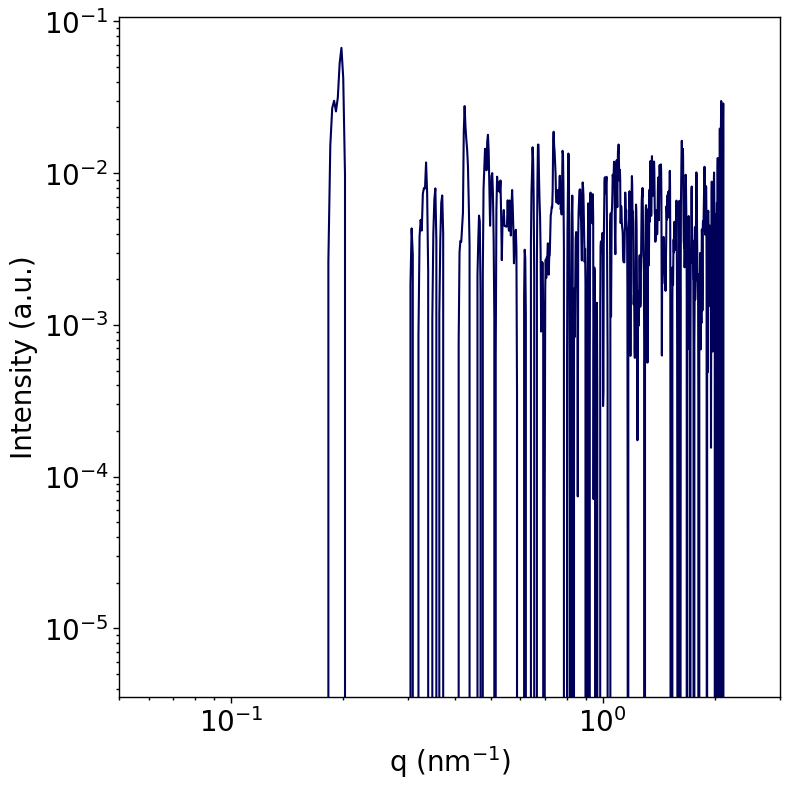

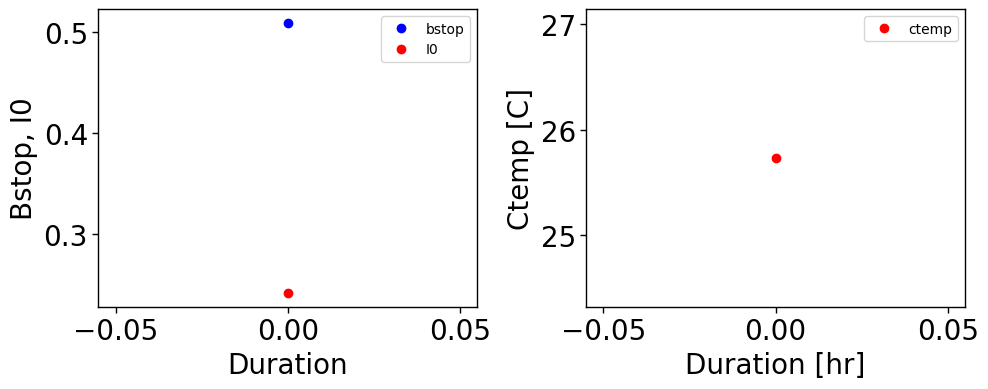

Processing WAXS data...
i0:0.24110333333333334, bstop: 0.5088733333333333, transmission factor: 2.110602646168309, thickness: -0.0063636338359722424, normfactor: 0.1226910569111111


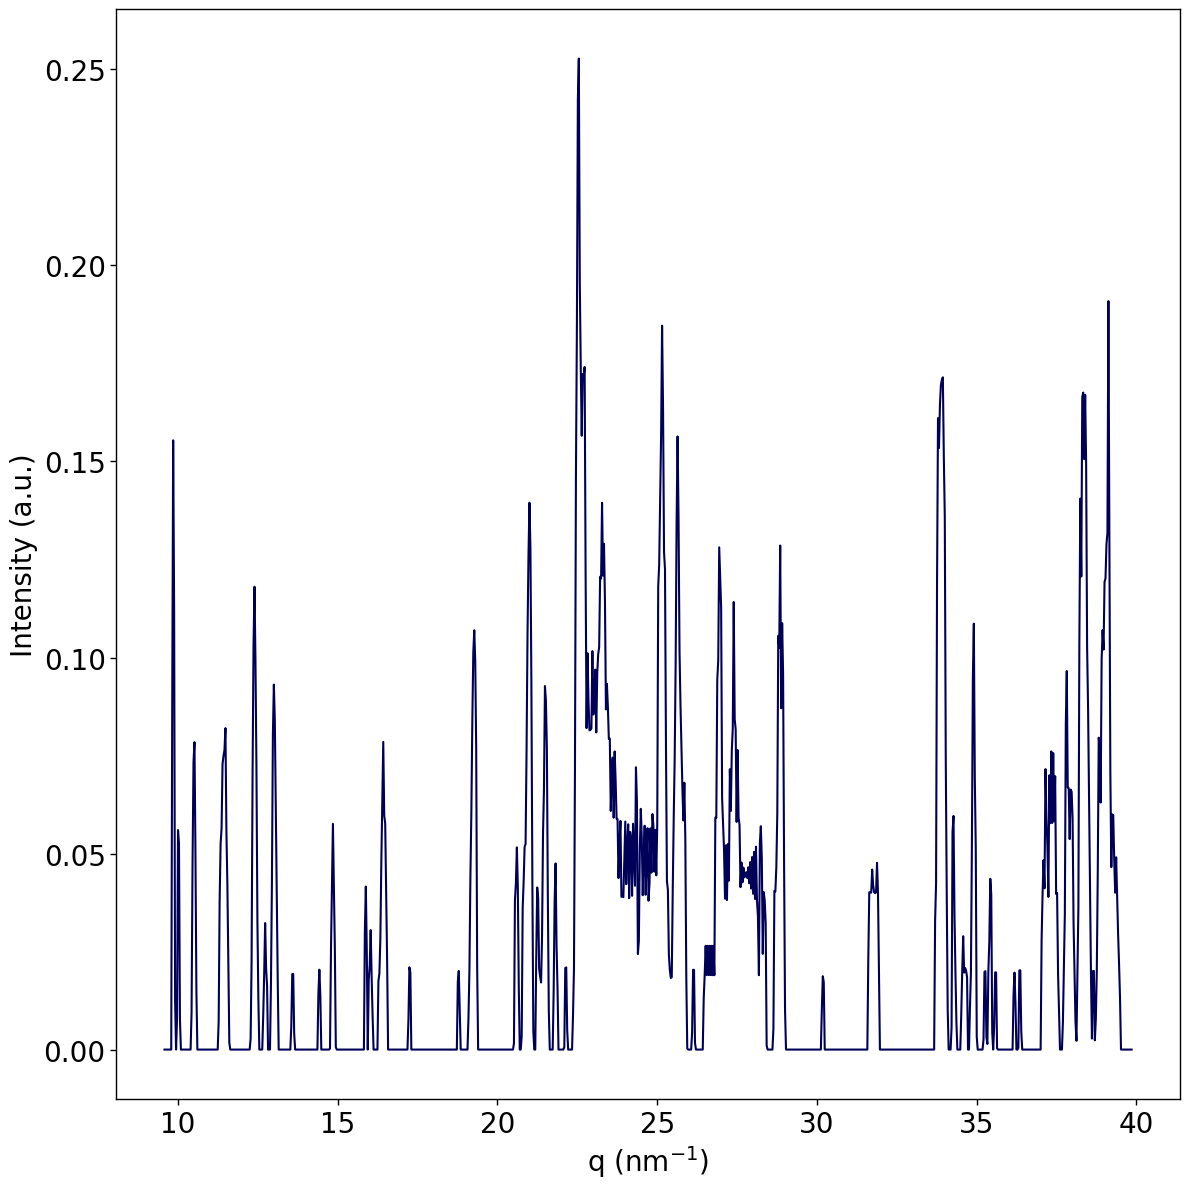

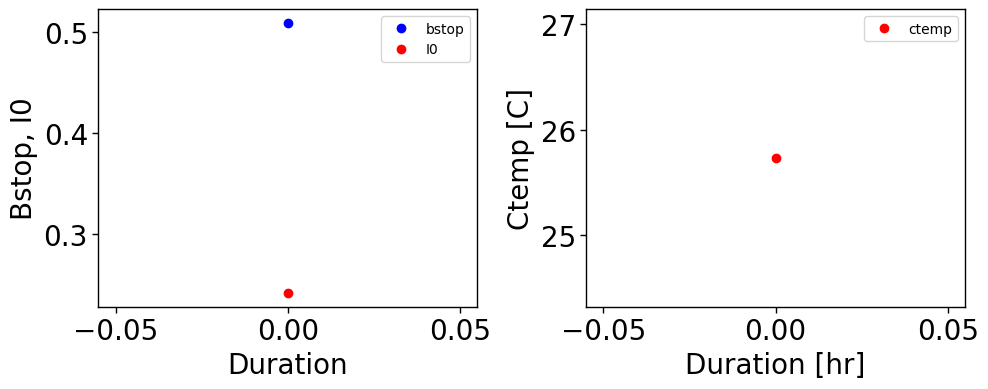

In [41]:
#raw_dir_meth = r'X:\bl1-5\Anjani\Autoxidation\Jan2025\RT\RTSoak'
# Run 23c
#common_keyword = ""  # folder name
#keyword = "*Empty*" # file name

#keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir_meth, common_keyword, keyword)

#process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai)
#process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w)


raw_dir = os.path.join(base_dir, 'Standards')

#raw_dir_meth = r'X:\bl1-5\Anjani\RedesignedPlastic\Jan2025\Fibers3'


common_keyword = ""  # folder name
common_keyword = ""  # folder name
keywords = ["*Empty_beam*" ]# file name

i0_offset = 0
bstop_offset = 0
i0_air = 0
bstop_air = 0


# loop over the keywords
for keyword in keywords:
     keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir, common_keyword, keyword)
     
     process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai, saxs_mask, i0_offset, bstop_offset, i0_air, bstop_air)
     process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w, waxs_mask, i0_offset, bstop_offset, i0_air, bstop_air)


## Autoxidation at T

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
33
i0:20.661496666666668, bstop: 5.766629999999999, transmission factor: 5.766629999999999, thickness: -0.014926426761499271, normfactor: 119.14720652289999
i0:20.637976666666667, bstop: 5.746003333333334, transmission factor: 5.746003333333334, thickness: -0.014895899713260436, normfactor: 118.58588271992224
i0:20.604113333333334, bstop: 5.74027, transmission factor: 5.74027, thickness: -0.014887395031789636, normfactor: 118.27317364393333


i0:20.546183333333335, bstop: 5.733666666666667, transmission factor: 5.733666666666667, thickness: -0.014877589282359393, normfactor: 117.80496650555557
i0:20.504886666666668, bstop: 5.72732, transmission factor: 5.72732, thickness: -0.01486815402615658, normfactor: 117.43804750373333
i0:20.77165666666667, bstop: 5.790616666666668, transmission factor: 5.790616666666668, thickness: -0.014961789518111309, normfactor: 120.28070128827781
i0:20.93955, bstop: 5.831503333333334, transmission factor: 5.831503333333334, thickness: -0.015021731087988507, normfactor: 122.10905562350001
i0:20.891416666666668, bstop: 5.819263333333333, transmission factor: 5.819263333333333, thickness: -0.015003830922588265, normfactor: 121.57265498972222


i0:20.81385, bstop: 5.810723333333333, transmission factor: 5.810723333333333, thickness: -0.014991319442102463, normfactor: 120.94352385149998
i0:20.795199999999998, bstop: 5.802426666666666, transmission factor: 5.802426666666666, thickness: -0.014979146833690924, normfactor: 120.66262301866665
i0:20.757653333333334, bstop: 5.790773333333334, transmission factor: 5.790773333333334, thickness: -0.014962020004820687, normfactor: 120.20286538524446
i0:20.68040333333333, bstop: 5.781383333333333, transmission factor: 5.781383333333333, thickness: -0.01494819448866802, normfactor: 119.56133915794443
i0:20.867793333333335, bstop: 5.840510000000001, transmission factor: 5.840510000000001, thickness: -0.015034878745187602, normfactor: 121.8785556412667


i0:20.861036666666667, bstop: 5.841106666666666, transmission factor: 5.841106666666666, thickness: -0.01503574902477441, normfactor: 121.85154034724442
i0:20.831233333333333, bstop: 5.823693333333334, transmission factor: 5.823693333333334, thickness: -0.0150103138392246, normfactor: 121.31471468844445
i0:20.78465, bstop: 5.8169200000000005, transmission factor: 5.8169200000000005, thickness: -0.015000399663658818, normfactor: 120.902646278
i0:20.752883333333333, bstop: 5.804526666666667, transmission factor: 5.804526666666667, thickness: -0.01498222953205608, normfactor: 120.46066471855556
i0:20.666733333333333, bstop: 5.800353333333334, transmission factor: 5.800353333333334, thickness: -0.014976102185985598, normfactor: 119.87435557911111


i0:20.615003333333334, bstop: 5.78661, transmission factor: 5.78661, thickness: -0.014955892823111232, normfactor: 119.2909844387
i0:20.87045, bstop: 5.851253333333333, transmission factor: 5.851253333333333, thickness: -0.015050535044962596, normfactor: 122.11829013066668
i0:20.85109, bstop: 5.846603333333333, transmission factor: 5.846603333333333, thickness: -0.015043762113964914, normfactor: 121.90805229763333
i0:20.76872, bstop: 5.837393333333332, transmission factor: 5.837393333333332, thickness: -0.015030331425769745, normfactor: 121.23518766986663
i0:20.741253333333336, bstop: 5.826809999999999, transmission factor: 5.826809999999999, thickness: -0.015014871853163919, normfactor: 120.8553423352


i0:20.697663333333335, bstop: 5.81597, transmission factor: 5.81597, thickness: -0.014999008218943241, normfactor: 120.37698901676667
i0:20.619056666666665, bstop: 5.80095, transmission factor: 5.80095, thickness: -0.014976978490331234, normfactor: 119.6101167705
i0:20.576496666666667, bstop: 5.802683333333334, transmission factor: 5.802683333333334, thickness: -0.014979523667777602, normfactor: 119.39889426605558
i0:20.85552, bstop: 5.86352, transmission factor: 5.86352, thickness: -0.015068376193283191, normfactor: 122.2867586304
i0:20.788963333333335, bstop: 5.852496666666666, transmission factor: 5.852496666666666, thickness: -0.01505234510305439, normfactor: 121.66733861178889


i0:20.73725, bstop: 5.8446533333333335, transmission factor: 5.8446533333333335, thickness: -0.015040920249305182, normfactor: 121.20203733666666
i0:20.71543, bstop: 5.8382000000000005, transmission factor: 5.8382000000000005, thickness: -0.015031508611863338, normfactor: 120.94082342600002
i0:20.61937, bstop: 5.826483333333333, transmission factor: 5.826483333333333, thickness: -0.0150143942291946, normfactor: 120.13841564883333
i0:20.57845, bstop: 5.81684, transmission factor: 5.81684, thickness: -0.015000282498129808, normfactor: 119.701551098
i0:20.55257333333333, bstop: 5.8056133333333335, transmission factor: 5.8056133333333335, thickness: -0.01498382426828624, normfactor: 119.3202937783111


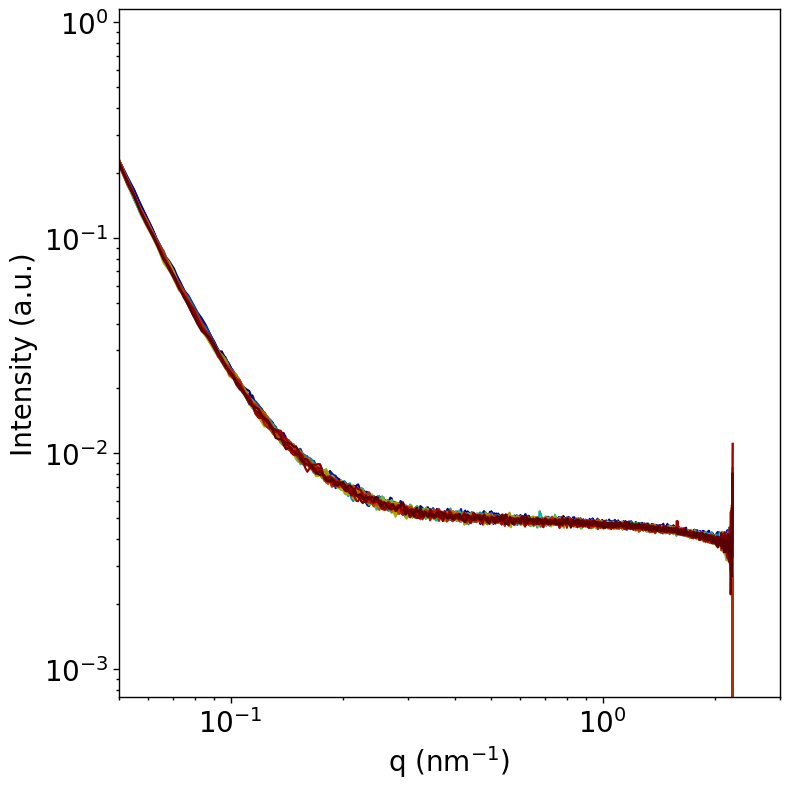

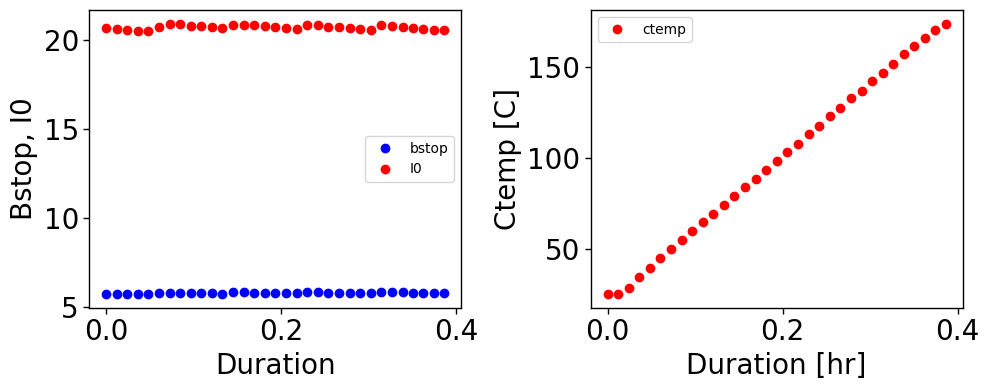

Processing WAXS data...
i0:20.661496666666668, bstop: 5.766629999999999, transmission factor: 0.2791003039631365, thickness: 0.01087209622435196, normfactor: 119.14720652289999
i0:20.637976666666667, bstop: 5.746003333333334, transmission factor: 0.27841892769526994, thickness: 0.010892919897449754, normfactor: 118.58588271992224
i0:20.604113333333334, bstop: 5.74027, transmission factor: 0.27859825400559174, thickness: 0.010887434534014445, normfactor: 118.27317364393333
i0:20.546183333333335, bstop: 5.733666666666667, transmission factor: 0.2790623724925392, thickness: 0.010873254118501848, normfactor: 117.80496650555557
i0:20.504886666666668, bstop: 5.72732, transmission factor: 0.27931488201349075, thickness: 0.010865548987276466, normfactor: 117.43804750373333
i0:20.77165666666667, bstop: 5.790616666666668, transmission factor: 0.2787749075382689, thickness: 0.010882034378592835, normfactor: 120.28070128827781
i0:20.93955, bstop: 5.831503333333334, transmission factor: 0.278492294

i0:20.81385, bstop: 5.810723333333333, transmission factor: 0.2791758052130352, thickness: 0.010869791945299422, normfactor: 120.94352385149998
i0:20.795199999999998, bstop: 5.802426666666666, transmission factor: 0.27902721140776077, thickness: 0.01087432758456694, normfactor: 120.66262301866665
i0:20.757653333333334, bstop: 5.790773333333334, transmission factor: 0.2789705194678397, thickness: 0.010876058671418866, normfactor: 120.20286538524446
i0:20.68040333333333, bstop: 5.781383333333333, transmission factor: 0.2795585385907206, thickness: 0.010858120597526133, normfactor: 119.56133915794443
i0:20.867793333333335, bstop: 5.840510000000001, transmission factor: 0.27988153355298073, thickness: 0.010848283381770709, normfactor: 121.8785556412667
i0:20.861036666666667, bstop: 5.841106666666666, transmission factor: 0.280000786154603, thickness: 0.010844654263794022, normfactor: 121.85154034724442
i0:20.831233333333333, bstop: 5.823693333333334, transmission factor: 0.279565460198388,

i0:20.76872, bstop: 5.837393333333332, transmission factor: 0.2810665911685136, thickness: 0.010812287950435923, normfactor: 121.23518766986663
i0:20.741253333333336, bstop: 5.826809999999999, transmission factor: 0.2809285391946741, thickness: 0.010816473380096886, normfactor: 120.8553423352
i0:20.697663333333335, bstop: 5.81597, transmission factor: 0.2809964538670146, thickness: 0.010814414100891873, normfactor: 120.37698901676667
i0:20.619056666666665, bstop: 5.80095, transmission factor: 0.28133925299201373, thickness: 0.010804027485065506, normfactor: 119.6101167705
i0:20.576496666666667, bstop: 5.802683333333334, transmission factor: 0.2820054077880767, thickness: 0.01078387952182488, normfactor: 119.39889426605558
i0:20.85552, bstop: 5.86352, transmission factor: 0.28114954697844985, thickness: 0.010809773902962387, normfactor: 122.2867586304
i0:20.788963333333335, bstop: 5.852496666666666, transmission factor: 0.2815194087760348, thickness: 0.010798573940807294, normfactor: 12

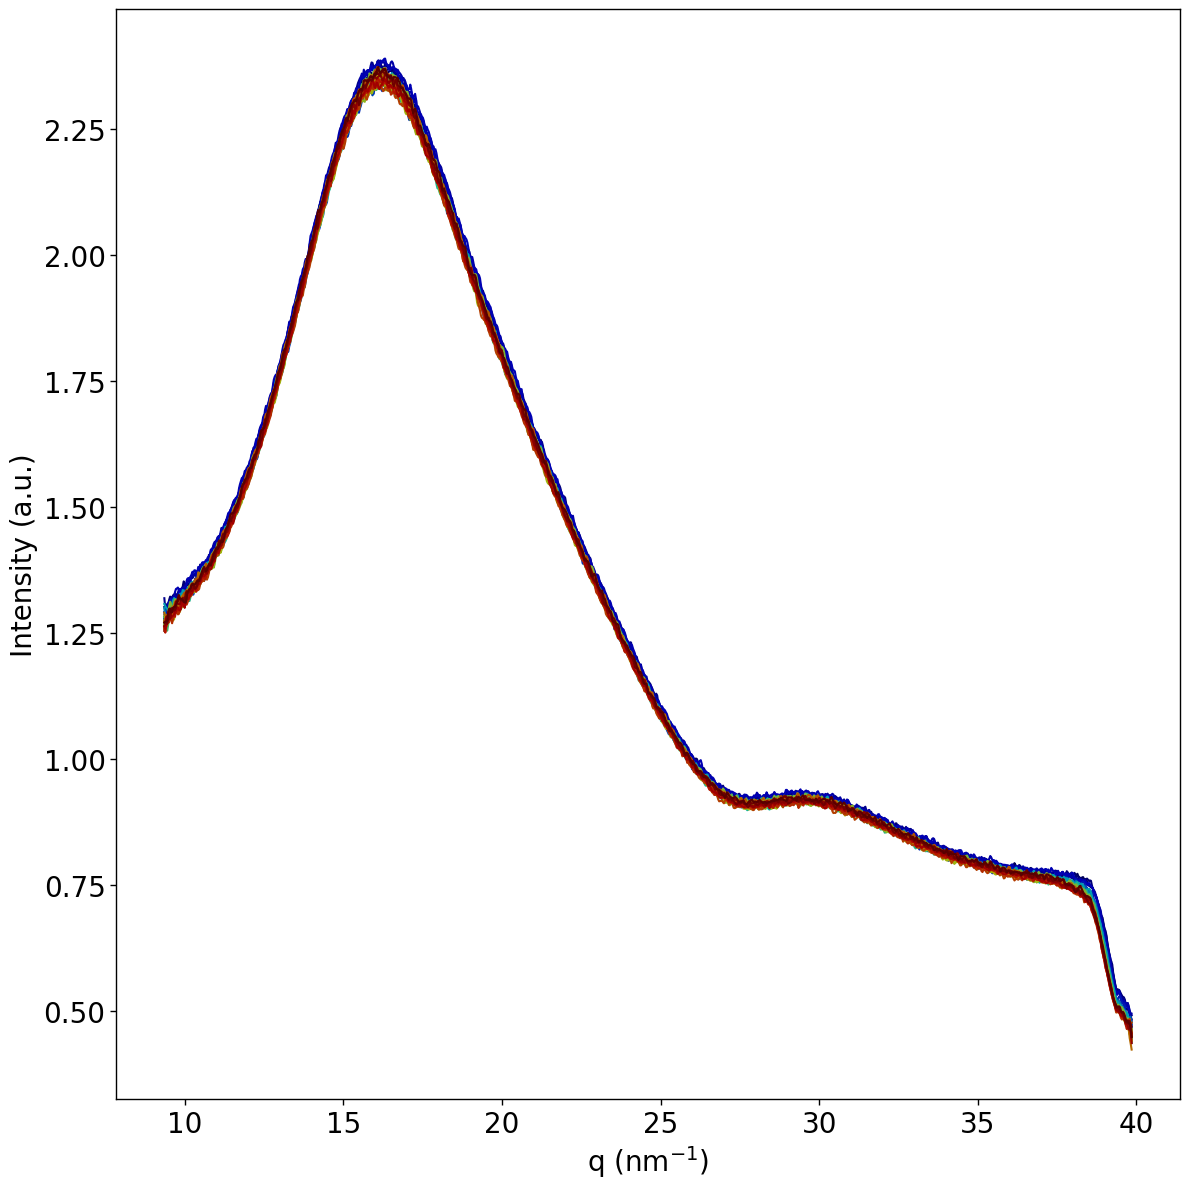

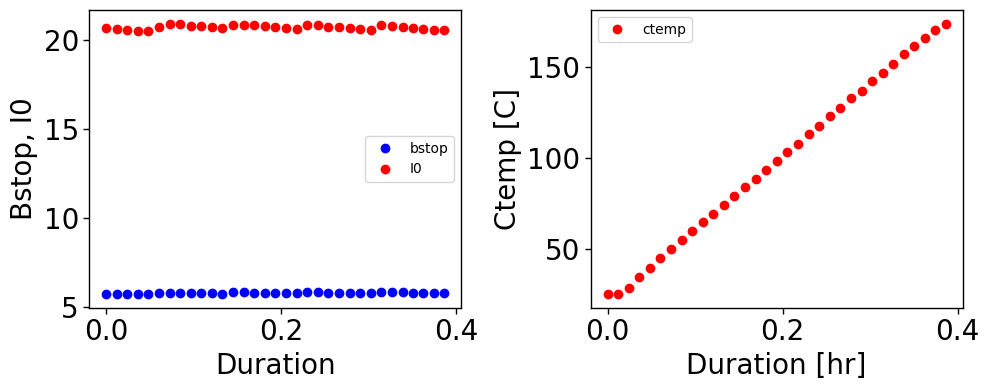

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
65
i0:20.938636666666667, bstop: 5.840843333333333, transmission factor: 5.840843333333333, thickness: -0.015035364945860809, normfactor: 122.29929638358888


i0:20.921406666666666, bstop: 5.830806666666667, transmission factor: 5.830806666666667, thickness: -0.015020713269298457, normfactor: 121.98867746804444
i0:20.893069999999998, bstop: 5.810923333333332, transmission factor: 5.810923333333332, thickness: -0.014991612661231382, normfactor: 121.40802796796663
i0:20.83780333333333, bstop: 5.799493333333333, transmission factor: 5.799493333333333, thickness: -0.01497483897418384, normfactor: 120.84870151297775
i0:20.73201, bstop: 5.787286666666667, transmission factor: 5.787286666666667, thickness: -0.014956888974062554, normfactor: 119.9820850462
i0:20.742136666666667, bstop: 5.78169, transmission factor: 5.78169, thickness: -0.014948646368817481, normfactor: 119.9246041443


i0:20.93518, bstop: 5.838693333333334, transmission factor: 5.838693333333334, thickness: -0.015032228463703008, normfactor: 122.23409589813335
i0:20.918186666666667, bstop: 5.829153333333333, transmission factor: 5.829153333333333, thickness: -0.015018297289296786, normfactor: 121.93531753528889
i0:20.877156666666664, bstop: 5.81963, transmission factor: 5.81963, thickness: -0.015004367694415413, normfactor: 121.49732725203332
i0:20.79771666666667, bstop: 5.807546666666667, transmission factor: 5.807546666666667, thickness: -0.014986660791252637, normfactor: 120.7837101017778
i0:20.782663333333332, bstop: 5.800446666666667, transmission factor: 5.800446666666667, thickness: -0.014976239267472987, normfactor: 120.54873025628888


i0:21.01381333333333, bstop: 5.858826666666666, transmission factor: 5.858826666666666, thickness: -0.01506155442704143, normfactor: 123.11628992568887
i0:20.92560333333333, bstop: 5.837656666666667, transmission factor: 5.837656666666667, thickness: -0.015030715731675479, normfactor: 122.15648780285555
i0:20.848119999999998, bstop: 5.829620000000001, transmission factor: 5.829620000000001, thickness: -0.01501897928854073, normfactor: 121.53661731440002
i0:20.81392, bstop: 5.819333333333333, transmission factor: 5.819333333333333, thickness: -0.015003933399821848, normfactor: 121.12313845333333


i0:20.770363333333332, bstop: 5.800503333333334, transmission factor: 5.800503333333334, thickness: -0.014976322494442765, normfactor: 120.47856174954445
i0:20.99655, bstop: 5.867506666666666, transmission factor: 5.867506666666666, thickness: -0.015074166530949997, normfactor: 123.197397102
i0:20.957256666666666, bstop: 5.856400000000001, transmission factor: 5.856400000000001, thickness: -0.01505802512029744, normfactor: 122.73407794266667
i0:20.90917, bstop: 5.84461, transmission factor: 5.84461, thickness: -0.015040857085988566, normfactor: 122.20594407370001
i0:20.84414, bstop: 5.835886666666667, transmission factor: 5.835886666666667, thickness: -0.015028132278818876, normfactor: 121.64403870413334


i0:20.77344666666667, bstop: 5.81923, transmission factor: 5.81923, thickness: -0.015003782123472345, normfactor: 120.88546404606667
i0:20.939493333333335, bstop: 5.868986666666667, transmission factor: 5.868986666666667, thickness: -0.015076315119872202, normfactor: 122.8936071800889
i0:20.907236666666666, bstop: 5.860913333333333, transmission factor: 5.860913333333333, thickness: -0.015064588074270486, normfactor: 122.53550214282222
i0:20.80968, bstop: 5.848056666666667, transmission factor: 5.848056666666667, thickness: -0.01504587953687478, normfactor: 121.69618785520001
i0:20.7305, bstop: 5.823603333333334, transmission factor: 5.823603333333334, thickness: -0.015010182181197483, normfactor: 120.72620890166667


i0:20.97469, bstop: 5.876296666666668, transmission factor: 5.876296666666668, thickness: -0.015086919466279687, normfactor: 123.25350093136667
i0:20.870060000000002, bstop: 5.859466666666666, transmission factor: 5.859466666666666, thickness: -0.01506248498961216, normfactor: 122.28742090133333
i0:20.765863333333332, bstop: 5.842089999999999, transmission factor: 5.842089999999999, thickness: -0.01503718309046587, normfactor: 121.3160425210333
i0:20.700313333333334, bstop: 5.823316666666667, transmission factor: 5.823316666666667, thickness: -0.015009762812437788, normfactor: 120.54447963922223
i0:20.88855, bstop: 5.879203333333334, transmission factor: 5.879203333333334, thickness: -0.015091132394931681, normfactor: 122.8080327885


i0:20.809070000000002, bstop: 5.862333333333333, transmission factor: 5.862333333333333, thickness: -0.015066651887606548, normfactor: 121.98970469666666
i0:20.756583333333335, bstop: 5.843393333333332, transmission factor: 5.843393333333332, thickness: -0.015039083463219341, normfactor: 121.28888067277776
i0:20.657466666666668, bstop: 5.818543333333333, transmission factor: 5.818543333333333, thickness: -0.015002776799490181, normfactor: 120.1963649568889
i0:20.85352333333333, bstop: 5.87716, transmission factor: 5.87716, thickness: -0.015088171000908453, normfactor: 122.55949319373332
i0:20.799333333333333, bstop: 5.85748, transmission factor: 5.85748, thickness: -0.015059596036275429, normfactor: 121.83167901333333


i0:20.70527, bstop: 5.835113333333333, transmission factor: 5.835113333333333, thickness: -0.015027003292620732, normfactor: 120.81759704726666
i0:20.828453333333332, bstop: 5.87229, transmission factor: 5.87229, thickness: -0.015081108778027728, normfactor: 122.31071822479998
i0:20.846613333333334, bstop: 5.87947, transmission factor: 5.87947, thickness: -0.015091518797832286, normfactor: 122.56703769493335
i0:20.761313333333334, bstop: 5.8613333333333335, transmission factor: 5.8613333333333335, thickness: -0.015065198550004488, normfactor: 121.68897788444445
i0:20.67021, bstop: 5.838793333333332, transmission factor: 5.838793333333332, thickness: -0.015032374372202378, normfactor: 120.68908434659998


i0:20.884656666666668, bstop: 5.894159999999999, transmission factor: 5.894159999999999, thickness: -0.015112777737951054, normfactor: 123.0975079384
i0:20.854836666666667, bstop: 5.88088, transmission factor: 5.88088, thickness: -0.015093561611894268, normfactor: 122.64479185626668
i0:20.75476, bstop: 5.861236666666667, transmission factor: 5.861236666666667, thickness: -0.015065058047560278, normfactor: 121.64856031986668
i0:20.640953333333332, bstop: 5.84212, transmission factor: 5.84212, thickness: -0.015037226837828063, normfactor: 120.58692628773333
i0:20.89997333333333, bstop: 5.910903333333334, transmission factor: 5.910903333333334, thickness: -0.01513694368748641, normfactor: 123.53772204257777


i0:20.81502, bstop: 5.887523333333334, transmission factor: 5.887523333333334, thickness: -0.015103179916276788, normfactor: 122.54891593380002
i0:20.70958, bstop: 5.866363333333333, transmission factor: 5.866363333333333, thickness: -0.015072506326531688, normfactor: 121.48992076073333
i0:20.62396, bstop: 5.84506, transmission factor: 5.84506, thickness: -0.015041512989919601, normfactor: 120.54828363760001
i0:20.85699, bstop: 5.910679999999999, transmission factor: 5.910679999999999, thickness: -0.015136621797200246, normfactor: 123.27899365319999


i0:20.762629999999998, bstop: 5.888343333333334, transmission factor: 5.888343333333334, thickness: -0.01510436637038473, normfactor: 122.25749394296668
i0:20.680526666666665, bstop: 5.869, transmission factor: 5.869, thickness: -0.015076334474066456, normfactor: 121.37401100666665
i0:20.58438333333333, bstop: 5.846633333333334, transmission factor: 5.846633333333334, thickness: -0.015043805827556057, normfactor: 120.34934174277778
i0:20.775716666666668, bstop: 5.9028566666666675, transmission factor: 5.9028566666666675, thickness: -0.015125338346499581, normfactor: 122.63607763061114
i0:20.72554333333333, bstop: 5.886886666666666, transmission factor: 5.886886666666666, thickness: -0.01510225861233459, normfactor: 122.0089247084222


i0:20.659209999999998, bstop: 5.863433333333333, transmission factor: 5.863433333333333, thickness: -0.015068250272659149, normfactor: 121.13390055433332
i0:20.618550000000003, bstop: 5.867896666666667, transmission factor: 5.867896666666667, thickness: -0.015074732765750953, normfactor: 120.98752081650002
i0:20.784166666666668, bstop: 5.905593333333333, transmission factor: 5.905593333333333, thickness: -0.015129287090564122, normfactor: 122.74283610555555
i0:20.69677, bstop: 5.881186666666667, transmission factor: 5.881186666666667, thickness: -0.015094005847032032, normfactor: 121.72156776706669
i0:20.596813333333333, bstop: 5.856116666666666, transmission factor: 5.856116666666666, thickness: -0.015057612949308616, normfactor: 120.61734184155554


i0:20.81455, bstop: 5.916563333333333, transmission factor: 5.916563333333333, thickness: -0.015145097387001743, normfactor: 123.15060332983334
i0:20.665896666666665, bstop: 5.89446, transmission factor: 5.89446, thickness: -0.015113211336936253, normfactor: 121.81430126579998
i0:20.574920000000002, bstop: 5.8680200000000005, transmission factor: 5.8680200000000005, thickness: -0.015074911823624781, normfactor: 120.73404205840002
i0:20.627356666666667, bstop: 5.884243333333333, transmission factor: 5.884243333333333, thickness: -0.015098432446804831, normfactor: 121.37638595012223
i0:20.68800333333333, bstop: 5.908473333333333, transmission factor: 5.908473333333333, thickness: -0.015133440675063647, normfactor: 122.2345160149111


i0:20.591036666666664, bstop: 5.88573, transmission factor: 5.88573, thickness: -0.015100584574807355, normfactor: 121.19328224009998


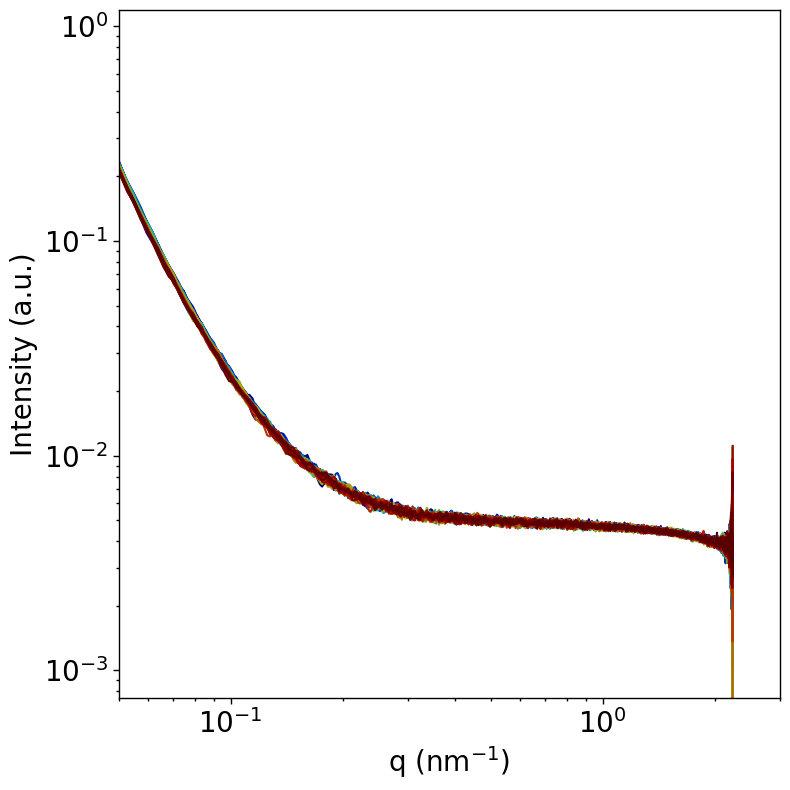

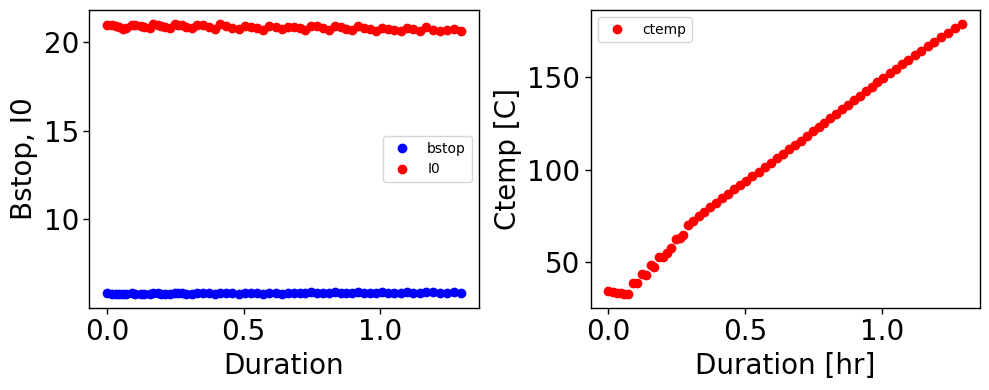

Processing WAXS data...
i0:20.938636666666667, bstop: 5.840843333333333, transmission factor: 0.2789505079206844, thickness: 0.010876669807476072, normfactor: 122.29929638358888


i0:20.921406666666666, bstop: 5.830806666666667, transmission factor: 0.2787005080283002, thickness: 0.010884308294127716, normfactor: 121.98867746804444
i0:20.893069999999998, bstop: 5.810923333333332, transmission factor: 0.27812683025200857, thickness: 0.010901862355048152, normfactor: 121.40802796796663
i0:20.83780333333333, bstop: 5.799493333333333, transmission factor: 0.2783159645266512, thickness: 0.010896071006510173, normfactor: 120.84870151297775
i0:20.73201, bstop: 5.787286666666667, transmission factor: 0.2791473989577792, thickness: 0.01087065882389327, normfactor: 119.9820850462
i0:20.742136666666667, bstop: 5.78169, transmission factor: 0.27874129328688574, thickness: 0.010883061675363865, normfactor: 119.9246041443
i0:20.93518, bstop: 5.838693333333334, transmission factor: 0.27889386827977286, thickness: 0.010878399772826019, normfactor: 122.23409589813335
i0:20.918186666666667, bstop: 5.829153333333333, transmission factor: 0.2786643711628286, thickness: 0.0108854129

i0:20.81392, bstop: 5.819333333333333, transmission factor: 0.27958853177745147, thickness: 0.010857206638915174, normfactor: 121.12313845333333
i0:20.770363333333332, bstop: 5.800503333333334, transmission factor: 0.2792682650873224, thickness: 0.010866970942028646, normfactor: 120.47856174954445
i0:20.99655, bstop: 5.867506666666666, transmission factor: 0.2794509891704431, thickness: 0.010861398672181298, normfactor: 123.197397102
i0:20.957256666666666, bstop: 5.856400000000001, transmission factor: 0.279444971884838, thickness: 0.010861582114539707, normfactor: 122.73407794266667
i0:20.90917, bstop: 5.84461, transmission factor: 0.2795237687579182, thickness: 0.010859180233819913, normfactor: 122.20594407370001
i0:20.84414, bstop: 5.835886666666667, transmission factor: 0.2799773301592998, thickness: 0.010845367959003895, normfactor: 121.64403870413334
i0:20.77344666666667, bstop: 5.81923, transmission factor: 0.28012828556455244, thickness: 0.010840775886644042, normfactor: 120.88

i0:20.765863333333332, bstop: 5.842089999999999, transmission factor: 0.28133142871176875, thickness: 0.010804264415080412, normfactor: 121.3160425210333
i0:20.700313333333334, bstop: 5.823316666666667, transmission factor: 0.28131538749655, thickness: 0.010804750185841771, normfactor: 120.54447963922223
i0:20.88855, bstop: 5.879203333333334, transmission factor: 0.28145578957530965, thickness: 0.010800499376058925, normfactor: 122.8080327885
i0:20.809070000000002, bstop: 5.862333333333333, transmission factor: 0.28172010250017576, thickness: 0.010792502794928603, normfactor: 121.98970469666666
i0:20.756583333333335, bstop: 5.843393333333332, transmission factor: 0.2815199996788167, thickness: 0.01079855605917285, normfactor: 121.28888067277776
i0:20.657466666666668, bstop: 5.818543333333333, transmission factor: 0.281667806959227, thickness: 0.010794084360161103, normfactor: 120.1963649568889
i0:20.85352333333333, bstop: 5.87716, transmission factor: 0.28183055237508225, thickness: 0.

i0:20.761313333333334, bstop: 5.8613333333333335, transmission factor: 0.28231996883947935, thickness: 0.010774382107520136, normfactor: 121.68897788444445
i0:20.67021, bstop: 5.838793333333332, transmission factor: 0.2824738274711932, thickness: 0.010769740569312267, normfactor: 120.68908434659998
i0:20.884656666666668, bstop: 5.894159999999999, transmission factor: 0.2822244145103654, thickness: 0.01077726602116472, normfactor: 123.0975079384
i0:20.854836666666667, bstop: 5.88088, transmission factor: 0.28199117998366807, thickness: 0.01078430934653686, normfactor: 122.64479185626668
i0:20.75476, bstop: 5.861236666666667, transmission factor: 0.28240445404652553, thickness: 0.010771833082627231, normfactor: 121.64856031986668
i0:20.640953333333332, bstop: 5.84212, transmission factor: 0.28303537659597766, thickness: 0.010752821432952442, normfactor: 120.58692628773333
i0:20.89997333333333, bstop: 5.910903333333334, transmission factor: 0.2828187021610235, thickness: 0.010759345722310

i0:20.58438333333333, bstop: 5.846633333333334, transmission factor: 0.28403247445676866, thickness: 0.010722862028455142, normfactor: 120.34934174277778
i0:20.775716666666668, bstop: 5.9028566666666675, transmission factor: 0.2841228902653178, thickness: 0.010720150543286944, normfactor: 122.63607763061114
i0:20.72554333333333, bstop: 5.886886666666666, transmission factor: 0.28404016107016417, thickness: 0.010722631480571487, normfactor: 122.0089247084222
i0:20.659209999999998, bstop: 5.863433333333333, transmission factor: 0.28381691910452206, thickness: 0.010729329814372211, normfactor: 121.13390055433332
i0:20.618550000000003, bstop: 5.867896666666667, transmission factor: 0.2845930808260846, thickness: 0.010706063866448765, normfactor: 120.98752081650002
i0:20.784166666666668, bstop: 5.905593333333333, transmission factor: 0.28413904815364255, thickness: 0.01071966607427356, normfactor: 122.74283610555555
i0:20.69677, bstop: 5.881186666666667, transmission factor: 0.2841596377921

i0:20.591036666666664, bstop: 5.88573, transmission factor: 0.2858394210684876, thickness: 0.01066883643973325, normfactor: 121.19328224009998


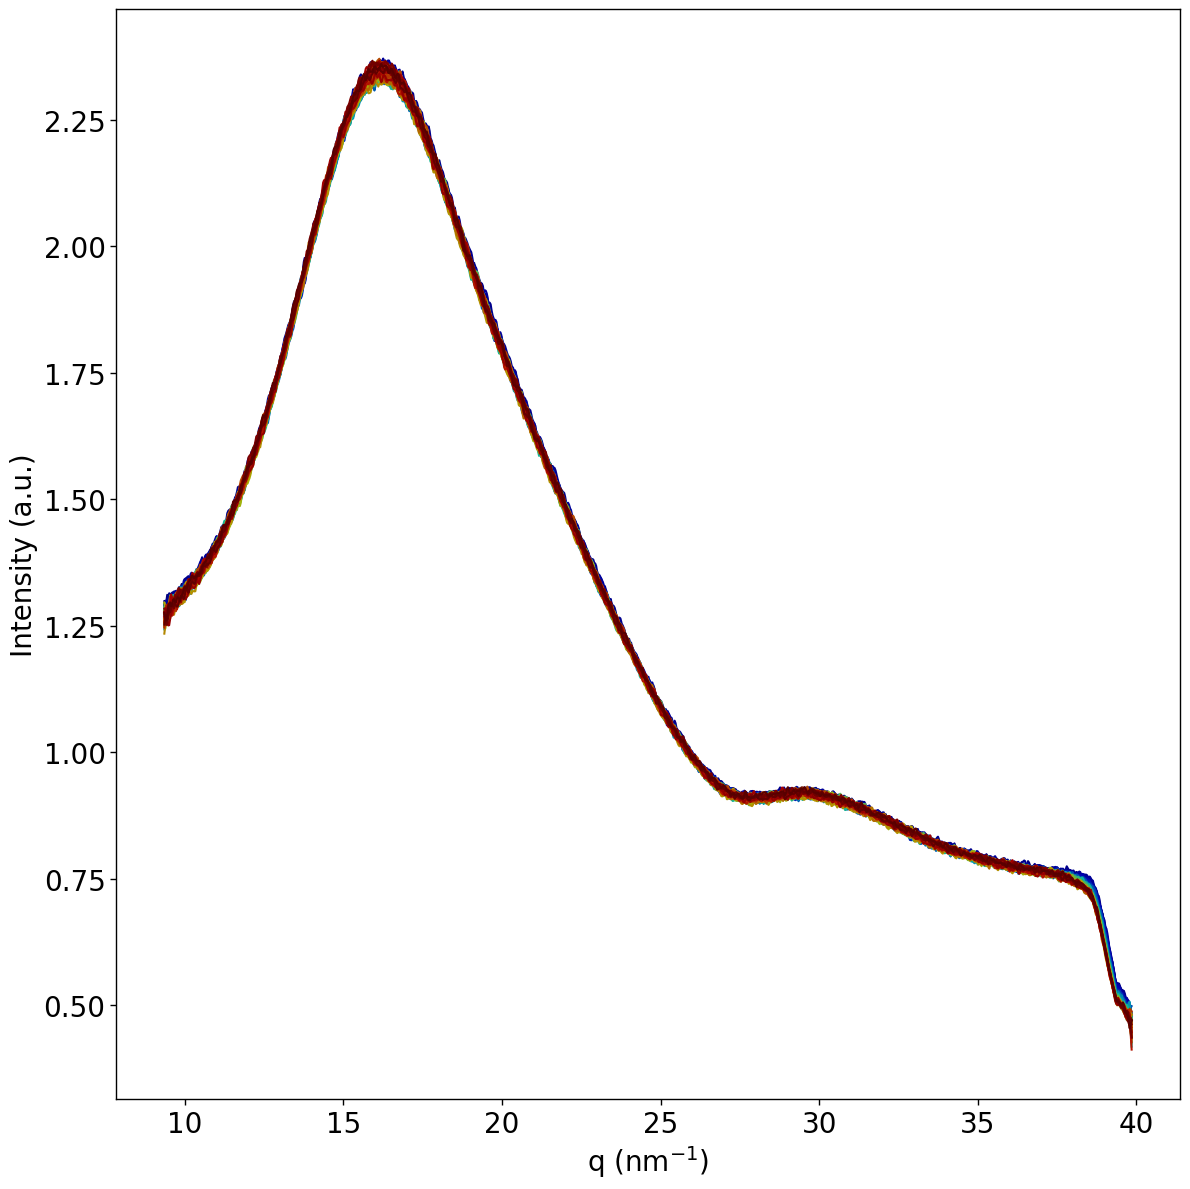

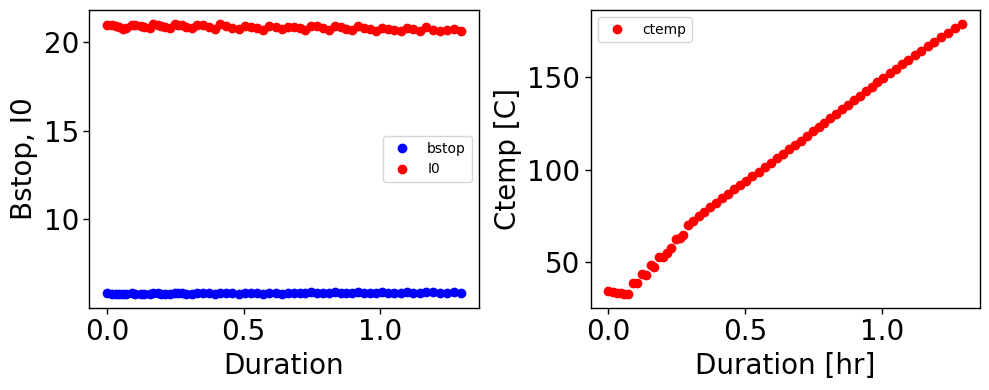

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
4
i0:20.963, bstop: 5.10255, transmission factor: 5.10255, thickness: -0.013884121666495082, normfactor: 106.96475565
i0:21.034063333333332, bstop: 5.111533333333333, transmission factor: 5.111533333333333, thickness: -0.01389910706170016, normfactor: 107.51631586377776
i0:21.012416666666667, bstop: 5.100546666666666, transmission factor: 5.100546666666666, thickness: -0.013880776242307597, normfactor: 107.17481178777777
i0:21.160856666666668, bstop: 5.139686666666667, transmission factor: 5.139686666666667, thickness: -0.013945900540263638, normfactor: 108.76017286491113


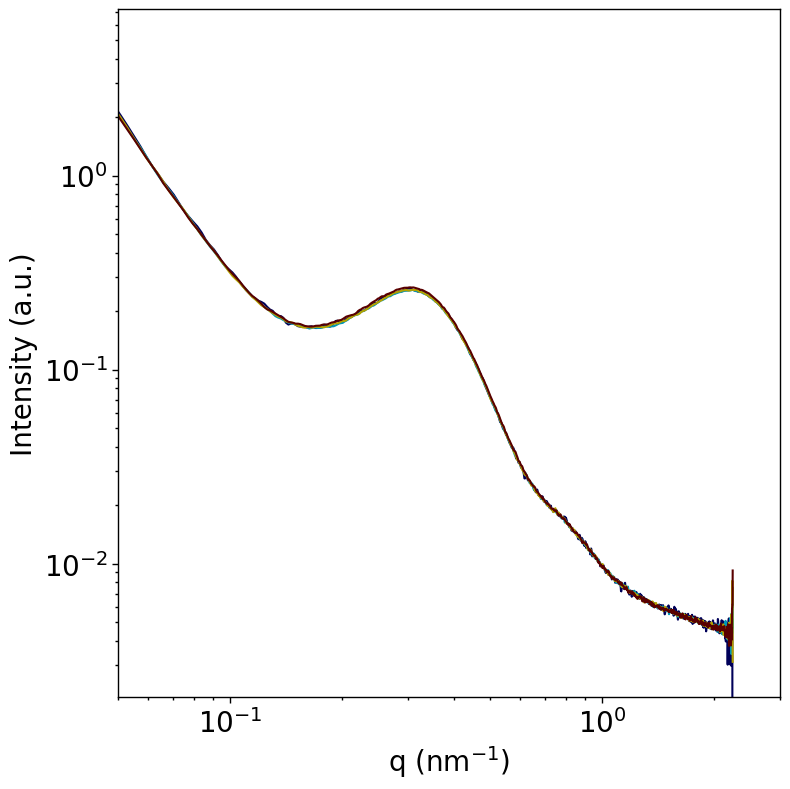

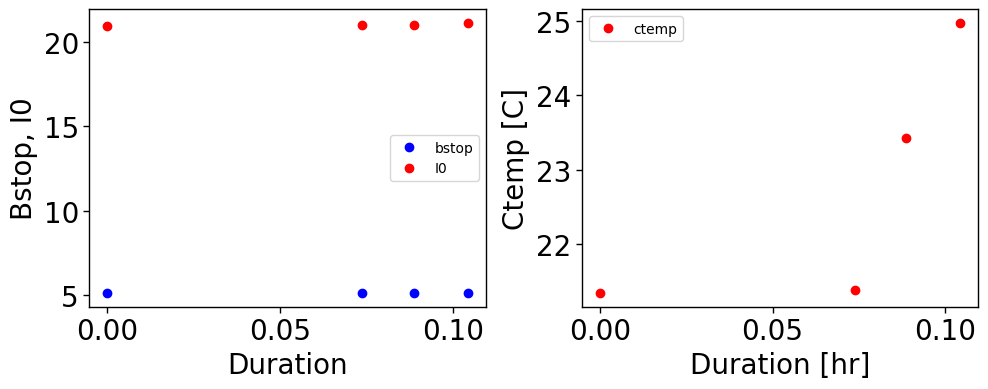

Processing WAXS data...
i0:20.963, bstop: 5.10255, transmission factor: 0.24340743214234603, thickness: 0.012037819940331238, normfactor: 106.96475565
i0:21.034063333333332, bstop: 5.111533333333333, transmission factor: 0.2430121680404436, thickness: 0.012051665367944865, normfactor: 107.51631586377776
i0:21.012416666666667, bstop: 5.100546666666666, transmission factor: 0.2427396499688676, thickness: 0.012061224333329026, normfactor: 107.17481178777777
i0:21.160856666666668, bstop: 5.139686666666667, transmission factor: 0.2428865119984903, thickness: 0.01205607160275411, normfactor: 108.76017286491113


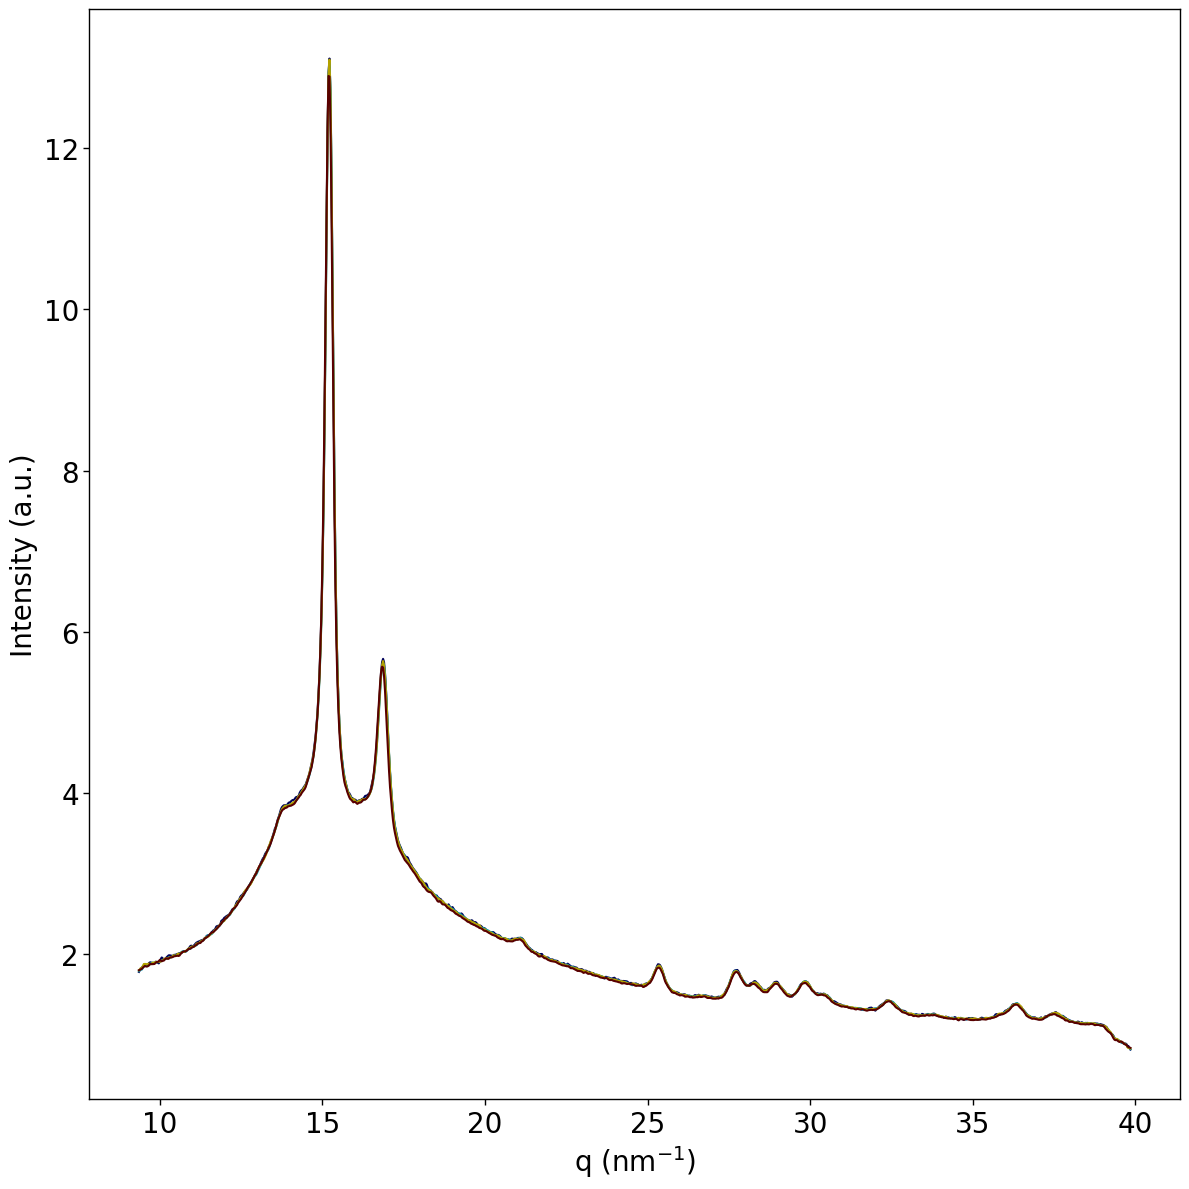

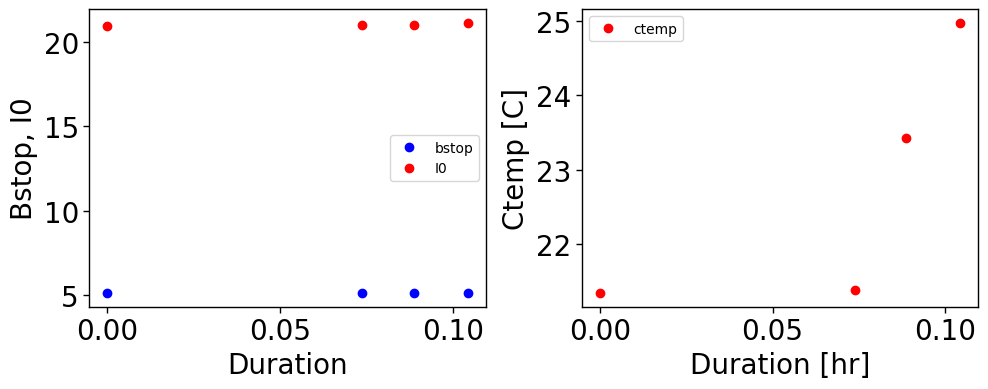

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:21.29209, bstop: 5.80243, transmission factor: 5.80243, thickness: -0.014979151727746935, normfactor: 123.54586177870002


i0:21.347040000000003, bstop: 5.80788, transmission factor: 5.80788, thickness: -0.01498714975149643, normfactor: 123.98104667520002
i0:21.283959999999997, bstop: 5.794906666666667, transmission factor: 5.794906666666667, thickness: -0.014968098679353958, normfactor: 123.33856169706665
i0:21.53027333333333, bstop: 5.855029999999999, transmission factor: 5.855029999999999, thickness: -0.015056031967409804, normfactor: 126.06039627486663
i0:21.438756666666666, bstop: 5.8398, transmission factor: 5.8398, thickness: -0.015033843045247956, normfactor: 125.198051182
i0:21.396843333333333, bstop: 5.824090000000001, transmission factor: 5.824090000000001, thickness: -0.015010894085543956, normfactor: 124.61714128923334


i0:21.3305, bstop: 5.814243333333334, transmission factor: 5.814243333333334, thickness: -0.014996478625085234, normfactor: 124.02071742166667
i0:21.28066, bstop: 5.7994200000000005, transmission factor: 5.7994200000000005, thickness: -0.014974731249781409, normfactor: 123.41548521720001
i0:21.233073333333333, bstop: 5.78809, transmission factor: 5.78809, thickness: -0.01495807144541378, normfactor: 122.89893942993334
i0:21.43492, bstop: 5.851913333333333, transmission factor: 5.851913333333333, thickness: -0.015051495927978399, normfactor: 125.43529414693334
i0:21.427033333333338, bstop: 5.840003333333333, transmission factor: 5.840003333333333, thickness: -0.015034139667017336, normfactor: 125.13394609011112


i0:21.378666666666664, bstop: 5.827570000000001, transmission factor: 5.827570000000001, thickness: -0.015015982956340879, normfactor: 124.58567650666666
i0:21.266143333333332, bstop: 5.805463333333333, transmission factor: 5.805463333333333, thickness: -0.014983604153743255, normfactor: 123.45981536307777
i0:21.275876666666665, bstop: 5.804503333333333, transmission factor: 5.804503333333333, thickness: -0.014982195285979558, normfactor: 123.49589703125554
i0:21.49834, bstop: 5.859473333333334, transmission factor: 5.859473333333334, thickness: -0.015062494682437371, normfactor: 125.96894994093334


i0:21.346703333333334, bstop: 5.833853333333334, transmission factor: 5.833853333333334, thickness: -0.015025163503194513, normfactor: 124.53353639684445
i0:21.304713333333332, bstop: 5.827466666666666, transmission factor: 5.827466666666666, thickness: -0.015015831893806723, normfactor: 124.15250679288887
i0:21.265416666666667, bstop: 5.813856666666666, transmission factor: 5.813856666666666, thickness: -0.014995912049380512, normfactor: 123.63408445694444
i0:21.221826666666665, bstop: 5.81313, transmission factor: 5.81313, thickness: -0.014994847175840114, normfactor: 123.36523725079999
i0:21.44496, bstop: 5.86515, transmission factor: 5.86515, thickness: -0.015070744123017812, normfactor: 125.77790714399998


i0:21.402833333333334, bstop: 5.8502, transmission factor: 5.8502, thickness: -0.015049001289950027, normfactor: 125.21085556666667
i0:21.31161333333333, bstop: 5.832846666666666, transmission factor: 5.832846666666666, thickness: -0.015023693332945941, normfactor: 124.30737279262219
i0:21.260563333333334, bstop: 5.820596666666667, transmission factor: 5.820596666666667, thickness: -0.015005782658048302, normfactor: 123.74916406945556
i0:21.292913333333335, bstop: 5.824466666666667, transmission factor: 5.824466666666667, thickness: -0.015011445039166788, normfactor: 124.01986394622223
i0:21.417820000000003, bstop: 5.86076, transmission factor: 5.86076, thickness: -0.01506436519127603, normfactor: 125.52470274320001


i0:21.321340000000003, bstop: 5.828880000000001, transmission factor: 5.828880000000001, thickness: -0.015017897807241174, normfactor: 124.27953229920003
i0:21.266136666666664, bstop: 5.819063333333333, transmission factor: 5.819063333333333, thickness: -0.015003538123699749, normfactor: 123.74899611865554
i0:21.259796666666666, bstop: 5.823646666666666, transmission factor: 5.823646666666666, thickness: -0.015010245572353413, normfactor: 123.80954399184442
i0:21.360629999999997, bstop: 5.8609, transmission factor: 5.8609, thickness: -0.015064568693372013, normfactor: 125.19251636699998
i0:21.264273333333332, bstop: 5.827746666666667, transmission factor: 5.827746666666667, thickness: -0.01501624121833997, normfactor: 123.92279803742223


i0:21.209860000000003, bstop: 5.821206666666666, transmission factor: 5.821206666666666, thickness: -0.015006675427965738, normfactor: 123.46697843106666
i0:21.293789999999998, bstop: 5.84015, transmission factor: 5.84015, thickness: -0.015034353617292148, normfactor: 124.3589276685
i0:21.345646666666664, bstop: 5.850926666666666, transmission factor: 5.850926666666666, thickness: -0.015050059416300457, normfactor: 124.89181329924442
i0:21.197856666666667, bstop: 5.824776666666668, transmission factor: 5.824776666666668, thickness: -0.015011898452145941, normfactor: 123.47278089534447
i0:21.189999999999998, bstop: 5.8139, transmission factor: 5.8139, thickness: -0.014995975546808444, normfactor: 123.196541


i0:21.292646666666666, bstop: 5.849793333333333, transmission factor: 5.849793333333333, thickness: -0.01504840907013706, normfactor: 124.55758251968889
i0:21.287683333333334, bstop: 5.848043333333334, transmission factor: 5.848043333333334, thickness: -0.0150458601133683, normfactor: 124.49129459961112
i0:21.175203333333332, bstop: 5.819683333333334, transmission factor: 5.819683333333334, thickness: -0.015004445767500181, normfactor: 123.23297791894444
i0:21.112276666666666, bstop: 5.811986666666667, transmission factor: 5.811986666666667, thickness: -0.014993171440156973, normfactor: 122.70427048964444
i0:21.207043333333335, bstop: 5.83297, transmission factor: 5.83297, thickness: -0.015023873466780186, normfactor: 123.70004755203335


i0:21.32701333333333, bstop: 5.854536666666667, transmission factor: 5.854536666666667, thickness: -0.015055314124180688, normfactor: 124.85978155048888
i0:21.18214, bstop: 5.821313333333333, transmission factor: 5.821313333333333, thickness: -0.015006831531128376, normfactor: 123.30787401053334
i0:21.133556666666667, bstop: 5.813446666666667, transmission factor: 5.813446666666667, thickness: -0.01499531124259996, normfactor: 122.85880455864445
i0:21.05238, bstop: 5.800156666666666, transmission factor: 5.800156666666666, thickness: -0.014975813328487636, normfactor: 122.10710220619998
i0:21.29574666666667, bstop: 5.85189, transmission factor: 5.85189, thickness: -0.015051461959214706, normfactor: 124.62036696120002


i0:21.13599333333333, bstop: 5.819636666666667, transmission factor: 5.819636666666667, thickness: -0.015004377453590137, normfactor: 123.00380178908888
i0:21.136346666666668, bstop: 5.814803333333334, transmission factor: 5.814803333333334, thickness: -0.014997299116204938, normfactor: 122.90369905182224
i0:21.029846666666668, bstop: 5.802173333333333, transmission factor: 5.802173333333333, thickness: -0.014978774877207371, normfactor: 122.01881553342223
i0:21.197233333333333, bstop: 5.853903333333334, transmission factor: 5.853903333333334, thickness: -0.015054392480005079, normfactor: 124.08655486744446
i0:21.126260000000002, bstop: 5.841360000000001, transmission factor: 5.841360000000001, thickness: -0.015036118502071648, normfactor: 123.40609011360003


i0:21.097036666666668, bstop: 5.833286666666667, transmission factor: 5.833286666666667, thickness: -0.015024335955127215, normfactor: 123.06506269384445
i0:20.99148, bstop: 5.808723333333333, transmission factor: 5.808723333333333, thickness: -0.014988386695610067, normfactor: 121.93369967719998
i0:21.149593333333332, bstop: 5.850363333333334, transmission factor: 5.850363333333334, thickness: -0.015049239137139854, normfactor: 123.73280535224445
i0:21.02038333333333, bstop: 5.81982, transmission factor: 5.81982, thickness: -0.015004645826514144, normfactor: 122.33484733099999
i0:21.146373333333333, bstop: 5.859033333333333, transmission factor: 5.859033333333333, thickness: -0.015061854932317077, normfactor: 123.89730623911109


i0:21.05145333333333, bstop: 5.827743333333333, transmission factor: 5.827743333333333, thickness: -0.01501623634554453, normfactor: 122.68246682031109
i0:21.159193333333334, bstop: 5.86336, transmission factor: 5.86336, thickness: -0.015068143722985067, normfactor: 124.06396782293334
i0:20.992036666666667, bstop: 5.831626666666668, transmission factor: 5.831626666666668, thickness: -0.015021911263317578, normfactor: 122.4177208129778


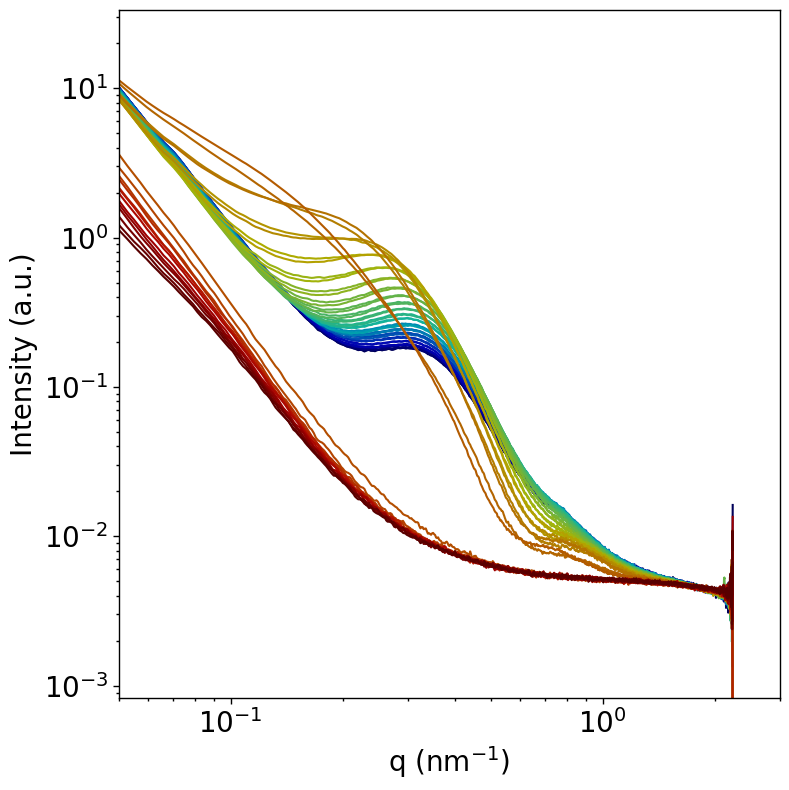

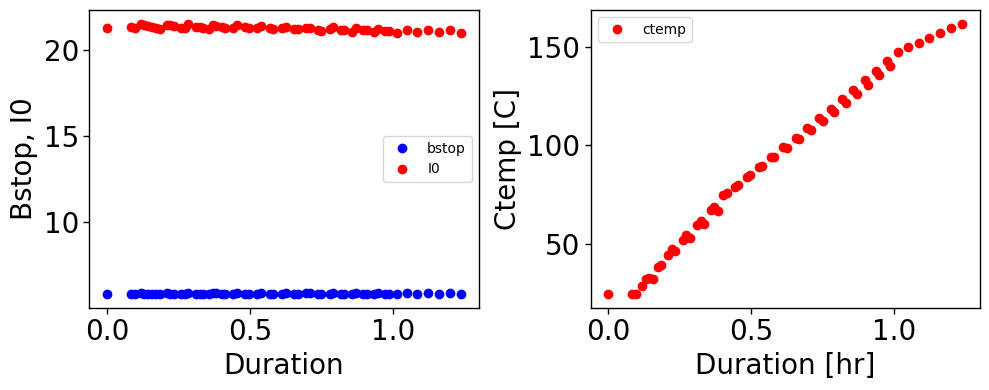

Processing WAXS data...
i0:21.29209, bstop: 5.80243, transmission factor: 0.27251575585111654, thickness: 0.011075490943551404, normfactor: 123.54586177870002
i0:21.347040000000003, bstop: 5.80788, transmission factor: 0.27206957030108153, thickness: 0.011089450757633132, normfactor: 123.98104667520002
i0:21.283959999999997, bstop: 5.794906666666667, transmission factor: 0.2722663764951009, thickness: 0.011083290459404814, normfactor: 123.33856169706665
i0:21.53027333333333, bstop: 5.855029999999999, transmission factor: 0.2719440626392419, thickness: 0.01109338164350068, normfactor: 126.06039627486663
i0:21.438756666666666, bstop: 5.8398, transmission factor: 0.272394527854305, thickness: 0.011079281543068035, normfactor: 125.198051182
i0:21.396843333333333, bstop: 5.824090000000001, transmission factor: 0.27219388903628, thickness: 0.01108555889606832, normfactor: 124.61714128923334


i0:21.3305, bstop: 5.814243333333334, transmission factor: 0.27257885812959537, thickness: 0.011073518506631718, normfactor: 124.02071742166667
i0:21.28066, bstop: 5.7994200000000005, transmission factor: 0.2725206830991144, thickness: 0.011075336912296294, normfactor: 123.41548521720001
i0:21.233073333333333, bstop: 5.78809, transmission factor: 0.27259784342728216, thickness: 0.01107292515779588, normfactor: 122.89893942993334
i0:21.43492, bstop: 5.851913333333333, transmission factor: 0.2730084055985902, thickness: 0.011060103929048225, normfactor: 125.43529414693334
i0:21.427033333333338, bstop: 5.840003333333333, transmission factor: 0.27255305214129805, thickness: 0.0110743250892565, normfactor: 125.13394609011112
i0:21.378666666666664, bstop: 5.827570000000001, transmission factor: 0.2725880940501435, thickness: 0.011073229850599222, normfactor: 124.58567650666666
i0:21.266143333333332, bstop: 5.805463333333333, transmission factor: 0.2729908870798231, thickness: 0.0110606506116

i0:21.265416666666667, bstop: 5.813856666666666, transmission factor: 0.2733949095754061, thickness: 0.01104805160820219, normfactor: 123.63408445694444
i0:21.221826666666665, bstop: 5.81313, transmission factor: 0.2739222259849451, thickness: 0.011031635797088782, normfactor: 123.36523725079999
i0:21.44496, bstop: 5.86515, transmission factor: 0.2734978288604875, thickness: 0.011044845157406034, normfactor: 125.77790714399998
i0:21.402833333333334, bstop: 5.8502, transmission factor: 0.27333764221247964, thickness: 0.01104983629588162, normfactor: 125.21085556666667
i0:21.31161333333333, bstop: 5.832846666666666, transmission factor: 0.2736933415333486, thickness: 0.011038757281075586, normfactor: 124.30737279262219
i0:21.260563333333334, bstop: 5.820596666666667, transmission factor: 0.27377433868560086, thickness: 0.01103623646454331, normfactor: 123.74916406945556
i0:21.292913333333335, bstop: 5.824466666666667, transmission factor: 0.273540148099352, thickness: 0.01104352705138905

i0:21.293789999999998, bstop: 5.84015, transmission factor: 0.27426540789591713, thickness: 0.011020969217418717, normfactor: 124.3589276685
i0:21.345646666666664, bstop: 5.850926666666666, transmission factor: 0.2741039781101346, thickness: 0.011025985020208517, normfactor: 124.89181329924442
i0:21.197856666666667, bstop: 5.824776666666668, transmission factor: 0.27478139692424886, thickness: 0.011004956641660952, normfactor: 123.47278089534447
i0:21.189999999999998, bstop: 5.8139, transmission factor: 0.27436998584237854, thickness: 0.01101772143995228, normfactor: 123.196541
i0:21.292646666666666, bstop: 5.849793333333333, transmission factor: 0.2747330299004633, thickness: 0.011006456327317123, normfactor: 124.55758251968889
i0:21.287683333333334, bstop: 5.848043333333334, transmission factor: 0.27471487816507356, thickness: 0.011007019214809855, normfactor: 124.49129459961112
i0:21.175203333333332, bstop: 5.819683333333334, transmission factor: 0.27483482645817964, thickness: 0.01

i0:21.13599333333333, bstop: 5.819636666666667, transmission factor: 0.2753424726666896, thickness: 0.010987578988489625, normfactor: 123.00380178908888
i0:21.136346666666668, bstop: 5.814803333333334, transmission factor: 0.2751091957865945, thickness: 0.010994799741713749, normfactor: 122.90369905182224
i0:21.029846666666668, bstop: 5.802173333333333, transmission factor: 0.27590183729347206, thickness: 0.01097028954560513, normfactor: 122.01881553342223
i0:21.197233333333333, bstop: 5.853903333333334, transmission factor: 0.276163555935759, thickness: 0.010962212098209889, normfactor: 124.08655486744446
i0:21.126260000000002, bstop: 5.841360000000001, transmission factor: 0.276497591149593, thickness: 0.010951913850307186, normfactor: 123.40609011360003
i0:21.097036666666668, bstop: 5.833286666666667, transmission factor: 0.2764979157420371, thickness: 0.01095190384923011, normfactor: 123.06506269384445
i0:20.99148, bstop: 5.808723333333333, transmission factor: 0.2767181415190036, 

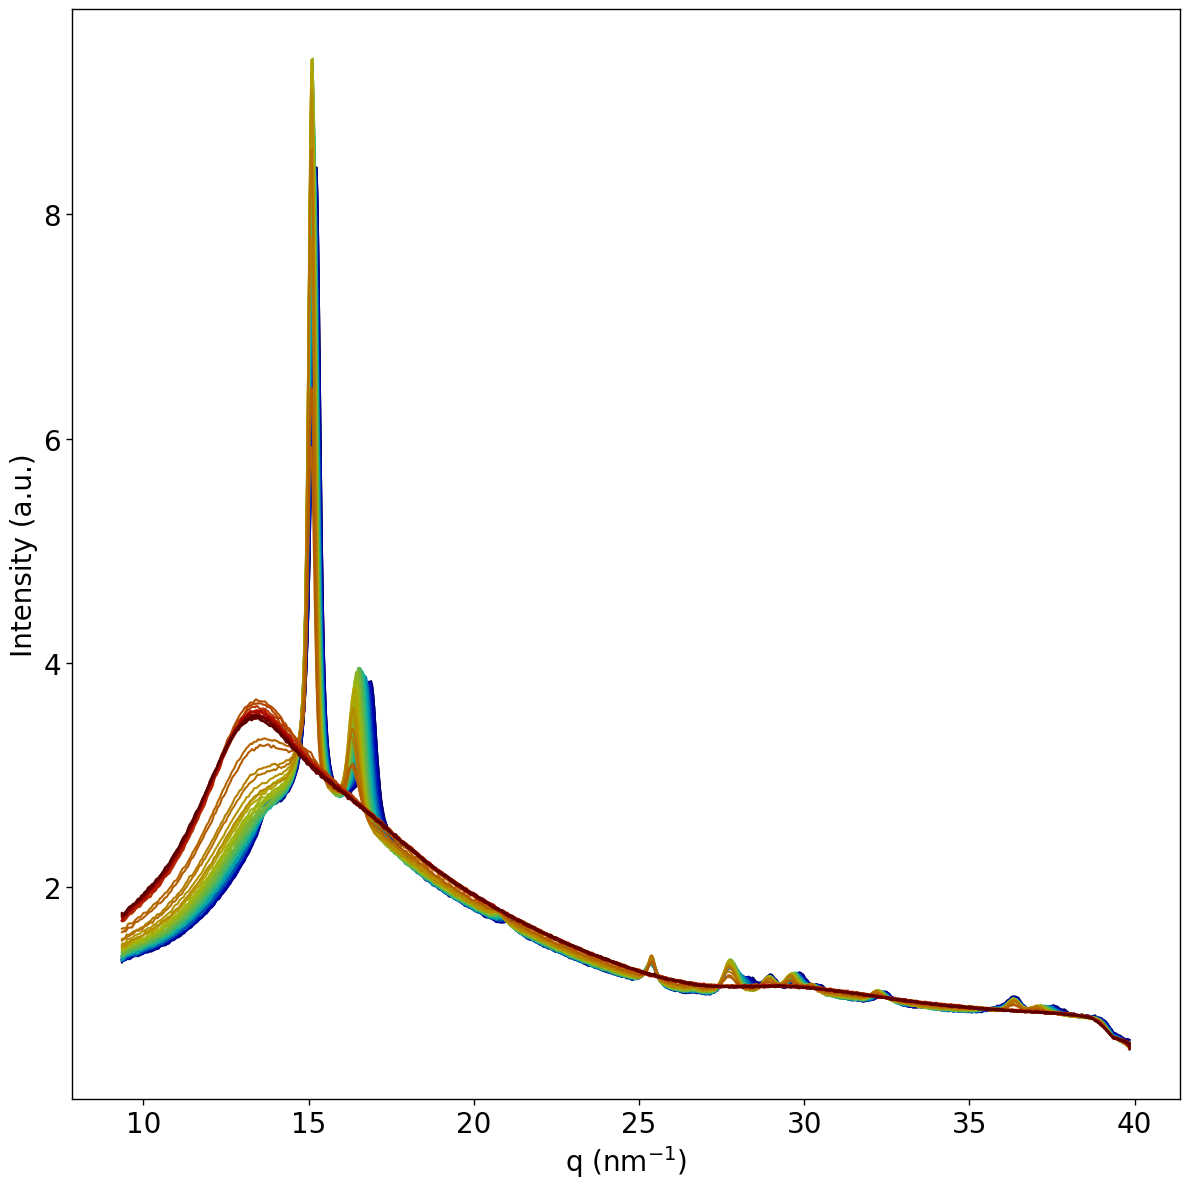

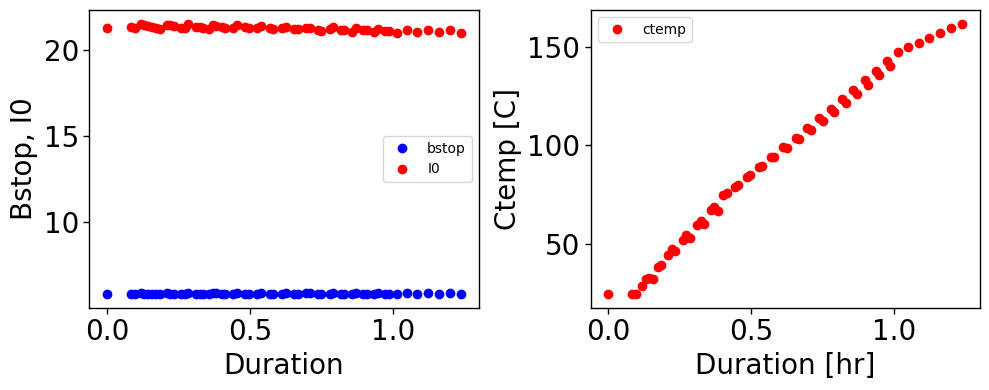

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:21.04121, bstop: 4.45634, transmission factor: 4.45634, thickness: -0.012730511445403846, normfactor: 93.7667857714


i0:21.27725333333333, bstop: 4.499536666666667, transmission factor: 4.499536666666667, thickness: -0.012812693211442402, normfactor: 95.73778153928887
i0:21.193836666666666, bstop: 4.48916, transmission factor: 4.48916, thickness: -0.012793023802718996, normfactor: 95.14252381053333
i0:21.192326666666663, bstop: 4.476323333333333, transmission factor: 4.476323333333333, thickness: -0.012768628353250214, normfactor: 94.8637063456222
i0:21.06884333333333, bstop: 4.465003333333333, transmission factor: 4.465003333333333, thickness: -0.012747057135245144, normfactor: 94.07245571281108
i0:21.023506666666666, bstop: 4.4589533333333335, transmission factor: 4.4589533333333335, thickness: -0.012735505912477331, normfactor: 93.74283512968888


i0:21.27558, bstop: 4.502483333333333, transmission factor: 4.502483333333333, thickness: -0.012818270473143083, normfactor: 95.79294435700001
i0:21.201773333333332, bstop: 4.49233, transmission factor: 4.49233, thickness: -0.012799037490277072, normfactor: 95.24536239853333
i0:21.1027, bstop: 4.48036, transmission factor: 4.48036, thickness: -0.012776307370955585, normfactor: 94.547692972
i0:21.00780333333333, bstop: 4.467663333333333, transmission factor: 4.467663333333333, thickness: -0.01275213090192858, normfactor: 93.8557926662111
i0:21.23734, bstop: 4.510913333333334, transmission factor: 4.510913333333334, thickness: -0.012834206101326122, normfactor: 95.79980017053335


i0:21.157, bstop: 4.49488, transmission factor: 4.49488, thickness: -0.012803871920243917, normfactor: 95.09817616000001
i0:21.08565666666667, bstop: 4.4844566666666665, transmission factor: 4.4844566666666665, thickness: -0.012784093457322869, normfactor: 94.55771360987778
i0:20.97548, bstop: 4.460719999999999, transmission factor: 4.460719999999999, thickness: -0.012738880616134096, normfactor: 93.5657431456
i0:21.172046666666667, bstop: 4.50465, transmission factor: 4.50465, thickness: -0.012822369072707578, normfactor: 95.372660017
i0:21.117523333333335, bstop: 4.491716666666666, transmission factor: 4.491716666666666, thickness: -0.01279787428988267, normfactor: 94.85393151505555


i0:20.995743333333333, bstop: 4.47785, transmission factor: 4.47785, thickness: -0.012771533370404898, normfactor: 94.01578928516668
i0:21.152693333333332, bstop: 4.518483333333333, transmission factor: 4.518483333333333, thickness: -0.012848490672916543, normfactor: 95.57809228177777
i0:7.242273333333333, bstop: 1.85325, transmission factor: 1.85325, thickness: -0.005255856581839439, normfactor: 13.421743055


i0:20.98375, bstop: 4.48102, transmission factor: 4.48102, thickness: -0.012777562241755563, normfactor: 94.028603425
i0:21.149323333333335, bstop: 4.514473333333334, transmission factor: 4.514473333333334, thickness: -0.012840926796137032, normfactor: 95.4780562063778
i0:21.156566666666667, bstop: 4.522706666666667, transmission factor: 4.522706666666667, thickness: -0.012856449696044357, normfactor: 95.68494510711112
i0:21.041443333333333, bstop: 4.50086, transmission factor: 4.50086, thickness: -0.012815198383598079, normfactor: 94.70459064126668
i0:20.97695, bstop: 4.4886333333333335, transmission factor: 4.4886333333333335, thickness: -0.012792024271876054, normfactor: 94.15783700166666


i0:21.21479666666667, bstop: 4.5429466666666665, transmission factor: 4.5429466666666665, thickness: -0.012894489834843691, normfactor: 96.37768980084445
i0:21.08801, bstop: 4.5192000000000005, transmission factor: 4.5192000000000005, thickness: -0.012849841780889621, normfactor: 95.30093479200002
i0:21.006196666666668, bstop: 4.5052433333333335, transmission factor: 4.5052433333333335, thickness: -0.01282349111459411, normfactor: 94.6380274911889
i0:20.934859999999997, bstop: 4.4962133333333325, transmission factor: 4.4962133333333325, thickness: -0.012806398634931083, normfactor: 94.12759666346663
i0:21.10289333333333, bstop: 4.535833333333334, transmission factor: 4.535833333333334, thickness: -0.012881140005070653, normfactor: 95.71920701111111


i0:20.993370000000002, bstop: 4.5214, transmission factor: 4.5214, thickness: -0.01285398803013973, normfactor: 94.91942311800001
i0:20.915270000000003, bstop: 4.510703333333333, transmission factor: 4.510703333333333, thickness: -0.012833809490197504, normfactor: 94.34257810656668
i0:21.12174333333333, bstop: 4.551893333333333, transmission factor: 4.551893333333333, thickness: -0.012911250695079613, normfactor: 96.14392266737777
i0:21.00607666666667, bstop: 4.538743333333334, transmission factor: 4.538743333333334, thickness: -0.012886603827802951, normfactor: 95.34119043032224
i0:20.923986666666668, bstop: 4.52497, transmission factor: 4.52497, thickness: -0.012860711970660025, normfactor: 94.68041194706666


i0:20.980306666666667, bstop: 4.552746666666667, transmission factor: 4.552746666666667, thickness: -0.012912847625170925, normfactor: 95.51802124231112
i0:21.00406, bstop: 4.558466666666667, transmission factor: 4.558466666666667, thickness: -0.012923544325801013, normfactor: 95.74630737466667
i0:20.898823333333336, bstop: 4.53934, transmission factor: 4.53934, thickness: -0.012887723697731265, normfactor: 94.86686470993335
i0:20.838693333333335, bstop: 4.5159899999999995, transmission factor: 4.5159899999999995, thickness: -0.012843788403755687, normfactor: 94.10733070639999
i0:21.00261, bstop: 4.552323333333334, transmission factor: 4.552323333333334, thickness: -0.012912055435549246, normfactor: 95.61067156390001


i0:20.94739, bstop: 4.533196666666666, transmission factor: 4.533196666666666, thickness: -0.0128761863658475, normfactor: 94.95863852336664
i0:20.855416666666667, bstop: 4.515023333333333, transmission factor: 4.515023333333333, thickness: -0.012841964633063625, normfactor: 94.16269287638887
i0:21.039396666666665, bstop: 4.561303333333334, transmission factor: 4.561303333333334, thickness: -0.012928844063856774, normfactor: 95.96707014698889
i0:20.909573333333334, bstop: 4.54076, transmission factor: 4.54076, thickness: -0.0128903882711271, normfactor: 94.94535420906666
i0:20.832516666666667, bstop: 4.509603333333334, transmission factor: 4.509603333333334, thickness: -0.012831731701614389, normfactor: 93.94638660172222


i0:21.046563333333335, bstop: 4.534120000000001, transmission factor: 4.534120000000001, thickness: -0.0128779214066943, normfactor: 95.42764374093335
i0:20.922963333333332, bstop: 4.538726666666666, transmission factor: 4.538726666666666, thickness: -0.012886572544406512, normfactor: 94.96361162668887
i0:20.84808, bstop: 4.53848, transmission factor: 4.53848, thickness: -0.012886109536707484, normfactor: 94.6185941184
i0:21.010256666666667, bstop: 4.58231, transmission factor: 4.58231, thickness: -0.012967988498671893, normfactor: 96.27550922623332


i0:20.937473333333333, bstop: 4.57566, transmission factor: 4.57566, thickness: -0.012955616140727442, normfactor: 95.8027592324
i0:20.838913333333334, bstop: 4.55837, transmission factor: 4.55837, thickness: -0.012923363665578868, normfactor: 94.99147737126667
i0:20.95727666666667, bstop: 4.598496666666667, transmission factor: 4.598496666666667, thickness: -0.012998028987985457, normfactor: 96.37196689407779
i0:20.85127, bstop: 4.591516666666666, transmission factor: 4.591516666666666, thickness: -0.012985087943336285, normfactor: 95.73895372616666
i0:20.775503333333333, bstop: 4.573286666666667, transmission factor: 4.573286666666667, thickness: -0.012951196188007788, normfactor: 95.01233238762224


i0:20.92663333333333, bstop: 4.621903333333333, transmission factor: 4.621903333333333, thickness: -0.013041282433869348, normfactor: 96.72087635877776
i0:20.84051666666667, bstop: 4.60995, transmission factor: 4.60995, thickness: -0.013019221172092985, normfactor: 96.07373980750002
i0:20.718186666666668, bstop: 4.60219, transmission factor: 4.60219, thickness: -0.013004868549486952, normfactor: 95.34903149546668
i0:20.88226, bstop: 4.656586666666667, transmission factor: 4.656586666666667, thickness: -0.013104973060175185, normfactor: 97.24005348586667
i0:20.735780000000002, bstop: 4.651223333333333, transmission factor: 4.651223333333333, thickness: -0.013095155189684637, normfactor: 96.44674377086668


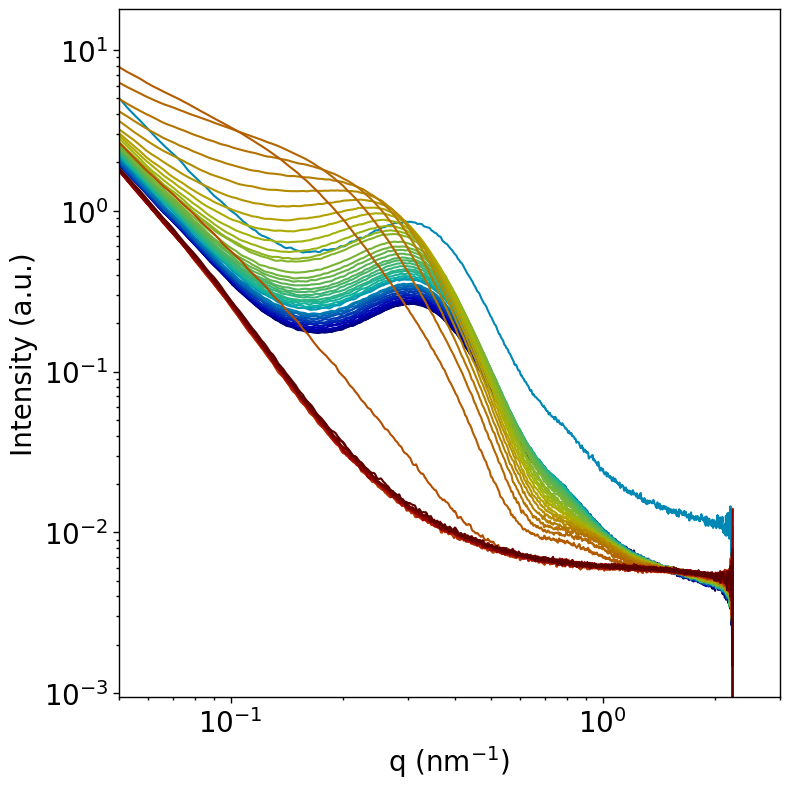

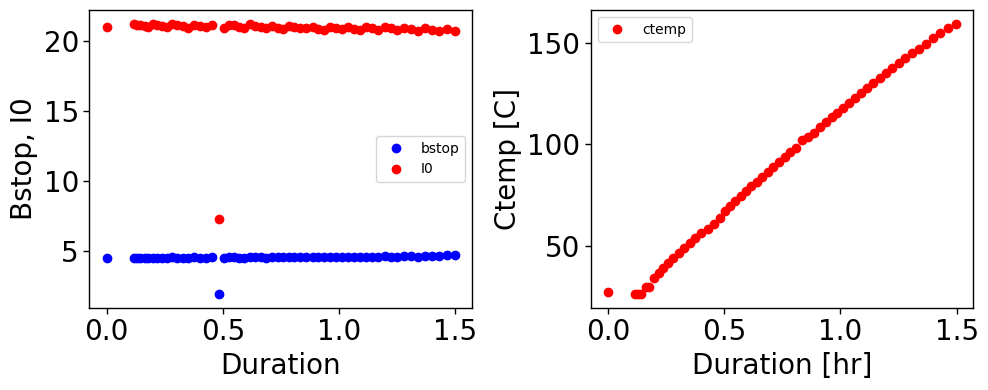

Processing WAXS data...
i0:21.04121, bstop: 4.45634, transmission factor: 0.211791051940454, thickness: 0.013223155037742323, normfactor: 93.7667857714
i0:21.27725333333333, bstop: 4.499536666666667, transmission factor: 0.21147168744837996, thickness: 0.01323601106081748, normfactor: 95.73778153928887
i0:21.193836666666666, bstop: 4.48916, transmission factor: 0.2118144095665548, thickness: 0.013222215537010435, normfactor: 95.14252381053333
i0:21.192326666666663, bstop: 4.476323333333333, transmission factor: 0.21122377942456533, thickness: 0.013246003994697412, normfactor: 94.8637063456222
i0:21.06884333333333, bstop: 4.465003333333333, transmission factor: 0.21192446413368998, thickness: 0.01321779026732375, normfactor: 94.07245571281108


i0:21.023506666666666, bstop: 4.4589533333333335, transmission factor: 0.21209370082885, thickness: 0.013210989779494406, normfactor: 93.74283512968888
i0:21.27558, bstop: 4.502483333333333, transmission factor: 0.2116268197310406, thickness: 0.013229763785002959, normfactor: 95.79294435700001
i0:21.201773333333332, bstop: 4.49233, transmission factor: 0.21188463480727715, thickness: 0.01321939153028258, normfactor: 95.24536239853333
i0:21.1027, bstop: 4.48036, transmission factor: 0.2123121685850626, thickness: 0.013202219044762044, normfactor: 94.547692972
i0:21.00780333333333, bstop: 4.467663333333333, transmission factor: 0.2126668487154218, thickness: 0.013187999049775967, normfactor: 93.8557926662111
i0:21.23734, bstop: 4.510913333333334, transmission factor: 0.2124048178036107, thickness: 0.013198502219812771, normfactor: 95.79980017053335
i0:21.157, bstop: 4.49488, transmission factor: 0.21245356146901737, thickness: 0.013196547412437991, normfactor: 95.09817616000001
i0:21.085

i0:21.152693333333332, bstop: 4.518483333333333, transmission factor: 0.21361267154631847, thickness: 0.013150194331293219, normfactor: 95.57809228177777
i0:7.242273333333333, bstop: 1.85325, transmission factor: 0.2558934073186964, thickness: 0.011611652079538348, normfactor: 13.421743055
i0:20.98375, bstop: 4.48102, transmission factor: 0.21354714958003215, thickness: 0.013152807855339848, normfactor: 94.028603425
i0:21.149323333333335, bstop: 4.514473333333334, transmission factor: 0.21345710508941423, thickness: 0.013156400836340102, normfactor: 95.4780562063778
i0:21.156566666666667, bstop: 4.522706666666667, transmission factor: 0.21377318626053063, thickness: 0.013143795145877473, normfactor: 95.68494510711112
i0:21.041443333333333, bstop: 4.50086, transmission factor: 0.2139045277787503, thickness: 0.01313856257166385, normfactor: 94.70459064126668
i0:20.97695, bstop: 4.4886333333333335, transmission factor: 0.21397931221332622, thickness: 0.013135584636039529, normfactor: 94.1

i0:20.915270000000003, bstop: 4.510703333333333, transmission factor: 0.21566555599489426, thickness: 0.013068712848385863, normfactor: 94.34257810656668
i0:21.12174333333333, bstop: 4.551893333333333, transmission factor: 0.21550746363581416, thickness: 0.013074960104247451, normfactor: 96.14392266737777
i0:21.00607666666667, bstop: 4.538743333333334, transmission factor: 0.2160681123541553, thickness: 0.013052825885884646, normfactor: 95.34119043032224
i0:20.923986666666668, bstop: 4.52497, transmission factor: 0.21625754556652363, thickness: 0.013045360107197899, normfactor: 94.68041194706666
i0:20.980306666666667, bstop: 4.552746666666667, transmission factor: 0.21700095899456187, thickness: 0.013016124393370248, normfactor: 95.51802124231112
i0:21.00406, bstop: 4.558466666666667, transmission factor: 0.21702788254588243, thickness: 0.01301506746945155, normfactor: 95.74630737466667
i0:20.898823333333336, bstop: 4.53934, transmission factor: 0.21720553007210772, thickness: 0.013008

i0:21.039396666666665, bstop: 4.561303333333334, transmission factor: 0.21679820032862163, thickness: 0.013024088200280982, normfactor: 95.96707014698889
i0:20.909573333333334, bstop: 4.54076, transmission factor: 0.21716177215157584, thickness: 0.013009813381047557, normfactor: 94.94535420906666
i0:20.832516666666667, bstop: 4.509603333333334, transmission factor: 0.21646944560226763, thickness: 0.01303701663062879, normfactor: 93.94638660172222
i0:21.046563333333335, bstop: 4.534120000000001, transmission factor: 0.2154327967083779, thickness: 0.013077912273046725, normfactor: 95.42764374093335
i0:20.922963333333332, bstop: 4.538726666666666, transmission factor: 0.21692561394665416, thickness: 0.013019082872038986, normfactor: 94.96361162668887
i0:20.84808, bstop: 4.53848, transmission factor: 0.21769294822352944, thickness: 0.012989000869048388, normfactor: 94.6185941184
i0:21.010256666666667, bstop: 4.58231, transmission factor: 0.21809871591287872, thickness: 0.012973136286837132

i0:20.84051666666667, bstop: 4.60995, transmission factor: 0.22120132978149135, thickness: 0.012852798041947042, normfactor: 96.07373980750002
i0:20.718186666666668, bstop: 4.60219, transmission factor: 0.22213285718698675, thickness: 0.012816997052963875, normfactor: 95.34903149546668
i0:20.88226, bstop: 4.656586666666667, transmission factor: 0.22299246665191733, thickness: 0.012784092999894843, normfactor: 97.24005348586667
i0:20.735780000000002, bstop: 4.651223333333333, transmission factor: 0.22430906063496683, thickness: 0.012733941640422066, normfactor: 96.44674377086668


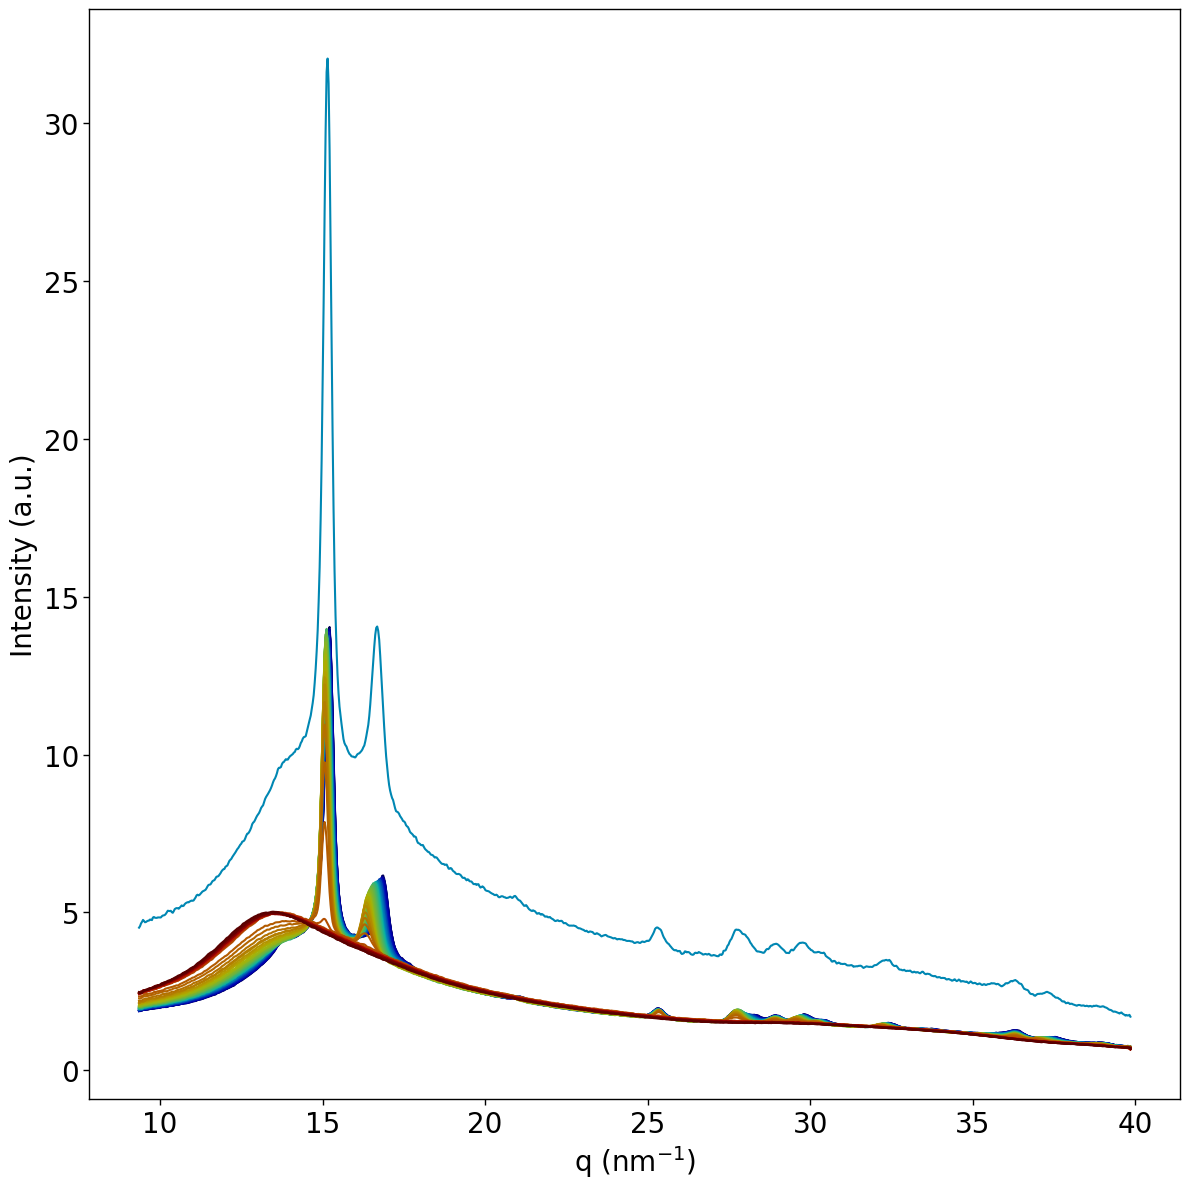

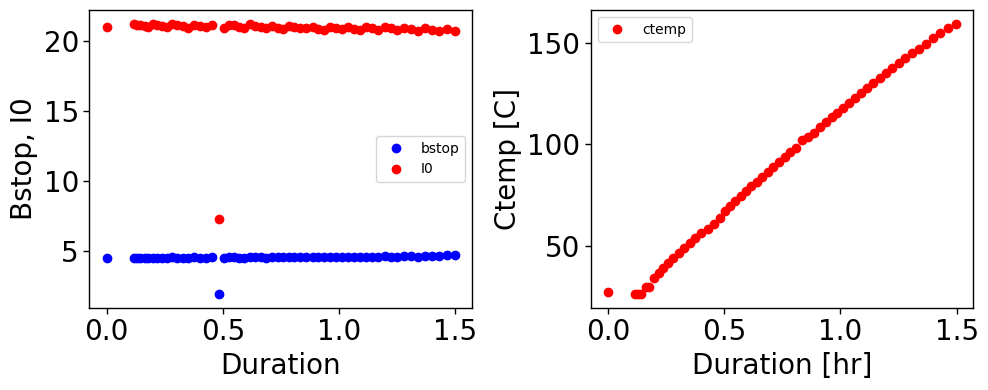

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:21.06958, bstop: 6.10217, transmission factor: 6.10217, thickness: -0.015408244961511641, normfactor: 128.57015898859999


i0:20.976656666666667, bstop: 6.112303333333333, transmission factor: 6.112303333333333, thickness: -0.015422380346905197, normfactor: 128.21568846585555
i0:20.9714, bstop: 6.105003333333333, transmission factor: 6.105003333333333, thickness: -0.015412199652356132, normfactor: 128.03046690466667
i0:20.85784, bstop: 6.082703333333334, transmission factor: 6.082703333333334, thickness: -0.015381024159674885, normfactor: 126.87205289413335


i0:20.971663333333336, bstop: 6.117249999999999, transmission factor: 6.117249999999999, thickness: -0.015429272137062983, normfactor: 128.28890752583334
i0:21.03764, bstop: 6.135423333333333, transmission factor: 6.135423333333333, thickness: -0.015454543812008843, normfactor: 129.07482733426664
i0:21.00874333333333, bstop: 6.122036666666666, transmission factor: 6.122036666666666, thickness: -0.015435935708706506, normfactor: 128.61629700725553
i0:20.935386666666666, bstop: 6.105323333333334, transmission factor: 6.105323333333334, thickness: -0.015412646184437466, normfactor: 127.81730470835556
i0:20.892516666666666, bstop: 6.097713333333334, transmission factor: 6.097713333333334, thickness: -0.015402020748240151, normfactor: 127.39657744522223


i0:21.076883333333335, bstop: 6.149440000000001, transmission factor: 6.149440000000001, thickness: -0.01547398418420329, normfactor: 129.61102944533337
i0:21.052503333333334, bstop: 6.14104, transmission factor: 6.14104, thickness: -0.015462339157728856, normfactor: 129.28426507013333
i0:20.974663333333332, bstop: 6.1225, transmission factor: 6.1225, thickness: -0.015436580443578434, normfactor: 128.41737625833332
i0:20.95266666666667, bstop: 6.114033333333334, transmission factor: 6.114033333333334, thickness: -0.015424791249845143, normfactor: 128.10530242222225
i0:20.872153333333333, bstop: 6.098033333333333, transmission factor: 6.098033333333333, thickness: -0.015402467814150032, normfactor: 127.27908676511112


i0:21.115859999999998, bstop: 6.158873333333333, transmission factor: 6.158873333333333, thickness: -0.015487042786431007, normfactor: 130.04990706439997
i0:21.046533333333333, bstop: 6.149746666666668, transmission factor: 6.149746666666668, thickness: -0.015474409019068193, normfactor: 129.43084821155557
i0:20.97945, bstop: 6.132446666666667, transmission factor: 6.132446666666667, thickness: -0.01545040961642773, normfactor: 128.655358221
i0:20.88702333333333, bstop: 6.115553333333334, transmission factor: 6.115553333333334, thickness: -0.01542690893690109, normfactor: 127.73570516957777


i0:20.857853333333335, bstop: 6.108123333333334, transmission factor: 6.108123333333334, thickness: -0.015416552342109752, normfactor: 127.4023406285778
i0:20.835113333333336, bstop: 6.107896666666666, transmission factor: 6.107896666666666, thickness: -0.015416236195962267, normfactor: 127.2587192782889
i0:20.99341, bstop: 6.141256666666666, transmission factor: 6.141256666666666, thickness: -0.015462639725554653, normfactor: 128.92591911856667
i0:20.91987333333333, bstop: 6.118473333333333, transmission factor: 6.118473333333333, thickness: -0.015430975648813175, normfactor: 127.9976871267111
i0:20.815436666666667, bstop: 6.098956666666666, transmission factor: 6.098956666666666, thickness: -0.015403757654082934, normfactor: 126.95244622774443


i0:20.8267, bstop: 6.111483333333333, transmission factor: 6.111483333333333, thickness: -0.015421237368402655, normfactor: 127.28202993833332
i0:20.986966666666664, bstop: 6.153363333333334, transmission factor: 6.153363333333334, thickness: -0.015479417702228904, normfactor: 129.14043116455557
i0:20.86742333333333, bstop: 6.132556666666667, transmission factor: 6.132556666666667, thickness: -0.01545056242755714, normfactor: 127.97065607898888
i0:20.794539999999998, bstop: 6.108846666666667, transmission factor: 6.108846666666667, thickness: -0.015417561141806866, normfactor: 127.03065636386667
i0:20.979803333333333, bstop: 6.167433333333332, transmission factor: 6.167433333333332, thickness: -0.015498875131786192, normfactor: 129.39153840477775


i0:20.914023333333333, bstop: 6.1397466666666665, transmission factor: 6.1397466666666665, thickness: -0.015460544778405307, normfactor: 128.4068050474222
i0:20.818369999999998, bstop: 6.117173333333334, transmission factor: 6.117173333333334, thickness: -0.015429165366127352, normfactor: 127.34957780746666
i0:20.888923333333334, bstop: 6.144593333333333, transmission factor: 6.144593333333333, thickness: -0.015467267131452293, normfactor: 128.3539390545111
i0:20.86594, bstop: 6.14671, transmission factor: 6.14671, thickness: -0.015470201296295987, normfactor: 128.2568820574


i0:20.769343333333335, bstop: 6.1228066666666665, transmission factor: 6.1228066666666665, thickness: -0.015437007147739318, normfactor: 127.16667382362223
i0:20.687223333333336, bstop: 6.10043, transmission factor: 6.10043, thickness: -0.015405815405886264, normfactor: 126.20095783936668
i0:20.91862666666667, bstop: 6.15647, transmission factor: 6.15647, thickness: -0.01548371774192575, normfactor: 128.78489751453333
i0:20.803906666666666, bstop: 6.1324700000000005, transmission factor: 6.1324700000000005, thickness: -0.015450442031138774, normfactor: 127.57933351613335
i0:20.685306666666666, bstop: 6.110936666666667, transmission factor: 6.110936666666667, thickness: -0.015420475297532458, normfactor: 126.40659897057779


i0:20.900183333333334, bstop: 6.169316666666667, transmission factor: 6.169316666666667, thickness: -0.015501476227919243, normfactor: 128.93984937472223
i0:20.786133333333332, bstop: 6.1406133333333335, transmission factor: 6.1406133333333335, thickness: -0.015461747239313832, normfactor: 127.63960749511111
i0:20.671086666666664, bstop: 6.122013333333334, transmission factor: 6.122013333333334, thickness: -0.015435903238753369, normfactor: 126.54866818782223
i0:20.888769999999997, bstop: 6.17621, transmission factor: 6.17621, thickness: -0.015510989932769585, normfactor: 129.0134301617
i0:20.760413333333332, bstop: 6.14483, transmission factor: 6.14483, thickness: -0.01546759525361123, normfactor: 127.56921066306666


i0:20.71171, bstop: 6.123916666666667, transmission factor: 6.123916666666667, thickness: -0.015438551452620545, normfactor: 126.83678606416667
i0:20.79493666666667, bstop: 6.163243333333334, transmission factor: 6.163243333333334, thickness: -0.015493085417922842, normfactor: 128.16425477792225
i0:20.81347, bstop: 6.167856666666666, transmission factor: 6.167856666666666, thickness: -0.015499459872149516, normfactor: 128.37449969596665
i0:20.681963333333332, bstop: 6.14783, transmission factor: 6.14783, thickness: -0.015471753453520191, normfactor: 127.14919463956666


i0:20.71077, bstop: 6.159216666666666, transmission factor: 6.159216666666666, thickness: -0.015487517686866886, normfactor: 127.56211976349998
i0:20.758926666666664, bstop: 6.179289999999999, transmission factor: 6.179289999999999, thickness: -0.015515237305470797, normfactor: 128.27542796206663
i0:20.65442, bstop: 6.161026666666667, transmission factor: 6.161026666666667, thickness: -0.015490020850631591, normfactor: 127.25243240453334
i0:20.660513333333338, bstop: 6.165726666666667, transmission factor: 6.165726666666667, thickness: -0.015496517346168104, normfactor: 127.3870780063556


i0:20.74721333333333, bstop: 6.1889166666666675, transmission factor: 6.1889166666666675, thickness: -0.015528499007305291, normfactor: 128.40277438555555
i0:20.620563333333333, bstop: 6.158243333333334, transmission factor: 6.158243333333334, thickness: -0.01548617129832204, normfactor: 126.9864466770778
i0:20.71992, bstop: 6.190086666666667, transmission factor: 6.190086666666667, thickness: -0.01553010939392746, normfactor: 128.2581005264
i0:20.67104, bstop: 6.173729999999999, transmission factor: 6.173729999999999, thickness: -0.015507568430676842, normfactor: 127.61741977919999
i0:20.545576666666665, bstop: 6.144783333333334, transmission factor: 6.144783333333334, thickness: -0.0154675305544675, normfactor: 126.24811707505556


i0:20.714883333333333, bstop: 6.192453333333333, transmission factor: 6.192453333333333, thickness: -0.015533365940778768, normfactor: 128.2759483471111
i0:20.582736666666666, bstop: 6.160863333333334, transmission factor: 6.160863333333334, thickness: -0.015489794996796816, normfactor: 126.80742762932223
i0:20.51071333333333, bstop: 6.145283333333334, transmission factor: 6.145283333333334, thickness: -0.015468223734009603, normfactor: 126.04414480211112


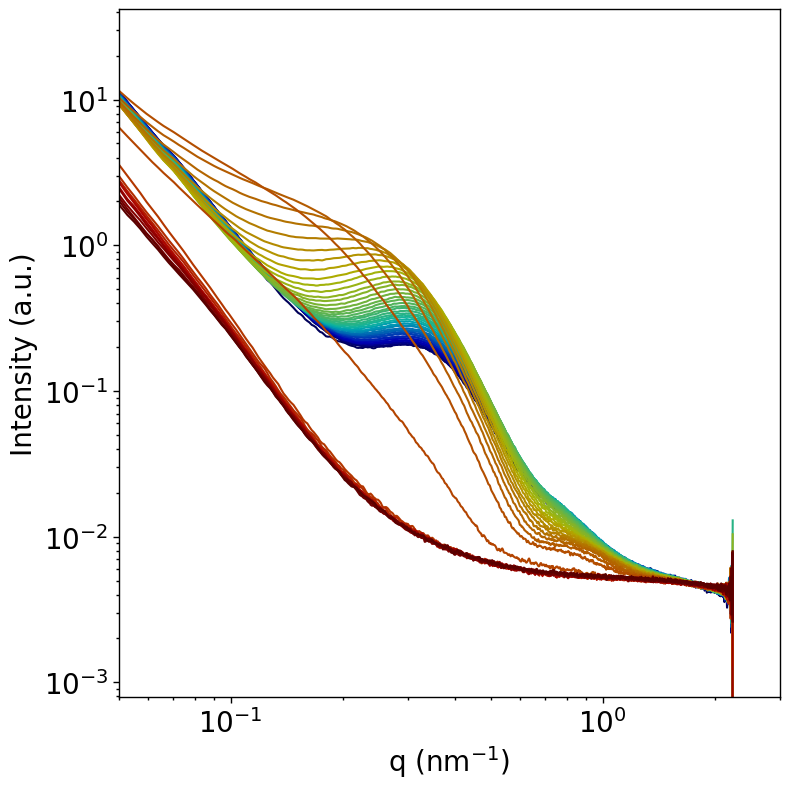

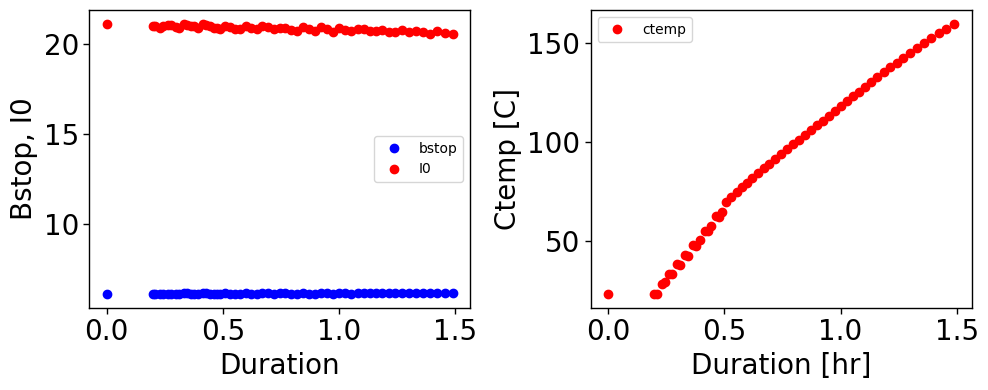

Processing WAXS data...
i0:21.06958, bstop: 6.10217, transmission factor: 0.2896199164862328, thickness: 0.010556900308274482, normfactor: 128.57015898859999
i0:20.976656666666667, bstop: 6.112303333333333, transmission factor: 0.2913859644299846, thickness: 0.010505109430751324, normfactor: 128.21568846585555
i0:20.9714, bstop: 6.105003333333333, transmission factor: 0.2911109097787145, thickness: 0.01051315497443978, normfactor: 128.03046690466667
i0:20.85784, bstop: 6.082703333333334, transmission factor: 0.2916267136641826, thickness: 0.010498073575258598, normfactor: 126.87205289413335
i0:20.971663333333336, bstop: 6.117249999999999, transmission factor: 0.2916912169897825, thickness: 0.010496189463098904, normfactor: 128.28890752583334


i0:21.03764, bstop: 6.135423333333333, transmission factor: 0.2916402853805528, thickness: 0.010497677117116886, normfactor: 129.07482733426664
i0:21.00874333333333, bstop: 6.122036666666666, transmission factor: 0.2914042296358199, thickness: 0.01050457542946145, normfactor: 128.61629700725553
i0:20.935386666666666, bstop: 6.105323333333334, transmission factor: 0.29162696780061065, thickness: 0.010498066151233974, normfactor: 127.81730470835556
i0:20.892516666666666, bstop: 6.097713333333334, transmission factor: 0.29186112092766875, thickness: 0.010491228641438711, normfactor: 127.39657744522223
i0:21.076883333333335, bstop: 6.149440000000001, transmission factor: 0.291762301984876, thickness: 0.010494113585954295, normfactor: 129.61102944533337
i0:21.052503333333334, bstop: 6.14104, transmission factor: 0.29170117694633624, thickness: 0.010495898574531802, normfactor: 129.28426507013333
i0:20.974663333333332, bstop: 6.1225, transmission factor: 0.29189979847113956, thickness: 0.010

i0:20.835113333333336, bstop: 6.107896666666666, transmission factor: 0.2931539929228446, thickness: 0.010453573947660468, normfactor: 127.2587192782889
i0:20.99341, bstop: 6.141256666666666, transmission factor: 0.2925325931645533, thickness: 0.010471651346352032, normfactor: 128.92591911856667
i0:20.91987333333333, bstop: 6.118473333333333, transmission factor: 0.2924718154762569, thickness: 0.01047342151649382, normfactor: 127.9976871267111
i0:20.815436666666667, bstop: 6.098956666666666, transmission factor: 0.29300162011174075, thickness: 0.01045800313992182, normfactor: 126.95244622774443
i0:20.8267, bstop: 6.111483333333333, transmission factor: 0.2934446327710743, thickness: 0.010445131971461142, normfactor: 127.28202993833332
i0:20.986966666666664, bstop: 6.153363333333334, transmission factor: 0.29319927129377127, thickness: 0.010452258233897683, normfactor: 129.14043116455557
i0:20.86742333333333, bstop: 6.132556666666667, transmission factor: 0.29388183527530237, thickness:

i0:20.687223333333336, bstop: 6.10043, transmission factor: 0.2948887775659276, thickness: 0.010403308693276025, normfactor: 126.20095783936668
i0:20.91862666666667, bstop: 6.15647, transmission factor: 0.29430564912801793, thickness: 0.010420171726830532, normfactor: 128.78489751453333
i0:20.803906666666666, bstop: 6.1324700000000005, transmission factor: 0.2947749236842055, thickness: 0.010406598523030577, normfactor: 127.57933351613335
i0:20.685306666666666, bstop: 6.110936666666667, transmission factor: 0.2954240304551122, thickness: 0.010387859460956711, normfactor: 126.40659897057779
i0:20.900183333333334, bstop: 6.169316666666667, transmission factor: 0.2951800263315075, thickness: 0.01039489878140341, normfactor: 128.93984937472223
i0:20.786133333333332, bstop: 6.1406133333333335, transmission factor: 0.29541874069892754, thickness: 0.0103880120044542, normfactor: 127.63960749511111
i0:20.671086666666664, bstop: 6.122013333333334, transmission factor: 0.296163110921761, thickne

i0:20.81347, bstop: 6.167856666666666, transmission factor: 0.29633966208742063, thickness: 0.010361495977751694, normfactor: 128.37449969596665
i0:20.681963333333332, bstop: 6.14783, transmission factor: 0.29725562805207567, thickness: 0.010335204245203834, normfactor: 127.14919463956666
i0:20.71077, bstop: 6.159216666666666, transmission factor: 0.2973919688484139, thickness: 0.010331297670471598, normfactor: 127.56211976349998
i0:20.758926666666664, bstop: 6.179289999999999, transmission factor: 0.2976690509689165, thickness: 0.010323363948030313, normfactor: 128.27542796206663
i0:20.65442, bstop: 6.161026666666667, transmission factor: 0.29829095499494385, thickness: 0.010305583758704025, normfactor: 127.25243240453334
i0:20.660513333333338, bstop: 6.165726666666667, transmission factor: 0.2984304681684256, thickness: 0.010301600178490173, normfactor: 127.3870780063556
i0:20.74721333333333, bstop: 6.1889166666666675, transmission factor: 0.29830110517653463, thickness: 0.0103052938

i0:20.51071333333333, bstop: 6.145283333333334, transmission factor: 0.2996133402803804, thickness: 0.010267899757082196, normfactor: 126.04414480211112


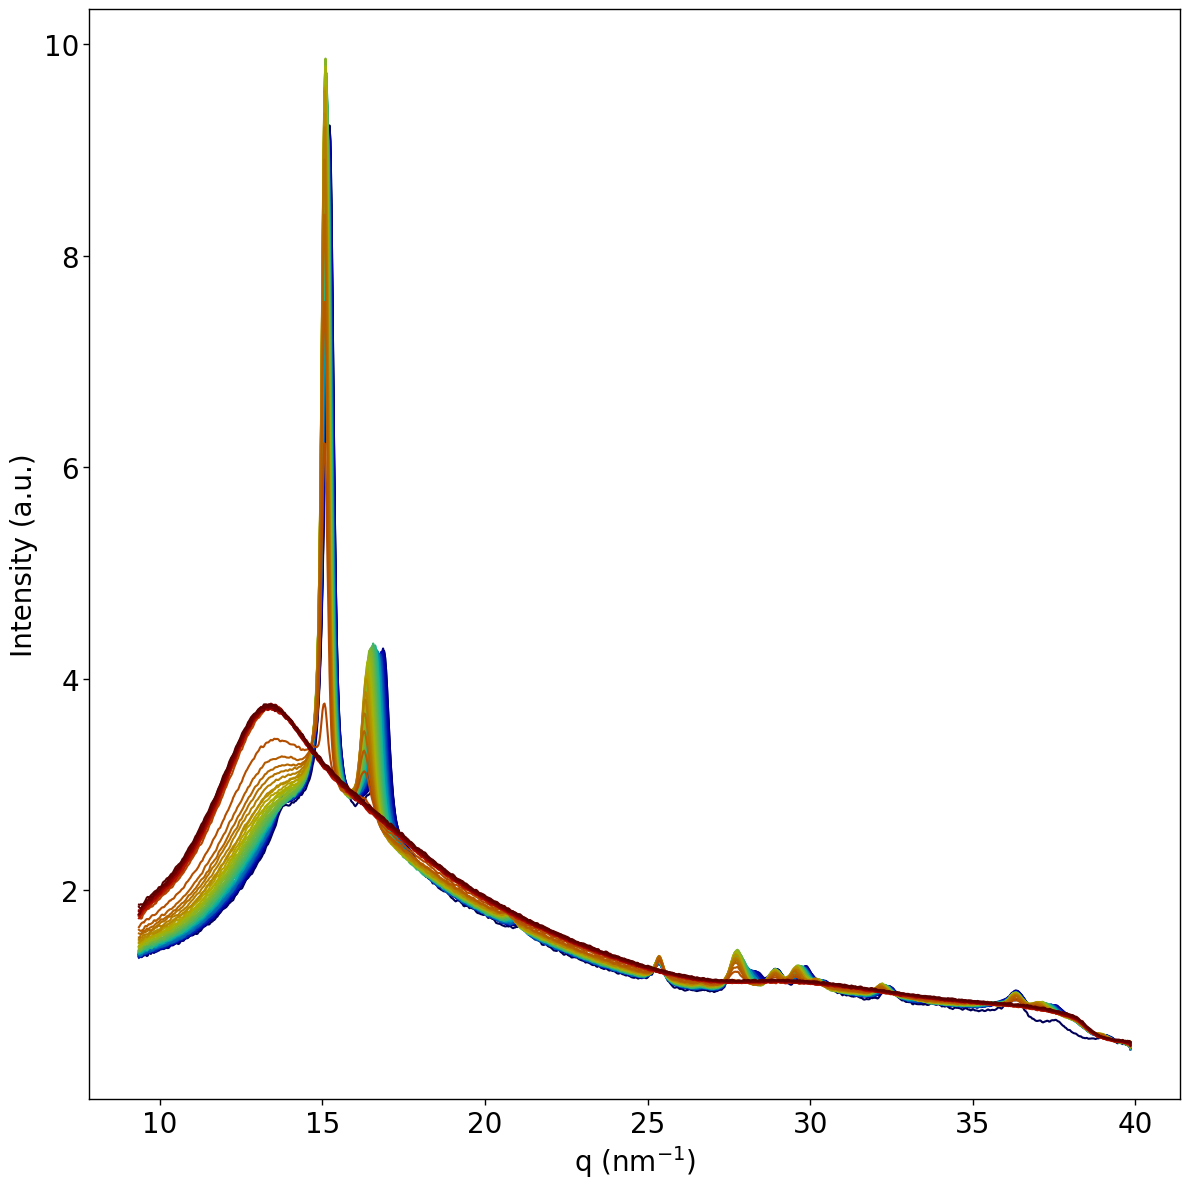

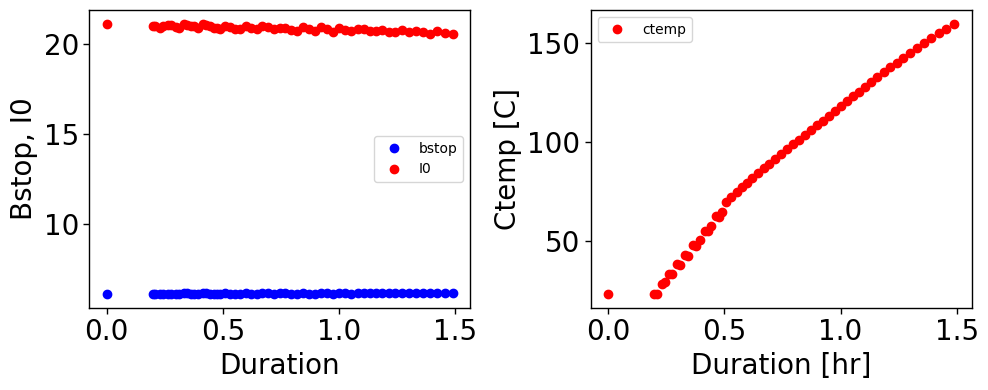

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:20.72388, bstop: 4.72151, transmission factor: 4.72151, thickness: -0.013222929868704488, normfactor: 97.84800665880002


i0:20.770956666666667, bstop: 4.74753, transmission factor: 4.74753, thickness: -0.01326974997605886, normfactor: 98.61073990370001
i0:20.72266, bstop: 4.737283333333333, transmission factor: 4.737283333333333, thickness: -0.013251342935883207, normfactor: 98.16911184033333
i0:20.68992, bstop: 4.723153333333333, transmission factor: 4.723153333333333, thickness: -0.013225894489552288, normfactor: 97.7216646144
i0:20.617606666666667, bstop: 4.7158066666666665, transmission factor: 4.7158066666666665, thickness: -0.013212632879658806, normfactor: 97.22864696937778
i0:20.57220666666667, bstop: 4.7029, transmission factor: 4.7029, thickness: -0.013189284697919709, normfactor: 96.74903073266667


i0:20.86673, bstop: 4.756923333333333, transmission factor: 4.756923333333333, thickness: -0.013286589224473998, normfactor: 99.26143482736666
i0:20.762676666666668, bstop: 4.747656666666667, transmission factor: 4.747656666666667, thickness: -0.01326997727049551, normfactor: 98.57406029434445
i0:20.676893333333336, bstop: 4.733536666666667, transmission factor: 4.733536666666667, thickness: -0.013244602507983693, normfactor: 97.8748327460889
i0:20.68601, bstop: 4.72463, transmission factor: 4.72463, thickness: -0.013228557559176825, normfactor: 97.73374342630001
i0:20.54928666666667, bstop: 4.714276666666667, transmission factor: 4.714276666666667, thickness: -0.013209868447891548, normfactor: 96.87502264931113


i0:20.818753333333333, bstop: 4.76238, transmission factor: 4.76238, thickness: -0.013296356024087703, normfactor: 99.14681449960001
i0:20.744533333333333, bstop: 4.753076666666666, transmission factor: 4.753076666666666, thickness: -0.013279697402795826, normfactor: 98.60035734755554
i0:20.728189999999998, bstop: 4.747753333333333, transmission factor: 4.747753333333333, thickness: -0.013270150727959429, normfactor: 98.41233316646665
i0:20.64191, bstop: 4.74007, transmission factor: 4.74007, thickness: -0.013256352822925557, normfactor: 97.8440983337


i0:20.57406333333333, bstop: 4.723019999999999, transmission factor: 4.723019999999999, thickness: -0.013225653990816846, normfactor: 97.17171260459997
i0:20.781859999999998, bstop: 4.769909999999999, transmission factor: 4.769909999999999, thickness: -0.013309815488890911, normfactor: 99.12760183259998
i0:20.777676666666668, bstop: 4.762383333333333, transmission factor: 4.762383333333333, thickness: -0.013296361986946467, normfactor: 98.95126106272222
i0:20.67854, bstop: 4.75411, transmission factor: 4.75411, thickness: -0.013281549306458952, normfactor: 98.3080537994
i0:20.70311, bstop: 4.741376666666667, transmission factor: 4.741376666666667, thickness: -0.013258700942341071, normfactor: 98.16124268143332


i0:20.59455, bstop: 4.736606666666667, transmission factor: 4.736606666666667, thickness: -0.013250125975565803, normfactor: 97.54828282700001
i0:20.735463333333332, bstop: 4.767446666666667, transmission factor: 4.767446666666667, thickness: -0.013305414754673376, normfactor: 98.85521555028889
i0:20.74261, bstop: 4.766303333333334, transmission factor: 4.766303333333334, thickness: -0.013303371422002642, normfactor: 98.86557118503335
i0:20.64334666666667, bstop: 4.7461899999999995, transmission factor: 4.7461899999999995, thickness: -0.013267345068688388, normfactor: 97.97724551586667
i0:20.58277, bstop: 4.7237, transmission factor: 4.7237, thickness: -0.013226880463391497, normfactor: 97.22683064900001


i0:20.807506666666665, bstop: 4.767316666666667, transmission factor: 4.767316666666667, thickness: -0.013305182447080054, normfactor: 99.19597332377778
i0:20.696056666666667, bstop: 4.754133333333333, transmission factor: 4.754133333333333, thickness: -0.013281591118991064, normfactor: 98.39181286755554
i0:20.592646666666667, bstop: 4.736093333333334, transmission factor: 4.736093333333334, thickness: -0.013249202648313557, normfactor: 97.52869659368889
i0:20.72781, bstop: 4.75943, transmission factor: 4.75943, thickness: -0.013291077257129707, normfactor: 98.6525607483


i0:20.742733333333334, bstop: 4.76652, transmission factor: 4.76652, thickness: -0.01330375868011874, normfactor: 98.870653288
i0:20.643243333333334, bstop: 4.756443333333333, transmission factor: 4.756443333333333, thickness: -0.013285729544177633, normfactor: 98.18841713121111
i0:20.544960000000003, bstop: 4.74429, transmission factor: 4.74429, thickness: -0.013263933961242263, normfactor: 97.47124827840003
i0:20.728256666666667, bstop: 4.792723333333333, transmission factor: 4.792723333333333, thickness: -0.013350463756152588, normfactor: 99.34479938565555
i0:20.617993333333335, bstop: 4.77618, transmission factor: 4.77618, thickness: -0.013321006570162898, normfactor: 98.47524739880001


i0:20.57265333333333, bstop: 4.756936666666667, transmission factor: 4.756936666666667, thickness: -0.013286613103243933, normfactor: 97.86280897195556
i0:20.770476666666667, bstop: 4.804939999999999, transmission factor: 4.804939999999999, thickness: -0.013372151651956569, normfactor: 99.80089415473333
i0:20.639993333333333, bstop: 4.780333333333334, transmission factor: 4.780333333333334, thickness: -0.013328411608577758, normfactor: 98.66604813111113
i0:20.551703333333336, bstop: 4.758523333333334, transmission factor: 4.758523333333334, thickness: -0.01328945419908916, normfactor: 97.79575985141113
i0:20.783936666666666, bstop: 4.7871966666666665, transmission factor: 4.7871966666666665, thickness: -0.013340634256577293, normfactor: 99.49679233087777


i0:20.622429999999998, bstop: 4.770983333333334, transmission factor: 4.770983333333334, thickness: -0.013311732283367623, normfactor: 98.38926982283333
i0:20.55863, bstop: 4.747326666666667, transmission factor: 4.747326666666667, thickness: -0.013269385095992464, normfactor: 97.59853242913334
i0:20.725943333333333, bstop: 4.77681, transmission factor: 4.77681, thickness: -0.013322130220529742, normfactor: 99.0038933741
i0:20.6503, bstop: 4.756029999999999, transmission factor: 4.756029999999999, thickness: -0.013284989194401551, normfactor: 98.21344630899999
i0:20.572893333333333, bstop: 4.733086666666666, transmission factor: 4.733086666666666, thickness: -0.013243792578166321, normfactor: 97.37328713075554


i0:20.576539999999998, bstop: 4.744236666666667, transmission factor: 4.744236666666667, thickness: -0.01326383819114766, normfactor: 97.61997554113333
i0:20.645936666666667, bstop: 4.776023333333334, transmission factor: 4.776023333333334, thickness: -0.013320727120869572, normfactor: 98.60547525852223
i0:20.55224, bstop: 4.756293333333333, transmission factor: 4.756293333333333, thickness: -0.013285460876293334, normfactor: 97.75248209706666
i0:20.508996666666665, bstop: 4.743703333333333, transmission factor: 4.743703333333333, thickness: -0.013262880430983224, normfactor: 97.28859585098888


i0:20.642413333333334, bstop: 4.773219999999999, transmission factor: 4.773219999999999, thickness: -0.013315725212122502, normfactor: 98.53078017093333
i0:20.519343333333335, bstop: 4.754576666666666, transmission factor: 4.754576666666666, thickness: -0.013282385518112515, normfactor: 97.56079102798888
i0:20.496806666666668, bstop: 4.7593966666666665, transmission factor: 4.7593966666666665, thickness: -0.013291017591353115, normfactor: 97.55243332664445
i0:20.631236666666666, bstop: 4.787109999999999, transmission factor: 4.787109999999999, thickness: -0.013340480024492061, normfactor: 98.76399935936665
i0:20.506003333333336, bstop: 4.76737, transmission factor: 4.76737, thickness: -0.013305277753525696, normfactor: 97.75970511123334


i0:20.657776666666663, bstop: 4.803986666666667, transmission factor: 4.803986666666667, thickness: -0.013370461211523762, normfactor: 99.23968366964444
i0:20.557466666666667, bstop: 4.79098, transmission factor: 4.79098, thickness: -0.013347364360294189, normfactor: 98.49041165066667
i0:20.44184333333333, bstop: 4.7776266666666665, transmission factor: 4.7776266666666665, thickness: -0.013323586583794211, normfactor: 97.66349582515554
i0:20.627446666666668, bstop: 4.817723333333333, transmission factor: 4.817723333333333, thickness: -0.013394786576369106, normfactor: 99.3773311130889
i0:20.501206666666665, bstop: 4.797323333333333, transmission factor: 4.797323333333333, thickness: -0.013358636485473753, normfactor: 98.35091710348887


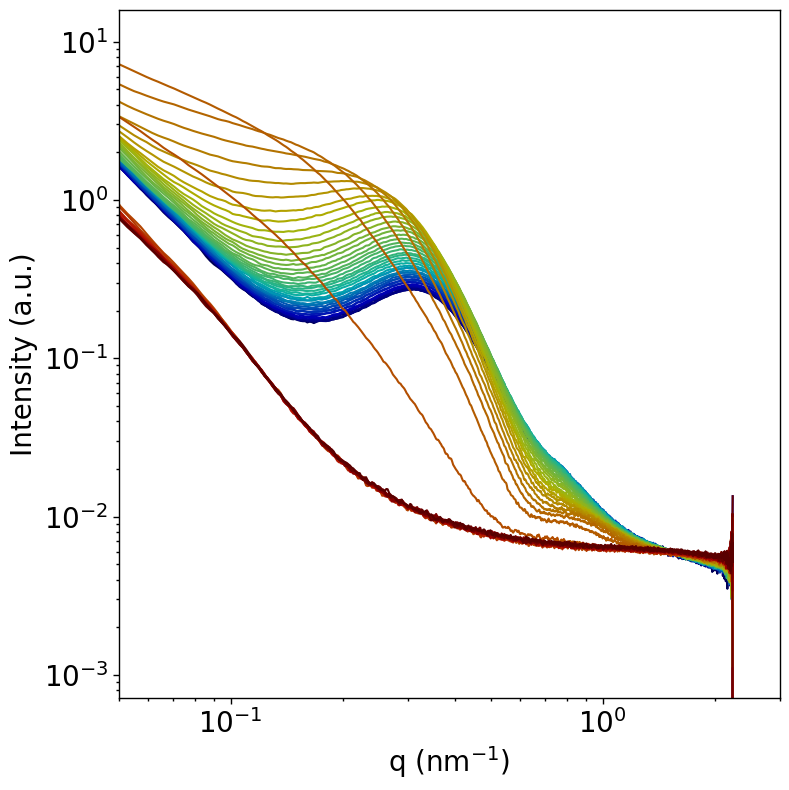

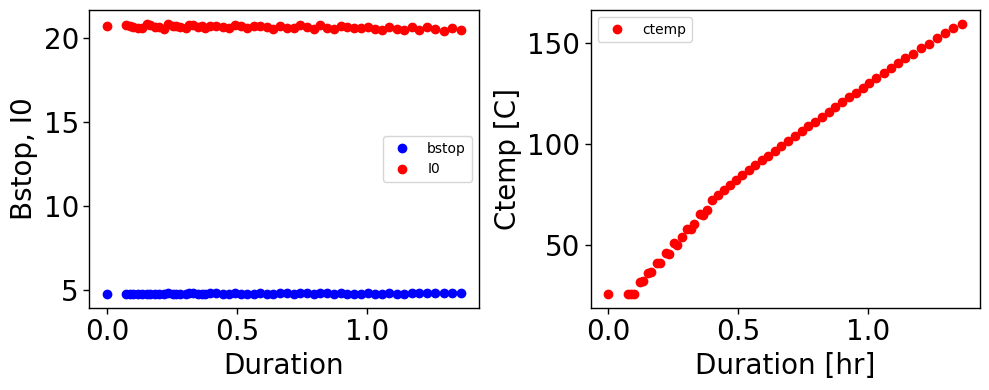

Processing WAXS data...
i0:20.72388, bstop: 4.72151, transmission factor: 0.22782944120502532, thickness: 0.012601276484545326, normfactor: 97.84800665880002
i0:20.770956666666667, bstop: 4.74753, transmission factor: 0.22856578424328716, thickness: 0.012573786819980792, normfactor: 98.61073990370001
i0:20.72266, bstop: 4.737283333333333, transmission factor: 0.228604017695283, thickness: 0.01257236188204934, normfactor: 98.16911184033333
i0:20.68992, bstop: 4.723153333333333, transmission factor: 0.2282828224243174, thickness: 0.012584340053796222, normfactor: 97.7216646144
i0:20.617606666666667, bstop: 4.7158066666666665, transmission factor: 0.2287271623185491, thickness: 0.012567773974856802, normfactor: 97.22864696937778
i0:20.57220666666667, bstop: 4.7029, transmission factor: 0.22860454768909894, thickness: 0.012572342131170937, normfactor: 96.74903073266667


i0:20.86673, bstop: 4.756923333333333, transmission factor: 0.2279668799727285, thickness: 0.012596138788334484, normfactor: 99.26143482736666
i0:20.762676666666668, bstop: 4.747656666666667, transmission factor: 0.22866303525733597, thickness: 0.012570162800534116, normfactor: 98.57406029434445
i0:20.676893333333336, bstop: 4.733536666666667, transmission factor: 0.2289288139352978, thickness: 0.01256026652276494, normfactor: 97.8748327460889
i0:20.68601, bstop: 4.72463, transmission factor: 0.22839735647425485, thickness: 0.012580066861514971, normfactor: 97.73374342630001
i0:20.54928666666667, bstop: 4.714276666666667, transmission factor: 0.22941315400080386, thickness: 0.012542261614885305, normfactor: 96.87502264931113
i0:20.818753333333333, bstop: 4.76238, transmission factor: 0.2287543314313089, thickness: 0.012566762088134556, normfactor: 99.14681449960001
i0:20.744533333333333, bstop: 4.753076666666666, transmission factor: 0.22912429941382145, thickness: 0.012552994944887569

i0:20.70311, bstop: 4.741376666666667, transmission factor: 0.2290176049234471, thickness: 0.012556962947555263, normfactor: 98.16124268143332
i0:20.59455, bstop: 4.736606666666667, transmission factor: 0.22999321017777355, thickness: 0.012520748502278887, normfactor: 97.54828282700001
i0:20.735463333333332, bstop: 4.767446666666667, transmission factor: 0.22991753741054582, thickness: 0.012523551973046058, normfactor: 98.85521555028889
i0:20.74261, bstop: 4.766303333333334, transmission factor: 0.22978320150325027, thickness: 0.01252853102771037, normfactor: 98.86557118503335
i0:20.64334666666667, bstop: 4.7461899999999995, transmission factor: 0.229913786588867, thickness: 0.012523690954815337, normfactor: 97.97724551586667
i0:20.58277, bstop: 4.7237, transmission factor: 0.22949777896755394, thickness: 0.012539119659003034, normfactor: 97.22683064900001
i0:20.807506666666665, bstop: 4.767316666666667, transmission factor: 0.22911522956779062, thickness: 0.012553332183532587, normfac

i0:20.728256666666667, bstop: 4.792723333333333, transmission factor: 0.23121690407474368, thickness: 0.012475541577873735, normfactor: 99.34479938565555
i0:20.617993333333335, bstop: 4.77618, transmission factor: 0.23165105947911516, thickness: 0.012459560054040792, normfactor: 98.47524739880001
i0:20.57265333333333, bstop: 4.756936666666667, transmission factor: 0.23122621032840365, thickness: 0.012475198694411034, normfactor: 97.86280897195556
i0:20.770476666666667, bstop: 4.804939999999999, transmission factor: 0.2313350857138088, thickness: 0.012471188269463874, normfactor: 99.80089415473333
i0:20.639993333333333, bstop: 4.780333333333334, transmission factor: 0.23160537196555947, thickness: 0.01246124042836945, normfactor: 98.66604813111113
i0:20.551703333333336, bstop: 4.758523333333334, transmission factor: 0.23153912141264527, thickness: 0.012463677694628566, normfactor: 97.79575985141113
i0:20.783936666666666, bstop: 4.7871966666666665, transmission factor: 0.2303315653547186

i0:20.572893333333333, bstop: 4.733086666666666, transmission factor: 0.2300642204272677, thickness: 0.012518118603924282, normfactor: 97.37328713075554
i0:20.576539999999998, bstop: 4.744236666666667, transmission factor: 0.23056532666165774, thickness: 0.012499582939600861, normfactor: 97.61997554113333
i0:20.645936666666667, bstop: 4.776023333333334, transmission factor: 0.23132994208222732, thickness: 0.0124713776926565, normfactor: 98.60547525852223
i0:20.55224, bstop: 4.756293333333333, transmission factor: 0.2314245714011384, thickness: 0.012467893476999859, normfactor: 97.75248209706666
i0:20.508996666666665, bstop: 4.743703333333333, transmission factor: 0.23129865446042464, thickness: 0.012472530004566235, normfactor: 97.28859585098888
i0:20.642413333333334, bstop: 4.773219999999999, transmission factor: 0.23123362190854943, thickness: 0.012474925628955332, normfactor: 98.53078017093333
i0:20.519343333333335, bstop: 4.754576666666666, transmission factor: 0.23171193100234033,

i0:20.627446666666668, bstop: 4.817723333333333, transmission factor: 0.23355887964159078, thickness: 0.012389685209427598, normfactor: 99.3773311130889
i0:20.501206666666665, bstop: 4.797323333333333, transmission factor: 0.2340019985815469, thickness: 0.012373537450821486, normfactor: 98.35091710348887


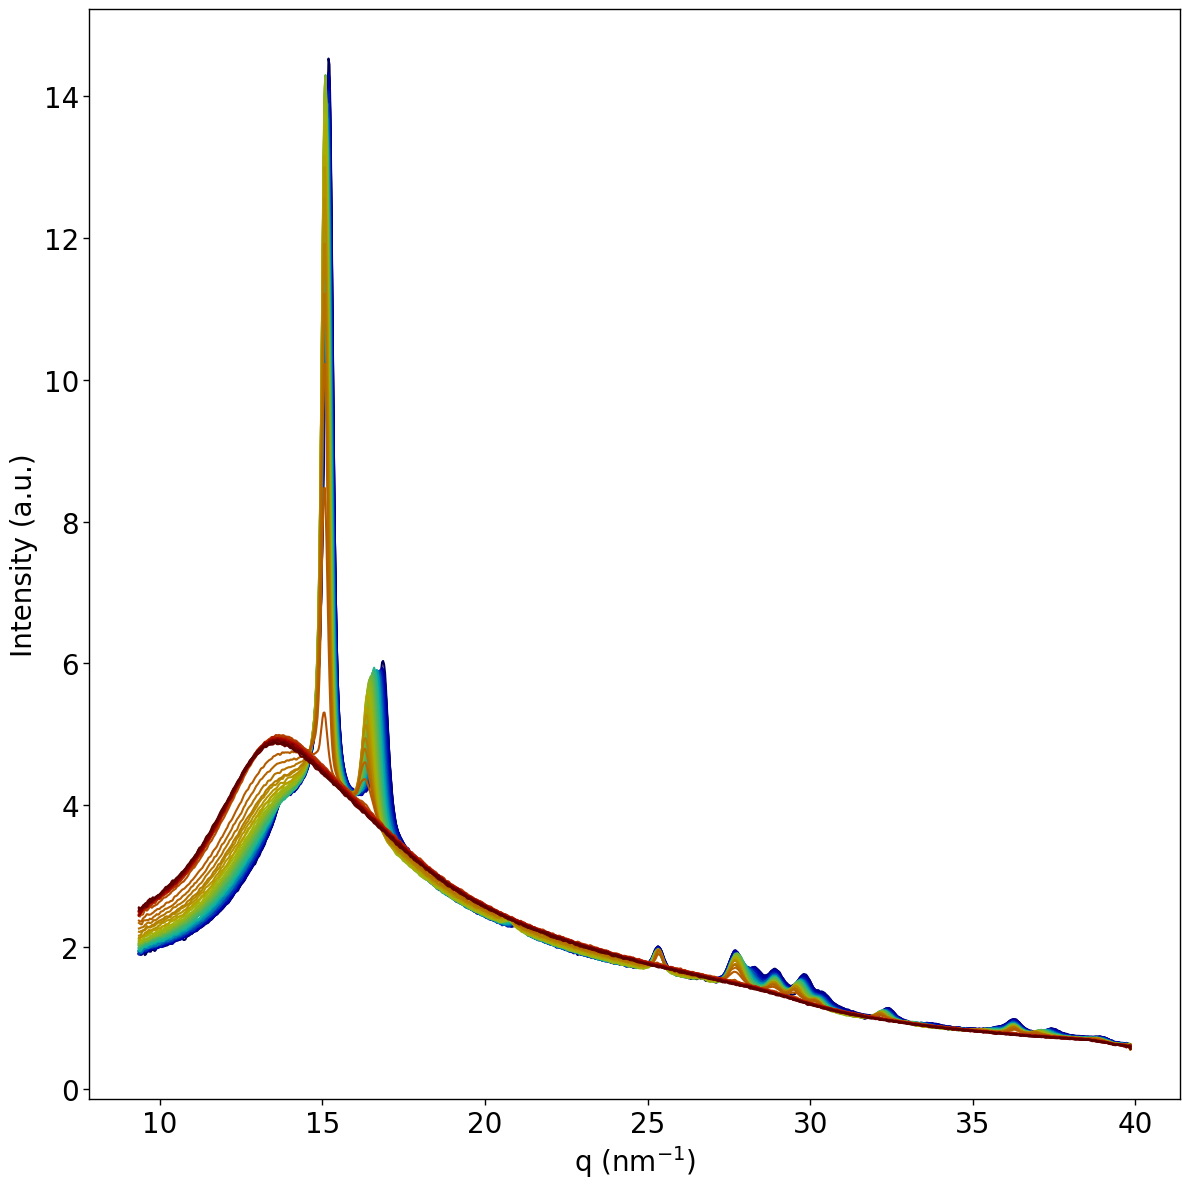

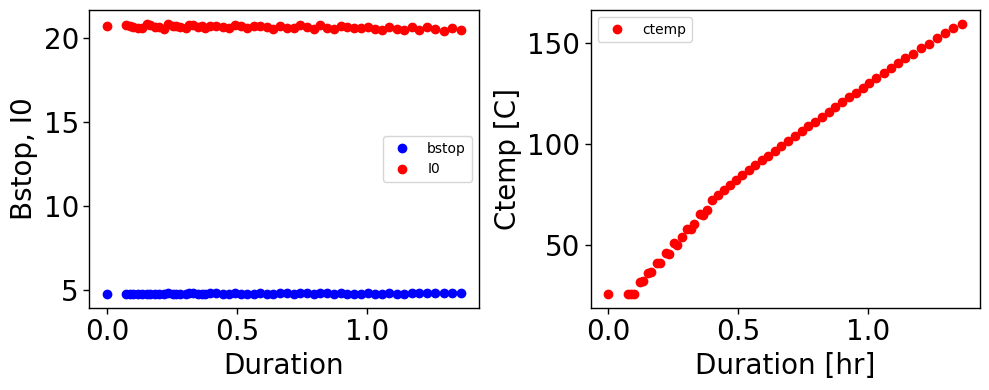

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:20.51147, bstop: 4.40862, transmission factor: 4.40862, thickness: -0.01263879276019751, normfactor: 90.4272768714


i0:20.499616666666668, bstop: 4.434629999999999, transmission factor: 4.434629999999999, thickness: -0.012688906829904067, normfactor: 90.90821505849999
i0:20.472533333333335, bstop: 4.424733333333333, transmission factor: 4.424733333333333, thickness: -0.012669873420841186, normfactor: 90.58550065777779
i0:20.717536666666664, bstop: 4.47324, transmission factor: 4.47324, thickness: -0.012762758211069725, normfactor: 92.67451371879999
i0:20.683843333333332, bstop: 4.466126666666667, transmission factor: 4.466126666666667, thickness: -0.01274920018477482, normfactor: 92.37666428015555
i0:20.610586666666666, bstop: 4.457686666666667, transmission factor: 4.457686666666667, thickness: -0.01273308549052612, normfactor: 91.87553737617777


i0:20.565046666666667, bstop: 4.448723333333334, transmission factor: 4.448723333333334, thickness: -0.012715938141752555, normfactor: 91.4882029570889
i0:20.523766666666667, bstop: 4.444403333333334, transmission factor: 4.444403333333334, thickness: -0.01270766140249481, normfactor: 91.2158969858889
i0:20.769996666666668, bstop: 4.488720000000001, transmission factor: 4.488720000000001, thickness: -0.012792188759696354, normfactor: 93.23069943760002
i0:20.715576666666664, bstop: 4.48423, transmission factor: 4.48423, thickness: -0.01278366284269617, normfactor: 92.89341035596665
i0:20.598066666666668, bstop: 4.4740166666666665, transmission factor: 4.4740166666666665, thickness: -0.012764237233438705, normfactor: 92.15609356777777


i0:20.59570666666667, bstop: 4.465706666666667, transmission factor: 4.465706666666667, thickness: -0.01274839898899864, normfactor: 91.97438456604445
i0:20.508223333333333, bstop: 4.456346666666666, transmission factor: 4.456346666666666, thickness: -0.01273052419011723, normfactor: 91.39175269075554
i0:20.806053333333335, bstop: 4.509136666666667, transmission factor: 4.509136666666667, thickness: -0.012830850062427377, normfactor: 93.81733797395556
i0:20.73212666666667, bstop: 4.499556666666667, transmission factor: 4.499556666666667, thickness: -0.01281273107846951, normfactor: 93.2853787571778
i0:20.634823333333333, bstop: 4.491, transmission factor: 4.491, thickness: -0.012796514914265778, normfactor: 92.67099159


i0:20.61315, bstop: 4.480899999999999, transmission factor: 4.480899999999999, thickness: -0.01277733409717636, normfactor: 92.36546383499999
i0:20.556193333333333, bstop: 4.4706133333333336, transmission factor: 4.4706133333333336, thickness: -0.012757754291995773, normfactor: 91.89879199857778
i0:20.787296666666666, bstop: 4.528696666666667, transmission factor: 4.528696666666667, thickness: -0.012867725329229739, normfactor: 94.13936112334444
i0:20.75914, bstop: 4.518400000000001, transmission factor: 4.518400000000001, thickness: -0.012848333553430662, normfactor: 93.79809817600001
i0:20.687359999999998, bstop: 4.518736666666666, transmission factor: 4.518736666666666, thickness: -0.012848968298359933, normfactor: 93.48073216853332


i0:20.593313333333334, bstop: 4.50992, transmission factor: 4.50992, thickness: -0.012832329904819069, normfactor: 92.87419566826668
i0:20.504833333333334, bstop: 4.511033333333333, transmission factor: 4.511033333333333, thickness: -0.012834432727966997, normfactor: 92.4979866611111
i0:20.711429999999996, bstop: 4.561393333333334, transmission factor: 4.561393333333334, thickness: -0.01292901215670875, normfactor: 94.4729787258
i0:20.66342333333333, bstop: 4.557996666666667, transmission factor: 4.557996666666667, thickness: -0.012922665907369745, normfactor: 94.18381467525555
i0:20.52288666666667, bstop: 4.548683333333333, transmission factor: 4.548683333333333, thickness: -0.012905240810814353, normfactor: 93.35211253255555


i0:20.672700000000003, bstop: 4.587606666666667, transmission factor: 4.587606666666667, thickness: -0.012977830134093812, normfactor: 94.83821633800001
i0:20.715433333333333, bstop: 4.602740000000001, transmission factor: 4.602740000000001, thickness: -0.013005886606665967, normfactor: 95.34775362066668
i0:20.629389999999997, bstop: 4.593993333333334, transmission factor: 4.593993333333334, thickness: -0.012989681977983388, normfactor: 94.77128013073333
i0:20.50872, bstop: 4.58359, transmission factor: 4.58359, thickness: -0.012970367884270445, normfactor: 94.0035639048
i0:20.74575, bstop: 4.634273333333334, transmission factor: 4.634273333333334, thickness: -0.013064052709830345, normfactor: 96.14147600500002


i0:20.634063333333334, bstop: 4.617793333333333, transmission factor: 4.617793333333333, thickness: -0.013033703395466462, normfactor: 95.28384010024445
i0:20.54883, bstop: 4.602503333333334, transmission factor: 4.602503333333334, thickness: -0.013005448548488622, normfactor: 94.5760585711
i0:20.739843333333333, bstop: 4.676236666666667, transmission factor: 4.676236666666667, thickness: -0.01314084708650325, normfactor: 96.98441585625557
i0:20.636300000000002, bstop: 4.674166666666667, transmission factor: 4.674166666666667, thickness: -0.013137075101314299, normfactor: 96.45750558333336
i0:20.58716666666667, bstop: 4.723723333333333, transmission factor: 4.723723333333333, thickness: -0.013226922545101575, normfactor: 97.24807955055556


i0:20.741993333333337, bstop: 4.782676666666666, transmission factor: 4.782676666666666, thickness: -0.013332586733169968, normfactor: 99.2022475354889
i0:20.669403333333335, bstop: 4.78254, transmission factor: 4.78254, thickness: -0.013332343289906623, normfactor: 98.85224821780001
i0:20.56643, bstop: 4.74473, transmission factor: 4.74473, thickness: -0.013264724023445895, normfactor: 97.58215741389999
i0:20.641000000000002, bstop: 4.744689999999999, transmission factor: 4.744689999999999, thickness: -0.013264652202636784, normfactor: 97.93514628999999
i0:20.718013333333335, bstop: 4.76204, transmission factor: 4.76204, thickness: -0.013295747790568743, normfactor: 98.66000821386667


i0:20.61874, bstop: 4.72513, transmission factor: 4.72513, thickness: -0.013229459087129664, normfactor: 97.4262269362
i0:20.511343333333333, bstop: 4.75717, transmission factor: 4.75717, thickness: -0.013287030970883773, normfactor: 97.57594716503334
i0:20.747836666666668, bstop: 4.968406666666667, transmission factor: 4.968406666666667, thickness: -0.013657159209957867, normfactor: 103.08369001357778
i0:20.645300000000002, bstop: 4.968929999999999, transmission factor: 4.968929999999999, thickness: -0.013658056511399565, normfactor: 102.585050529
i0:20.550023333333336, bstop: 4.961543333333334, transmission factor: 4.961543333333334, thickness: -0.01364538266022927, normfactor: 101.95983126934448


i0:20.722346666666667, bstop: 5.02025, transmission factor: 5.02025, thickness: -0.013745593298149148, normfactor: 104.03136085333333
i0:20.598676666666666, bstop: 4.935323333333333, transmission factor: 4.935323333333333, thickness: -0.013600242202865685, normfactor: 101.66112958878888
i0:20.532616666666666, bstop: 4.854106666666667, transmission factor: 4.854106666666667, thickness: -0.013458881827054634, normfactor: 99.66751144577778
i0:20.696023333333333, bstop: 5.079463333333333, transmission factor: 5.079463333333333, thickness: -0.013845488679641417, normfactor: 105.12469166747776


i0:20.646186666666665, bstop: 5.23152, transmission factor: 5.23152, thickness: -0.01409677383745637, normfactor: 108.01093847039999
i0:20.493033333333333, bstop: 5.2302566666666666, transmission factor: 5.2302566666666666, thickness: -0.014094716324950244, normfactor: 107.18382421188889
i0:20.695396666666667, bstop: 5.272513333333333, transmission factor: 5.272513333333333, thickness: -0.014163268887704588, normfactor: 109.11675486362223
i0:20.578826666666668, bstop: 5.2555000000000005, transmission factor: 5.2555000000000005, thickness: -0.014135734632480504, normfactor: 108.15202354666668
i0:20.52707, bstop: 5.17801, transmission factor: 5.17801, thickness: -0.014009187245874365, normfactor: 106.28937373069998


i0:20.698183333333333, bstop: 5.113806666666666, transmission factor: 5.113806666666666, thickness: -0.01390289510854031, normfactor: 105.84650791788887
i0:20.563666666666666, bstop: 5.229513333333334, transmission factor: 5.229513333333334, thickness: -0.014093505471886194, normfactor: 107.53796901555557
i0:20.73681, bstop: 5.281126666666666, transmission factor: 5.281126666666666, thickness: -0.014177174785922616, normfactor: 109.51372027259998


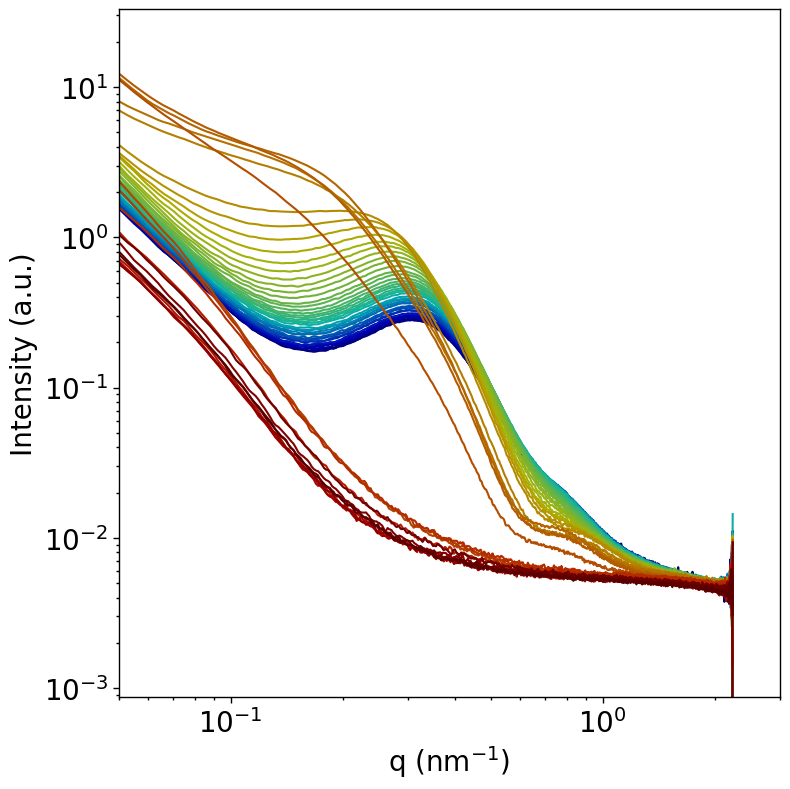

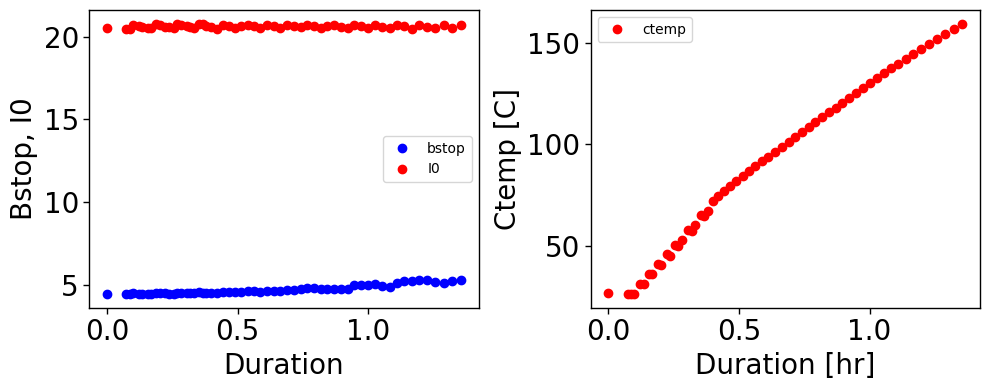

Processing WAXS data...
i0:20.51147, bstop: 4.40862, transmission factor: 0.21493437574196292, thickness: 0.013097645010212464, normfactor: 90.4272768714
i0:20.499616666666668, bstop: 4.434629999999999, transmission factor: 0.21632745978176823, thickness: 0.01304260636042925, normfactor: 90.90821505849999
i0:20.472533333333335, bstop: 4.424733333333333, transmission factor: 0.21613022977127075, thickness: 0.013050377046696848, normfactor: 90.58550065777779
i0:20.717536666666664, bstop: 4.47324, transmission factor: 0.21591563089627291, thickness: 0.013058840110186916, normfactor: 92.67451371879999


i0:20.683843333333332, bstop: 4.466126666666667, transmission factor: 0.2159234429835977, thickness: 0.013058531880032087, normfactor: 92.37666428015555
i0:20.610586666666666, bstop: 4.457686666666667, transmission factor: 0.21628140618995803, thickness: 0.013044420196625309, normfactor: 91.87553737617777
i0:20.565046666666667, bstop: 4.448723333333334, transmission factor: 0.21632449492780145, thickness: 0.013042723120569488, normfactor: 91.4882029570889
i0:20.523766666666667, bstop: 4.444403333333334, transmission factor: 0.216549106483053, thickness: 0.013033882128448115, normfactor: 91.2158969858889
i0:20.769996666666668, bstop: 4.488720000000001, transmission factor: 0.21611558595981162, thickness: 0.013050954282555108, normfactor: 93.23069943760002
i0:20.715576666666664, bstop: 4.48423, transmission factor: 0.2164665783702538, thickness: 0.013037129472189367, normfactor: 92.89341035596665
i0:20.598066666666668, bstop: 4.4740166666666665, transmission factor: 0.2172056600781303, t

i0:20.787296666666666, bstop: 4.528696666666667, transmission factor: 0.21785885578515982, thickness: 0.012982510694820138, normfactor: 94.13936112334444
i0:20.75914, bstop: 4.518400000000001, transmission factor: 0.2176583423012707, thickness: 0.012990355249146742, normfactor: 93.79809817600001
i0:20.687359999999998, bstop: 4.518736666666666, transmission factor: 0.21842983670544075, thickness: 0.012960212081430998, normfactor: 93.48073216853332
i0:20.593313333333334, bstop: 4.50992, transmission factor: 0.2189992415013676, thickness: 0.01293803299325488, normfactor: 92.87419566826668
i0:20.504833333333334, bstop: 4.511033333333333, transmission factor: 0.2199985369303172, thickness: 0.012899248126887631, normfactor: 92.4979866611111
i0:20.711429999999996, bstop: 4.561393333333334, transmission factor: 0.22023555753192006, thickness: 0.012890074682445527, normfactor: 94.4729787258
i0:20.66342333333333, bstop: 4.557996666666667, transmission factor: 0.22058284308166431, thickness: 0.01

i0:20.50872, bstop: 4.58359, transmission factor: 0.22349468908834877, thickness: 0.012764927626063249, normfactor: 94.0035639048
i0:20.74575, bstop: 4.634273333333334, transmission factor: 0.22338422729153362, thickness: 0.012769139275529738, normfactor: 96.14147600500002
i0:20.634063333333334, bstop: 4.617793333333333, transmission factor: 0.22379466703843595, thickness: 0.012753500663476587, normfactor: 95.28384010024445
i0:20.54883, bstop: 4.602503333333334, transmission factor: 0.2239788510262304, thickness: 0.012746492189550982, normfactor: 94.5760585711
i0:20.739843333333333, bstop: 4.676236666666667, transmission factor: 0.225471166368502, thickness: 0.012689918986364545, normfactor: 96.98441585625557
i0:20.636300000000002, bstop: 4.674166666666667, transmission factor: 0.22650216689361305, thickness: 0.0126510523641654, normfactor: 96.45750558333336
i0:20.58716666666667, bstop: 4.723723333333333, transmission factor: 0.22944990001861998, thickness: 0.012540897166342461, normfa

i0:20.61874, bstop: 4.72513, transmission factor: 0.2291667677074351, thickness: 0.012551416049371773, normfactor: 97.4262269362
i0:20.511343333333333, bstop: 4.75717, transmission factor: 0.2319287392683366, thickness: 0.012449354189699405, normfactor: 97.57594716503334
i0:20.747836666666668, bstop: 4.968406666666667, transmission factor: 0.2394662511802435, thickness: 0.012176889620020547, normfactor: 103.08369001357778
i0:20.645300000000002, bstop: 4.968929999999999, transmission factor: 0.24068092980000286, thickness: 0.01213378558753581, normfactor: 102.585050529
i0:20.550023333333336, bstop: 4.961543333333334, transmission factor: 0.24143735765425733, thickness: 0.012107052800737886, normfactor: 101.95983126934448
i0:20.722346666666667, bstop: 5.02025, transmission factor: 0.24226262019230768, thickness: 0.012077982705400886, normfactor: 104.03136085333333
i0:20.598676666666666, bstop: 4.935323333333333, transmission factor: 0.23959419399595733, thickness: 0.012172339157184318, n

i0:20.493033333333333, bstop: 5.2302566666666666, transmission factor: 0.2552212052551192, thickness: 0.011634060526854981, normfactor: 107.18382421188889
i0:20.695396666666667, bstop: 5.272513333333333, transmission factor: 0.25476744506306476, thickness: 0.011649220413971446, normfactor: 109.11675486362223
i0:20.578826666666668, bstop: 5.2555000000000005, transmission factor: 0.2553838508447518, thickness: 0.011628633185145286, normfactor: 108.15202354666668
i0:20.52707, bstop: 5.17801, transmission factor: 0.2522527569692119, thickness: 0.011733727357374418, normfactor: 106.28937373069998
i0:20.698183333333333, bstop: 5.113806666666666, transmission factor: 0.2470654832026321, thickness: 0.011910741242227971, normfactor: 105.84650791788887
i0:20.563666666666666, bstop: 5.229513333333334, transmission factor: 0.2543084080335868, thickness: 0.011664584096040983, normfactor: 107.53796901555557
i0:20.73681, bstop: 5.281126666666666, transmission factor: 0.25467401527364464, thickness: 0

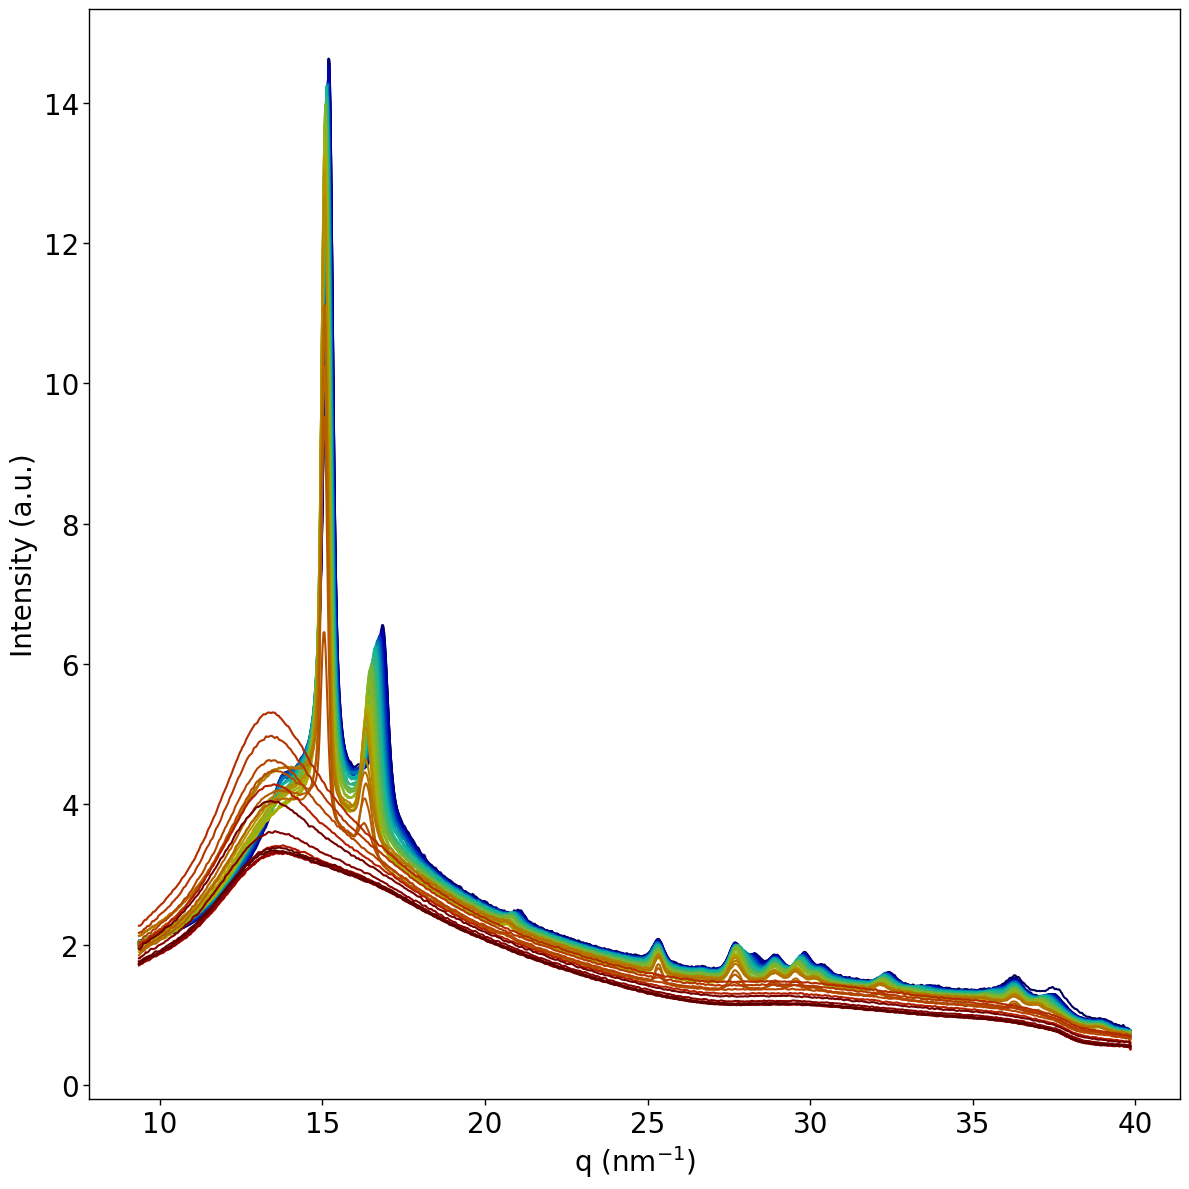

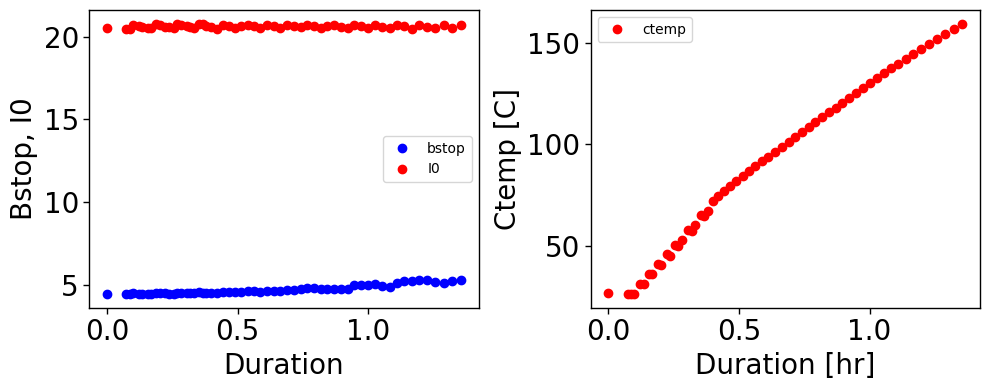

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:20.9468, bstop: 4.56595, transmission factor: 4.56595, thickness: -0.012937518303628704, normfactor: 95.64204146


i0:20.845476666666666, bstop: 4.6267, transmission factor: 4.6267, thickness: -0.013050119200703071, normfactor: 96.44576689366666
i0:21.070083333333333, bstop: 4.669636666666666, transmission factor: 4.669636666666666, thickness: -0.013128814635883073, normfactor: 98.38963370305555
i0:21.032456666666665, bstop: 4.667046666666667, transmission factor: 4.667046666666667, thickness: -0.013124088163585021, normfactor: 98.15945677797777
i0:20.96626666666667, bstop: 4.66523, transmission factor: 4.66523, thickness: -0.013120771376310477, normfactor: 97.81245624133335
i0:20.9034, bstop: 4.654936666666667, transmission factor: 4.654936666666667, thickness: -0.013101953851130563, normfactor: 97.30400311800001


i0:20.88767, bstop: 4.646780000000001, transmission factor: 4.646780000000001, thickness: -0.013087012850286479, normfactor: 97.06040720260002
i0:21.137083333333333, bstop: 4.70451, transmission factor: 4.70451, thickness: -0.013192200686233007, normfactor: 99.43961991249999
i0:21.05225, bstop: 4.69286, transmission factor: 4.69286, thickness: -0.01317107796865823, normfactor: 98.795261935
i0:20.986776666666668, bstop: 4.681513333333333, transmission factor: 4.681513333333333, thickness: -0.013150454760064082, normfactor: 98.24987478868889
i0:20.945686666666663, bstop: 4.675936666666667, transmission factor: 4.675936666666667, thickness: -0.01314030052545403, normfactor: 97.94070429317776


i0:20.881073333333333, bstop: 4.6648, transmission factor: 4.6648, thickness: -0.013119986112855192, normfactor: 97.40603088533332
i0:21.104586666666666, bstop: 4.712136666666667, transmission factor: 4.712136666666667, thickness: -0.01320600035163541, normfactor: 99.44769666684445
i0:21.100966666666668, bstop: 4.709093333333334, transmission factor: 4.709093333333334, thickness: -0.0132004964342995, normfactor: 99.3664214568889
i0:20.985, bstop: 4.6997333333333335, transmission factor: 4.6997333333333335, thickness: -0.013183546403366277, normfactor: 98.623904
i0:20.92570666666667, bstop: 4.694023333333333, transmission factor: 4.694023333333333, thickness: -0.013173189573869993, normfactor: 98.22575535982223


i0:20.881600000000002, bstop: 4.682176666666667, transmission factor: 4.682176666666667, thickness: -0.013151661780897387, normfactor: 97.77134028266669
i0:21.12028666666667, bstop: 4.739786666666667, transmission factor: 4.739786666666667, thickness: -0.013255843578983762, normfactor: 100.10565313884446
i0:21.05228, bstop: 4.72782, transmission factor: 4.72782, thickness: -0.013234307670883082, normfactor: 99.53139042960001
i0:21.002753333333334, bstop: 4.7198400000000005, transmission factor: 4.7198400000000005, thickness: -0.013219916083135592, normfactor: 99.12963529280002
i0:20.923933333333334, bstop: 4.715199999999999, transmission factor: 4.715199999999999, thickness: -0.013211536850639605, normfactor: 98.66053045333332


i0:20.848556666666667, bstop: 4.702249999999999, transmission factor: 4.702249999999999, thickness: -0.013188107152677877, normfactor: 98.03512558583333
i0:21.077550000000002, bstop: 4.750463333333333, transmission factor: 4.750463333333333, thickness: -0.013275012081447065, normfactor: 100.1281284315
i0:20.98821, bstop: 4.737933333333333, transmission factor: 4.737933333333333, thickness: -0.013252511773496168, normfactor: 99.440739766
i0:20.95873, bstop: 4.7296000000000005, transmission factor: 4.7296000000000005, thickness: -0.013237514510957202, normfactor: 99.126409408


i0:20.98434, bstop: 4.741503333333333, transmission factor: 4.741503333333333, thickness: -0.01325892853175529, normfactor: 99.4973180578
i0:21.027779999999996, bstop: 4.76004, transmission factor: 4.76004, thickness: -0.013292169067052469, normfactor: 100.09307391119998
i0:20.939003333333332, bstop: 4.74964, transmission factor: 4.74964, thickness: -0.013273535432223357, normfactor: 99.45272779213333
i0:20.86042, bstop: 4.73117, transmission factor: 4.73117, thickness: -0.01324034201440288, normfactor: 98.6941932914
i0:21.07058, bstop: 4.784196666666666, transmission factor: 4.784196666666666, thickness: -0.013335293828431481, normfactor: 100.80579860073333


i0:20.975080000000002, bstop: 4.759736666666667, transmission factor: 4.759736666666667, thickness: -0.013291626162668359, normfactor: 99.83585736226668
i0:20.908996666666667, bstop: 4.74794, transmission factor: 4.74794, thickness: -0.01327048567030924, normfactor: 99.27466163353333
i0:21.09418333333333, bstop: 4.79314, transmission factor: 4.79314, thickness: -0.013351204362613792, normfactor: 101.10737390233332
i0:20.985453333333336, bstop: 4.780906666666667, transmission factor: 4.780906666666667, thickness: -0.013329433307520474, normfactor: 100.32949374435556
i0:20.900746666666667, bstop: 4.761583333333333, transmission factor: 4.761583333333333, thickness: -0.01329493078113101, normfactor: 99.52064698222222


i0:20.957293333333332, bstop: 4.780993333333333, transmission factor: 4.780993333333333, thickness: -0.013329587739723472, normfactor: 100.19667971137777
i0:21.012056666666666, bstop: 4.8005700000000004, transmission factor: 4.8005700000000004, thickness: -0.01336440005810768, normfactor: 100.86984887230001
i0:20.90017, bstop: 4.786073333333333, transmission factor: 4.786073333333333, thickness: -0.013338634954987254, normfactor: 100.02974629913334
i0:20.816326666666665, bstop: 4.76804, transmission factor: 4.76804, thickness: -0.01330647494992769, normfactor: 99.25307819973332
i0:21.052366666666668, bstop: 4.817060000000001, transmission factor: 4.817060000000001, thickness: -0.013393613517410275, normfactor: 101.41051337533335


i0:20.96854, bstop: 4.79776, transmission factor: 4.79776, thickness: -0.013359411895230424, normfactor: 100.60202247040002
i0:20.825646666666668, bstop: 4.781976666666666, transmission factor: 4.781976666666666, thickness: -0.013331339755208803, normfactor: 99.58775642824443
i0:21.049656666666667, bstop: 4.8279966666666665, transmission factor: 4.8279966666666665, thickness: -0.013412933660972473, normfactor: 101.62767222114445
i0:20.94071, bstop: 4.810223333333333, transmission factor: 4.810223333333333, thickness: -0.013381513926242617, normfactor: 100.72949185856666
i0:20.84051666666667, bstop: 4.79945, transmission factor: 4.79945, thickness: -0.013362412243591349, normfactor: 100.02301771583335


i0:21.073913333333333, bstop: 4.848066666666667, transmission factor: 4.848066666666667, thickness: -0.013448274695957543, normfactor: 102.16773676755557
i0:20.959106666666667, bstop: 4.82732, transmission factor: 4.82732, thickness: -0.01341173956775122, normfactor: 101.17631479413335
i0:20.847426666666667, bstop: 4.81506, transmission factor: 4.81506, thickness: -0.013390075678221345, normfactor: 100.3816102456
i0:21.090506666666666, bstop: 4.8614766666666664, transmission factor: 4.8614766666666664, thickness: -0.013471806770781705, normfactor: 102.53100604817777
i0:20.9844, bstop: 4.841196666666667, transmission factor: 4.841196666666667, thickness: -0.013436193886861814, normfactor: 101.58960733200001


i0:20.86812, bstop: 4.82554, transmission factor: 4.82554, thickness: -0.01340859765608572, normfactor: 100.6999477848
i0:21.074520000000003, bstop: 4.878603333333333, transmission factor: 4.878603333333333, thickness: -0.013501766697020669, normfactor: 102.81422352040002
i0:20.97511666666667, bstop: 4.858976666666667, transmission factor: 4.858976666666667, thickness: -0.013467424658818724, normfactor: 101.91760246394446
i0:20.84603, bstop: 4.839393333333333, transmission factor: 4.839393333333333, thickness: -0.013433019907054712, normfactor: 100.88213860846665
i0:21.020860000000003, bstop: 4.882416666666667, transmission factor: 4.882416666666667, thickness: -0.013508423099292684, normfactor: 102.63259721166668


i0:20.921923333333336, bstop: 4.861903333333333, transmission factor: 4.861903333333333, thickness: -0.01347255442610081, normfactor: 101.72036879407779
i0:20.789716666666667, bstop: 4.84565, transmission factor: 4.84565, thickness: -0.013444026970786269, normfactor: 100.73969056583334
i0:20.93062, bstop: 4.88164, transmission factor: 4.88164, thickness: -0.013507067802698506, normfactor: 102.1757518168


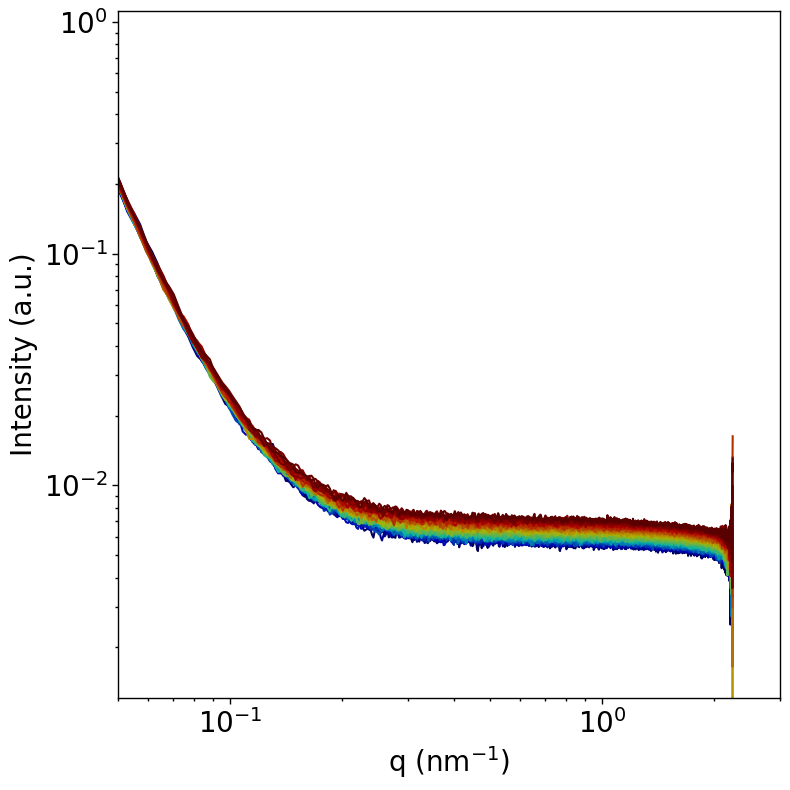

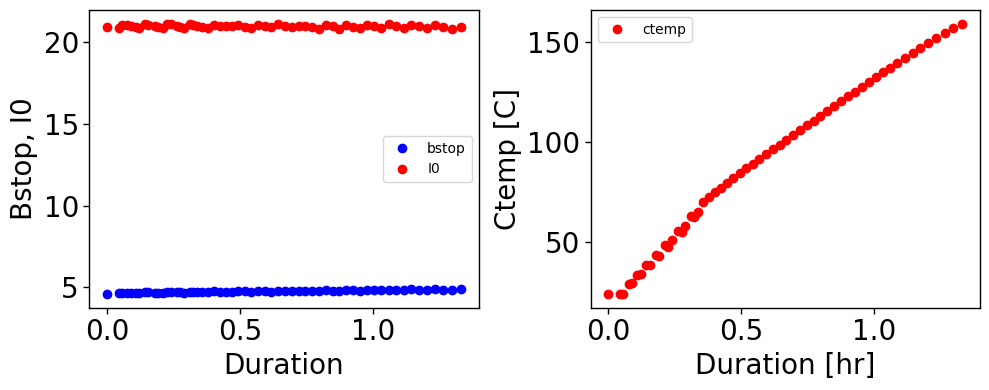

Processing WAXS data...
i0:20.9468, bstop: 4.56595, transmission factor: 0.21797840242901065, thickness: 0.012977837186542102, normfactor: 95.64204146
i0:20.845476666666666, bstop: 4.6267, transmission factor: 0.2219522284850606, thickness: 0.012823927329555559, normfactor: 96.44576689366666
i0:21.070083333333333, bstop: 4.669636666666666, transmission factor: 0.22162402458462035, thickness: 0.012836534148049113, normfactor: 98.38963370305555
i0:21.032456666666665, bstop: 4.667046666666667, transmission factor: 0.22189736275854288, thickness: 0.012826033508580055, normfactor: 98.15945677797777
i0:20.96626666666667, bstop: 4.66523, transmission factor: 0.2225112402780339, thickness: 0.012802497678541958, normfactor: 97.81245624133335


i0:20.9034, bstop: 4.654936666666667, transmission factor: 0.22268801566571308, thickness: 0.01279573221804918, normfactor: 97.30400311800001
i0:20.88767, bstop: 4.646780000000001, transmission factor: 0.22246521512452086, thickness: 0.012804260012404277, normfactor: 97.06040720260002
i0:21.137083333333333, bstop: 4.70451, transmission factor: 0.22257138914624772, thickness: 0.012800195087618375, normfactor: 99.43961991249999
i0:21.05225, bstop: 4.69286, transmission factor: 0.22291489033238723, thickness: 0.012787057247713682, normfactor: 98.795261935
i0:20.986776666666668, bstop: 4.681513333333333, transmission factor: 0.22306966942517611, thickness: 0.012781144049163662, normfactor: 98.24987478868889
i0:20.945686666666663, bstop: 4.675936666666667, transmission factor: 0.22324103005455703, thickness: 0.012774602151553766, normfactor: 97.94070429317776
i0:20.881073333333333, bstop: 4.6648, transmission factor: 0.22339847791987702, thickness: 0.01276859581547082, normfactor: 97.406030

i0:21.05228, bstop: 4.72782, transmission factor: 0.2245752004058468, thickness: 0.012723839685592679, normfactor: 99.53139042960001
i0:21.002753333333334, bstop: 4.7198400000000005, transmission factor: 0.22472482179320616, thickness: 0.012718165713121461, normfactor: 99.12963529280002
i0:20.923933333333334, bstop: 4.715199999999999, transmission factor: 0.22534959966099424, thickness: 0.012694513512468898, normfactor: 98.66053045333332
i0:20.848556666666667, bstop: 4.702249999999999, transmission factor: 0.22554319107941442, thickness: 0.012687198032794049, normfactor: 98.03512558583333
i0:21.077550000000002, bstop: 4.750463333333333, transmission factor: 0.22538024264363424, thickness: 0.01269335514942459, normfactor: 100.1281284315
i0:20.98821, bstop: 4.737933333333333, transmission factor: 0.22574261136768375, thickness: 0.012679668852997457, normfactor: 99.440739766
i0:20.95873, bstop: 4.7296000000000005, transmission factor: 0.2256625282161658, thickness: 0.012682691619714146, n

i0:20.975080000000002, bstop: 4.759736666666667, transmission factor: 0.2269234094299839, thickness: 0.012635223261302893, normfactor: 99.83585736226668
i0:20.908996666666667, bstop: 4.74794, transmission factor: 0.22707641479369564, thickness: 0.012629481026351478, normfactor: 99.27466163353333
i0:21.09418333333333, bstop: 4.79314, transmission factor: 0.22722567279605518, thickness: 0.012623883155444705, normfactor: 101.10737390233332
i0:20.985453333333336, bstop: 4.780906666666667, transmission factor: 0.2278200327973218, thickness: 0.012601628300253728, normfactor: 100.32949374435556
i0:20.900746666666667, bstop: 4.761583333333333, transmission factor: 0.2278188147664262, thickness: 0.012601673848066902, normfactor: 99.52064698222222
i0:20.957293333333332, bstop: 4.780993333333333, transmission factor: 0.2281302865446365, thickness: 0.012590034400272, normfactor: 100.19667971137777
i0:21.012056666666666, bstop: 4.8005700000000004, transmission factor: 0.22846740212801636, thickness

i0:21.052366666666668, bstop: 4.817060000000001, transmission factor: 0.22881322923313452, thickness: 0.012564568910379435, normfactor: 101.41051337533335
i0:20.96854, bstop: 4.79776, transmission factor: 0.2288075373869616, thickness: 0.012564780833041665, normfactor: 100.60202247040002
i0:20.825646666666668, bstop: 4.781976666666666, transmission factor: 0.22961960044778118, thickness: 0.012534598704666328, normfactor: 99.58775642824443
i0:21.049656666666667, bstop: 4.8279966666666665, transmission factor: 0.22936225246429195, thickness: 0.012544152045475269, normfactor: 101.62767222114445
i0:20.94071, bstop: 4.810223333333333, transmission factor: 0.22970679281329684, thickness: 0.012531364354512122, normfactor: 100.72949185856666
i0:20.84051666666667, bstop: 4.79945, transmission factor: 0.2302941945617151, thickness: 0.012509606970448678, normfactor: 100.02301771583335
i0:21.073913333333333, bstop: 4.848066666666667, transmission factor: 0.23005061233683224, thickness: 0.012518622

i0:20.9844, bstop: 4.841196666666667, transmission factor: 0.23070455512984248, thickness: 0.01249444010057936, normfactor: 101.58960733200001
i0:20.86812, bstop: 4.82554, transmission factor: 0.23123980502316452, thickness: 0.012474697830652495, normfactor: 100.6999477848
i0:21.074520000000003, bstop: 4.878603333333333, transmission factor: 0.2314929750871352, thickness: 0.012465375766238535, normfactor: 102.81422352040002
i0:20.97511666666667, bstop: 4.858976666666667, transmission factor: 0.23165433326950108, thickness: 0.012459439657645375, normfactor: 101.91760246394446
i0:20.84603, bstop: 4.839393333333333, transmission factor: 0.23214939887035244, thickness: 0.012441252758947873, normfactor: 100.88213860846665
i0:21.020860000000003, bstop: 4.882416666666667, transmission factor: 0.23226531486659757, thickness: 0.012437000033153284, normfactor: 102.63259721166668
i0:20.921923333333336, bstop: 4.861903333333333, transmission factor: 0.23238319230370308, thickness: 0.01243267752203

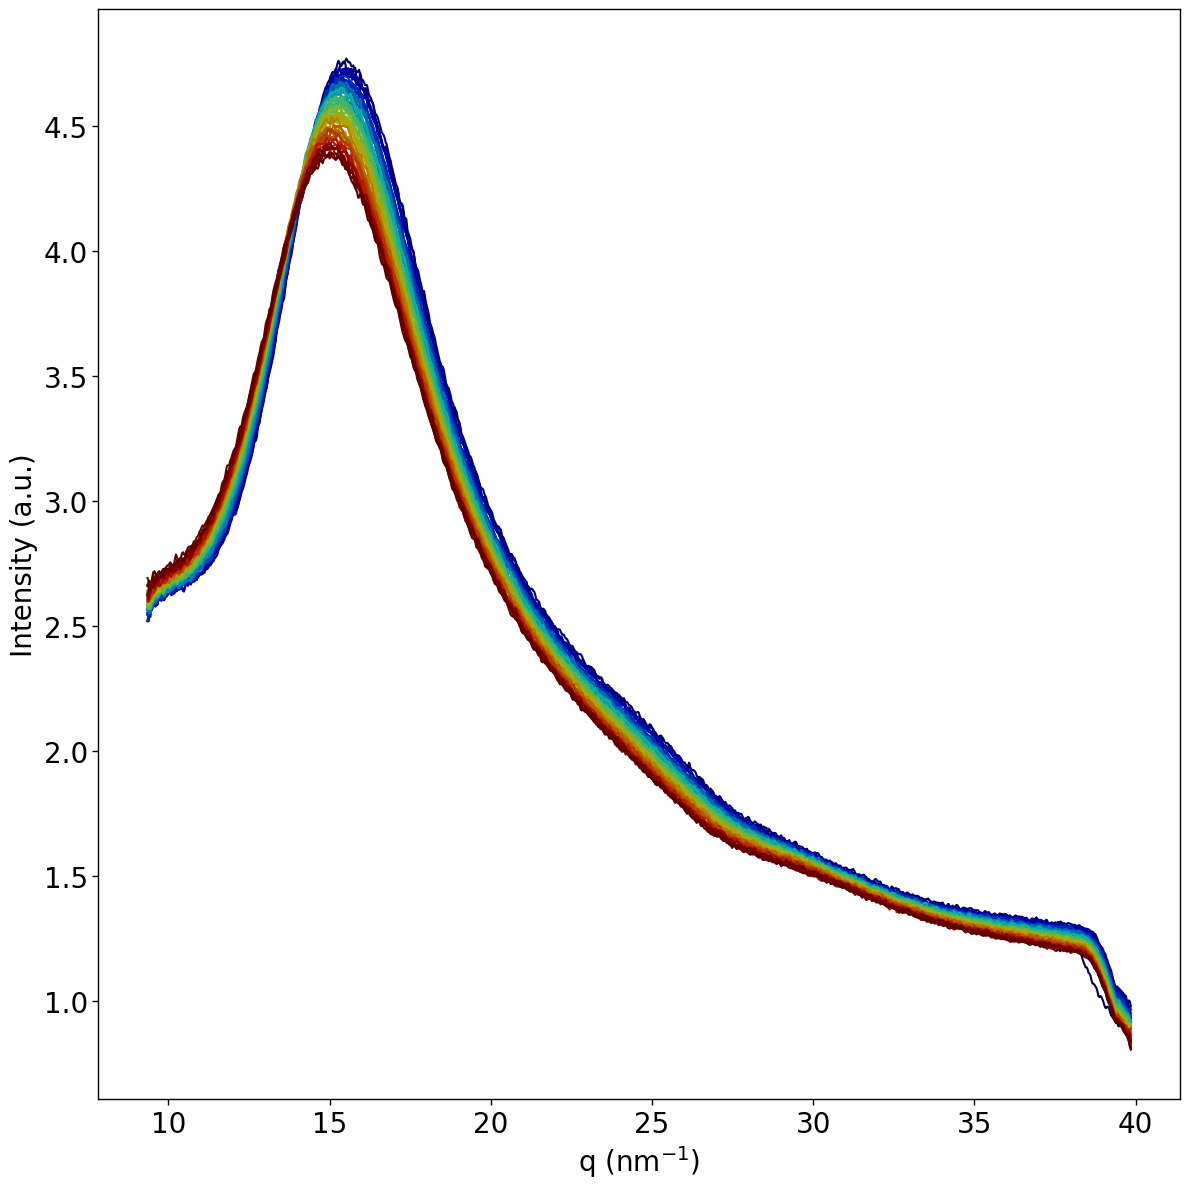

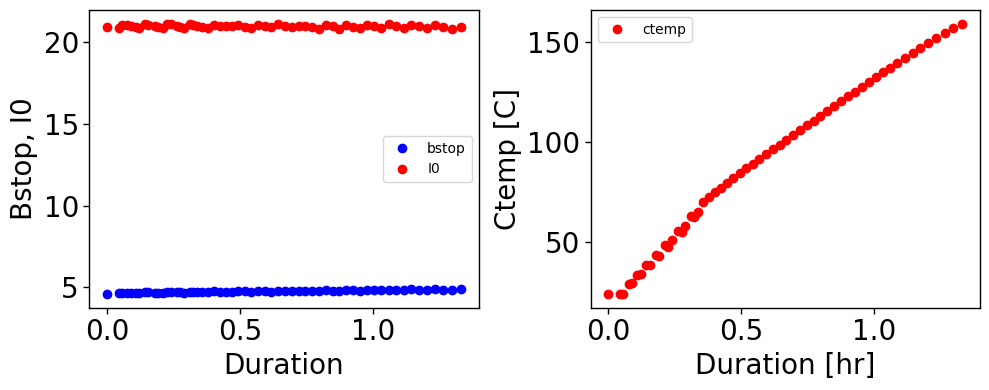

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:21.29606, bstop: 4.71268, transmission factor: 4.71268, thickness: -0.013206982604739981, normfactor: 100.3615160408


i0:21.163520000000002, bstop: 4.73555, transmission factor: 4.73555, thickness: -0.01324822525135033, normfactor: 100.22090713600001
i0:21.427286666666664, bstop: 4.7797133333333335, transmission factor: 4.7797133333333335, thickness: -0.013327306610178695, normfactor: 102.4162877778222
i0:21.327586666666665, bstop: 4.768496666666667, transmission factor: 4.768496666666667, thickness: -0.013307290853060736, normfactor: 101.70052592804444
i0:21.273613333333333, bstop: 4.7634, transmission factor: 4.7634, thickness: -0.013298180464137438, normfactor: 101.334729752
i0:21.201113333333335, bstop: 4.75618, transmission factor: 4.75618, thickness: -0.0132852578771613, normfactor: 100.83631121373334


i0:21.188983333333333, bstop: 4.74753, transmission factor: 4.74753, thickness: -0.01326974997605886, normfactor: 100.5953340445
i0:21.132196666666665, bstop: 4.747730000000001, transmission factor: 4.747730000000001, thickness: -0.01327010885923977, normfactor: 100.32996408023334
i0:21.375376666666668, bstop: 4.799496666666667, transmission factor: 4.799496666666667, thickness: -0.013362495078457201, normfactor: 102.59104906041112
i0:21.31028333333333, bstop: 4.79009, transmission factor: 4.79009, thickness: -0.01334578163345977, normfactor: 102.07817509216666
i0:21.220753333333334, bstop: 4.782706666666666, transmission factor: 4.782706666666666, thickness: -0.013332640171003975, normfactor: 101.49263843902222


i0:21.172963333333332, bstop: 4.770913333333334, transmission factor: 4.770913333333334, thickness: -0.013311607288177374, normfactor: 101.01437307317778
i0:21.291349999999998, bstop: 4.796703333333333, transmission factor: 4.796703333333333, thickness: -0.01335753540074379, normfactor: 102.12828951616666
i0:21.37621, bstop: 4.814263333333334, transmission factor: 4.814263333333334, thickness: -0.01338866602967284, normfactor: 102.91070400863335
i0:21.277313333333336, bstop: 4.81439, transmission factor: 4.81439, thickness: -0.013388890173489175, normfactor: 102.43728453886669
i0:21.17534666666667, bstop: 4.80512, transmission factor: 4.80512, thickness: -0.013372470788382466, normfactor: 101.75008177493334


i0:21.16798333333333, bstop: 4.7973333333333334, transmission factor: 4.7973333333333334, thickness: -0.013358654243738744, normfactor: 101.54987204444443
i0:21.213876666666668, bstop: 4.812006666666666, transmission factor: 4.812006666666666, thickness: -0.013384671741869773, normfactor: 102.08131594584444
i0:21.306546666666666, bstop: 4.83503, transmission factor: 4.83503, thickness: -0.013425335270985278, normfactor: 103.01779232973333
i0:21.269343333333335, bstop: 4.836313333333333, transmission factor: 4.836313333333333, thickness: -0.013427596177718625, normfactor: 102.86520875424445


i0:21.201056666666666, bstop: 4.837186666666667, transmission factor: 4.837186666666667, thickness: -0.013429134425766964, normfactor: 102.55346862724444
i0:21.12649, bstop: 4.8269866666666665, transmission factor: 4.8269866666666665, thickness: -0.013411151282952376, normfactor: 101.97728554346666
i0:21.300366666666665, bstop: 4.87774, transmission factor: 4.87774, thickness: -0.013500258974553817, normfactor: 103.89765050466666
i0:21.24890333333333, bstop: 4.883053333333334, transmission factor: 4.883053333333334, thickness: -0.013509533932704166, normfactor: 103.75952825151111
i0:21.172646666666665, bstop: 4.867823333333334, transmission factor: 4.867823333333334, thickness: -0.013482921378186343, normfactor: 103.06470347242222


i0:21.0934, bstop: 4.87103, transmission factor: 4.87103, thickness: -0.0134885315476315, normfactor: 102.746584202
i0:21.32146, bstop: 4.927373333333334, transmission factor: 4.927373333333334, thickness: -0.013586508061371507, normfactor: 105.05879343173333
i0:21.196293333333333, bstop: 4.91665, transmission factor: 4.91665, thickness: -0.01356794766210209, normfactor: 104.21475561733332
i0:21.156353333333332, bstop: 4.91393, transmission factor: 4.91393, thickness: -0.013563233334656087, normfactor: 103.96083933526666
i0:21.237883333333333, bstop: 4.95861, transmission factor: 4.95861, thickness: -0.013640344487926408, normfactor: 105.3103806755


i0:21.255033333333333, bstop: 4.970536666666667, transmission factor: 4.970536666666667, thickness: -0.013660810693659898, normfactor: 105.64892253455555
i0:21.15122333333333, bstop: 4.956853333333333, transmission factor: 4.956853333333333, thickness: -0.01363732588267591, normfactor: 104.84351188391109
i0:21.11297666666667, bstop: 4.960696666666667, transmission factor: 4.960696666666667, thickness: -0.013643928766356318, normfactor: 104.73507297374447
i0:21.242686666666668, bstop: 5.012996666666666, transmission factor: 5.012996666666666, thickness: -0.01373327569540703, normfactor: 106.48951745104443
i0:21.153783333333333, bstop: 5.002933333333334, transmission factor: 5.002933333333334, thickness: -0.013716156604634374, normfactor: 105.83096776444445


i0:21.051136666666665, bstop: 4.98602, transmission factor: 4.98602, thickness: -0.01368730701699425, normfactor: 104.96138844273332
i0:21.257563333333334, bstop: 5.042280000000001, transmission factor: 5.042280000000001, thickness: -0.01378289580113595, normfactor: 107.18658644440002
i0:21.14188, bstop: 5.044943333333333, transmission factor: 5.044943333333333, thickness: -0.013787394468366899, normfactor: 106.65958656013333
i0:21.028760000000002, bstop: 5.081856666666667, transmission factor: 5.081856666666667, thickness: -0.013849501807902264, normfactor: 106.86514419773334
i0:21.290793333333333, bstop: 5.195573333333333, transmission factor: 5.195573333333333, thickness: -0.014038034768968718, normfactor: 110.61787808817778


i0:21.18341, bstop: 5.06774, transmission factor: 5.06774, thickness: -0.013825803702501844, normfactor: 107.35201419339998
i0:21.07406333333333, bstop: 5.241116666666667, transmission factor: 5.241116666666667, thickness: -0.014112387128886543, normfactor: 110.45162457072222
i0:21.230226666666667, bstop: 5.212596666666667, transmission factor: 5.212596666666667, thickness: -0.014065902434166177, normfactor: 110.66460875524446
i0:21.204826666666666, bstop: 5.365166666666667, transmission factor: 5.365166666666667, thickness: -0.014311676124846427, normfactor: 113.76742920444445


i0:21.06788333333333, bstop: 5.255199999999999, transmission factor: 5.255199999999999, thickness: -0.014135248315330435, normfactor: 110.7159404933333
i0:21.068986666666667, bstop: 5.2331433333333335, transmission factor: 5.2331433333333335, thickness: -0.01409941693030757, normfactor: 110.25702711475556
i0:21.11684, bstop: 5.139993333333333, transmission factor: 5.139993333333333, thickness: -0.01394640883656337, normfactor: 108.54041682106666
i0:21.05187666666667, bstop: 5.070503333333334, transmission factor: 5.070503333333334, thickness: -0.013830447791638426, normfactor: 106.74361081125558
i0:21.019316666666665, bstop: 5.04483, transmission factor: 5.04483, thickness: -0.013787203084104206, normfactor: 106.0388792995


i0:21.15393333333333, bstop: 5.079883333333334, transmission factor: 5.079883333333334, thickness: -0.013846193070127718, normfactor: 107.45951337444444
i0:21.030510000000003, bstop: 5.039723333333333, transmission factor: 5.039723333333333, thickness: -0.013778575069897627, normfactor: 105.98795195890001
i0:21.091676666666668, bstop: 5.0287766666666665, transmission factor: 5.0287766666666665, thickness: -0.01376005053719206, normfactor: 106.0653314822111
i0:21.143473333333333, bstop: 5.026633333333334, transmission factor: 5.026633333333334, thickness: -0.013756418754015776, normfactor: 106.28048783977778
i0:21.01456, bstop: 4.995103333333333, transmission factor: 4.995103333333333, thickness: -0.013702812879215797, normfactor: 104.96989870453332


i0:21.232473333333335, bstop: 5.038076666666667, transmission factor: 5.038076666666667, thickness: -0.013775791065392269, normfactor: 106.9708284762889
i0:21.104453333333332, bstop: 5.0391699999999995, transmission factor: 5.0391699999999995, thickness: -0.013777639655703444, normfactor: 106.34892810373331
i0:20.944950000000002, bstop: 5.0204466666666665, transmission factor: 5.0204466666666665, thickness: -0.013745927029403563, normfactor: 105.15300441100001
i0:21.077223333333333, bstop: 5.118156666666667, transmission factor: 5.118156666666667, thickness: -0.013910138805593756, normfactor: 107.87653111832222


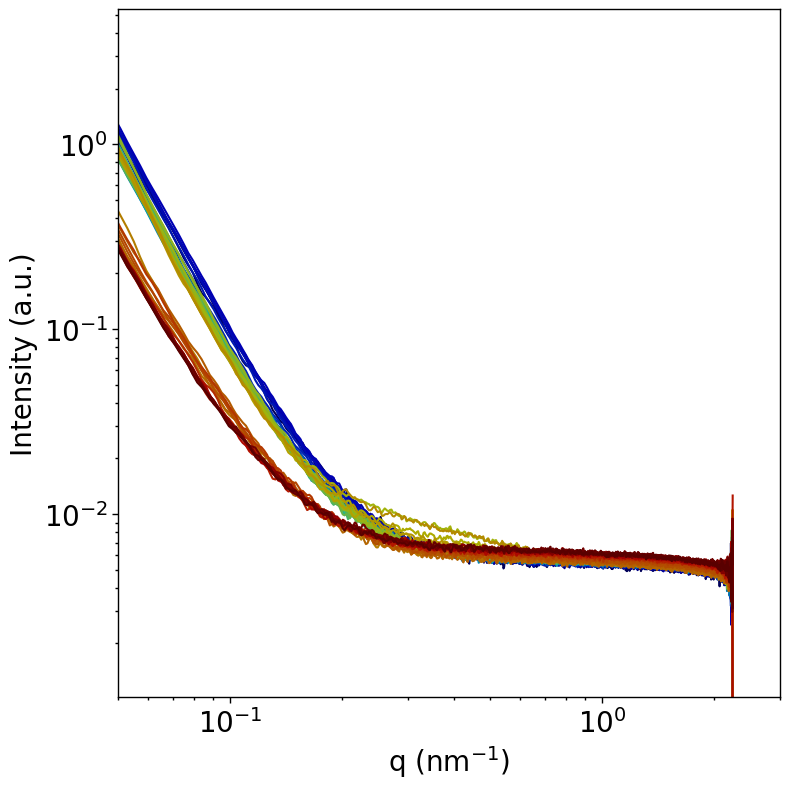

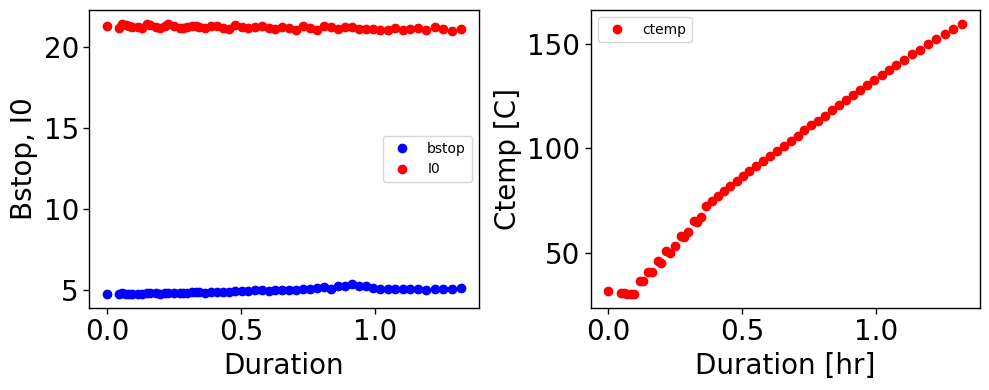

Processing WAXS data...
i0:21.29606, bstop: 4.71268, transmission factor: 0.22129351626545002, thickness: 0.012849248363515765, normfactor: 100.3615160408
i0:21.163520000000002, bstop: 4.73555, transmission factor: 0.22376003613765572, thickness: 0.012754819064813018, normfactor: 100.22090713600001
i0:21.427286666666664, bstop: 4.7797133333333335, transmission factor: 0.2230666629745935, thickness: 0.012781258868874275, normfactor: 102.4162877778222
i0:21.327586666666665, bstop: 4.768496666666667, transmission factor: 0.22358350905775246, thickness: 0.012761542638292754, normfactor: 101.70052592804444
i0:21.273613333333333, bstop: 4.7634, transmission factor: 0.22391118637736512, thickness: 0.012749066259855023, normfactor: 101.334729752


i0:21.201113333333335, bstop: 4.75618, transmission factor: 0.2243363320228151, thickness: 0.012732905940367283, normfactor: 100.83631121373334
i0:21.188983333333333, bstop: 4.74753, transmission factor: 0.22405652622943215, thickness: 0.01274353826046076, normfactor: 100.5953340445
i0:21.132196666666665, bstop: 4.747730000000001, transmission factor: 0.22466807757325755, thickness: 0.012720317134091629, normfactor: 100.32996408023334
i0:21.375376666666668, bstop: 4.799496666666667, transmission factor: 0.2245338990517594, thickness: 0.012725406589661155, normfactor: 102.59104906041112
i0:21.31028333333333, bstop: 4.79009, transmission factor: 0.22477833471633807, thickness: 0.012716137302378156, normfactor: 102.07817509216666
i0:21.220753333333334, bstop: 4.782706666666666, transmission factor: 0.22537874087410653, thickness: 0.012693411915499756, normfactor: 101.49263843902222
i0:21.172963333333332, bstop: 4.770913333333334, transmission factor: 0.22533044894203916, thickness: 0.0126

i0:21.16798333333333, bstop: 4.7973333333333334, transmission factor: 0.22663157173687626, thickness: 0.012646186565728804, normfactor: 101.54987204444443
i0:21.213876666666668, bstop: 4.812006666666666, transmission factor: 0.2268329708085729, thickness: 0.012638619210351521, normfactor: 102.08131594584444
i0:21.306546666666666, bstop: 4.83503, transmission factor: 0.22692696642221388, thickness: 0.012635089724741744, normfactor: 103.01779232973333
i0:21.269343333333335, bstop: 4.836313333333333, transmission factor: 0.2273842336144839, thickness: 0.012617940412129826, normfactor: 102.86520875424445
i0:21.201056666666666, bstop: 4.837186666666667, transmission factor: 0.228157810373288, thickness: 0.012589006621419558, normfactor: 102.55346862724444
i0:21.12649, bstop: 4.8269866666666665, transmission factor: 0.22848029495986633, thickness: 0.012576973817057765, normfactor: 101.97728554346666
i0:21.300366666666665, bstop: 4.87774, transmission factor: 0.22899793587277842, thickness: 0

i0:21.156353333333332, bstop: 4.91393, transmission factor: 0.23226734412011144, thickness: 0.012436925602809467, normfactor: 103.96083933526666
i0:21.237883333333333, bstop: 4.95861, transmission factor: 0.23347948202622204, thickness: 0.012392581785107602, normfactor: 105.3103806755
i0:21.255033333333333, bstop: 4.970536666666667, transmission factor: 0.23385221696507966, thickness: 0.012378992239771455, normfactor: 105.64892253455555
i0:21.15122333333333, bstop: 4.956853333333333, transmission factor: 0.23435303269298688, thickness: 0.012360767060160913, normfactor: 104.84351188391109
i0:21.11297666666667, bstop: 4.960696666666667, transmission factor: 0.23495960541171126, thickness: 0.012338745360420714, normfactor: 104.73507297374447
i0:21.242686666666668, bstop: 5.012996666666666, transmission factor: 0.235986942015809, thickness: 0.01230157713684811, normfactor: 106.48951745104443
i0:21.153783333333333, bstop: 5.002933333333334, transmission factor: 0.23650300537256144, thicknes

i0:21.257563333333334, bstop: 5.042280000000001, transmission factor: 0.23719934034458953, thickness: 0.012257921120400011, normfactor: 107.18658644440002
i0:21.14188, bstop: 5.044943333333333, transmission factor: 0.23862321294668842, thickness: 0.012206934364806982, normfactor: 106.65958656013333
i0:21.028760000000002, bstop: 5.081856666666667, transmission factor: 0.24166221244936298, thickness: 0.012099122393221676, normfactor: 106.86514419773334
i0:21.290793333333333, bstop: 5.195573333333333, transmission factor: 0.24402910929575505, thickness: 0.01201608907451229, normfactor: 110.61787808817778
i0:21.18341, bstop: 5.06774, transmission factor: 0.23923154959470644, thickness: 0.01218524343008992, normfactor: 107.35201419339998
i0:21.07406333333333, bstop: 5.241116666666667, transmission factor: 0.24869986313349793, thickness: 0.011854570728164723, normfactor: 110.45162457072222
i0:21.230226666666667, bstop: 5.212596666666667, transmission factor: 0.24552713207018675, thickness: 0

i0:21.05187666666667, bstop: 5.070503333333334, transmission factor: 0.2408575450834708, thickness: 0.012127536346438334, normfactor: 106.74361081125558
i0:21.019316666666665, bstop: 5.04483, transmission factor: 0.2400092296054661, thickness: 0.012157594551422462, normfactor: 106.0388792995
i0:21.15393333333333, bstop: 5.079883333333334, transmission factor: 0.24013894973038905, thickness: 0.01215299132801071, normfactor: 107.45951337444444
i0:21.030510000000003, bstop: 5.039723333333333, transmission factor: 0.2396386646511821, thickness: 0.012170758066016342, normfactor: 105.98795195890001
i0:21.091676666666668, bstop: 5.0287766666666665, transmission factor: 0.2384246992850102, thickness: 0.012214024563350575, normfactor: 106.0653314822111
i0:21.143473333333333, bstop: 5.026633333333334, transmission factor: 0.2377392424644201, thickness: 0.012238552096337356, normfactor: 106.28048783977778
i0:21.01456, bstop: 4.995103333333333, transmission factor: 0.23769726005842295, thickness: 

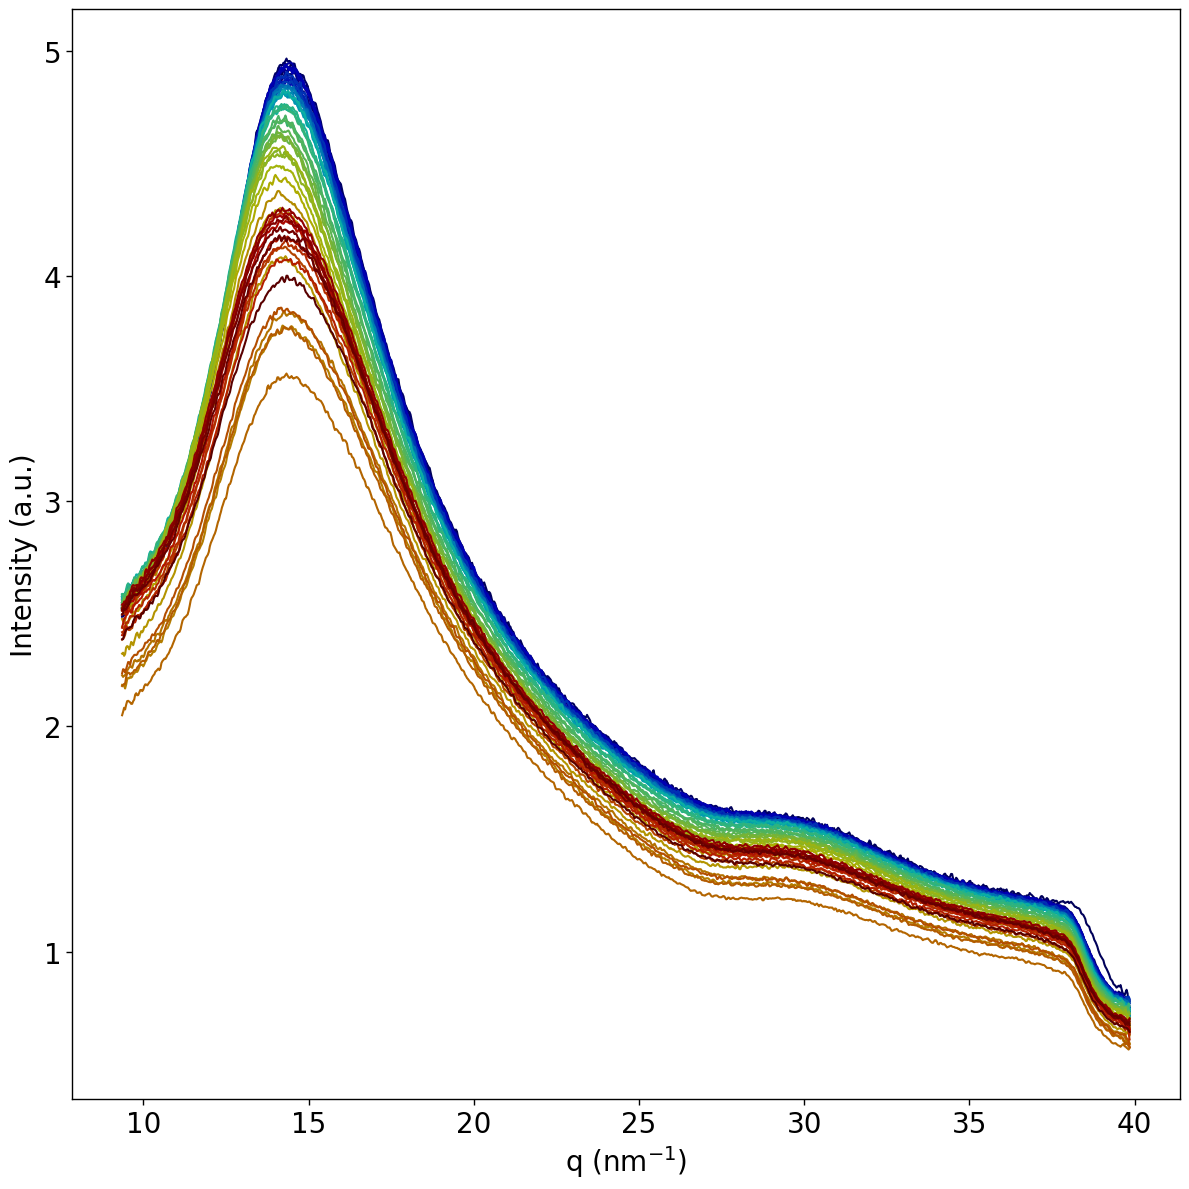

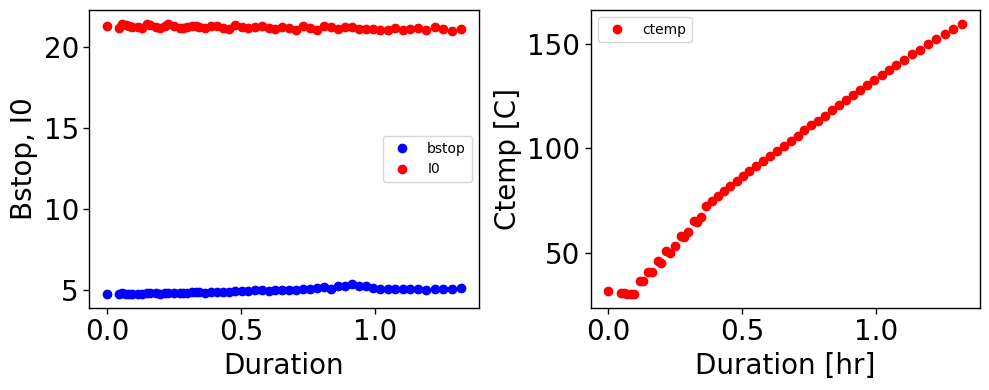

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:21.05704, bstop: 5.82064, transmission factor: 5.82064, thickness: -0.01500584608194922, normfactor: 122.5654493056


i0:21.23013333333333, bstop: 5.858709999999999, transmission factor: 5.858709999999999, thickness: -0.015061384782285437, normfactor: 124.38119446133331
i0:21.142776666666666, bstop: 5.845656666666667, transmission factor: 5.845656666666667, thickness: -0.015042382592084787, normfactor: 123.59341337334445
i0:21.105406666666667, bstop: 5.828586666666666, transmission factor: 5.828586666666666, thickness: -0.015017469073951623, normfactor: 123.01469189191111
i0:21.056683333333336, bstop: 5.819653333333332, transmission factor: 5.819653333333332, thickness: -0.015004401851478034, normfactor: 122.54259734977776


i0:21.019013333333334, bstop: 5.808600000000001, transmission factor: 5.808600000000001, thickness: -0.014988205809856488, normfactor: 122.09104084800002
i0:21.163529999999998, bstop: 5.843023333333334, transmission factor: 5.843023333333334, thickness: -0.015038544014298525, normfactor: 123.6589996057
i0:21.209743333333332, bstop: 5.8690533333333335, transmission factor: 5.8690533333333335, thickness: -0.015076411890403792, normfactor: 124.48111480964444
i0:21.114103333333333, bstop: 5.849253333333333, transmission factor: 5.849253333333333, thickness: -0.015047622616260026, normfactor: 123.50173930284444


i0:21.086219999999997, bstop: 5.839876666666666, transmission factor: 5.839876666666666, thickness: -0.015033954887455878, normfactor: 123.14092416619998
i0:21.010003333333334, bstop: 5.814713333333334, transmission factor: 5.814713333333334, thickness: -0.01499716725689003, normfactor: 122.16714651571112
i0:21.0773, bstop: 5.829946666666667, transmission factor: 5.829946666666667, thickness: -0.015019456655528425, normfactor: 122.87953487733336


i0:21.20204, bstop: 5.8608, transmission factor: 5.8608, thickness: -0.015064423335228061, normfactor: 124.26091603200001
i0:21.14022, bstop: 5.852986666666666, transmission factor: 5.852986666666666, thickness: -0.015053058344711417, normfactor: 123.73342579039999
i0:21.116593333333334, bstop: 5.840673333333334, transmission factor: 5.840673333333334, thickness: -0.015035116986984585, normfactor: 123.33512357284447
i0:20.99325333333333, bstop: 5.81839, transmission factor: 5.81839, thickness: -0.0150025522934646, normfactor: 122.14693526213333
i0:21.046676666666666, bstop: 5.836336666666667, transmission factor: 5.836336666666667, thickness: -0.015028789163140443, normfactor: 122.83549074114445


i0:21.217789999999997, bstop: 5.875896666666667, transmission factor: 5.875896666666667, thickness: -0.015086339542342677, normfactor: 124.67354153503332
i0:21.086650000000002, bstop: 5.858896666666666, transmission factor: 5.858896666666666, thickness: -0.015061656212273532, normfactor: 123.54450339616668
i0:21.04447, bstop: 5.844206666666666, transmission factor: 5.844206666666666, thickness: -0.015040269158806458, normfactor: 122.98823187046665
i0:21.02475, bstop: 5.8358, transmission factor: 5.8358, thickness: -0.015028005761947405, normfactor: 122.69623605
i0:20.998166666666666, bstop: 5.829366666666668, transmission factor: 5.829366666666668, thickness: -0.015018609067154218, normfactor: 122.4060128277778


i0:21.152509999999996, bstop: 5.875213333333332, transmission factor: 5.875213333333332, thickness: -0.015085348747616727, normfactor: 124.27550878546661
i0:21.05377, bstop: 5.85263, transmission factor: 5.85263, thickness: -0.01505253918833053, normfactor: 123.2199259151
i0:20.961039999999997, bstop: 5.837153333333333, transmission factor: 5.837153333333333, thickness: -0.015029981157185313, normfactor: 122.35280450613331
i0:21.182846666666666, bstop: 5.893273333333333, transmission factor: 5.893273333333333, thickness: -0.015111496083045309, normfactor: 124.83630538475555
i0:21.10849333333333, bstop: 5.870686666666667, transmission factor: 5.870686666666667, thickness: -0.015078782425122608, normfactor: 123.92135036542221


i0:21.07555, bstop: 5.847393333333333, transmission factor: 5.847393333333333, thickness: -0.01504491316372113, normfactor: 123.23703056633332
i0:21.078623333333333, bstop: 5.854020000000001, transmission factor: 5.854020000000001, thickness: -0.015054562264055766, normfactor: 123.39468256580003
i0:21.15601, bstop: 5.8792599999999995, transmission factor: 5.8792599999999995, thickness: -0.015091214507014498, normfactor: 124.38168335259998
i0:21.05524, bstop: 5.85898, transmission factor: 5.85898, thickness: -0.015061777383583292, normfactor: 123.3622300552


i0:20.976583333333334, bstop: 5.83889, transmission factor: 5.83889, thickness: -0.015032515414709735, normfactor: 122.47996265916667
i0:21.130916666666664, bstop: 5.888283333333334, transmission factor: 5.888283333333334, thickness: -0.015104279562272144, normfactor: 124.42482442638888
i0:21.055186666666668, bstop: 5.866886666666666, transmission factor: 5.866886666666666, thickness: -0.015073266285325314, normfactor: 123.52839391884443
i0:20.961743333333335, bstop: 5.843926666666667, transmission factor: 5.843926666666667, thickness: -0.015039860987148808, normfactor: 122.49889084548892
i0:21.152676666666668, bstop: 5.8949, transmission factor: 5.8949, thickness: -0.015113847242197404, normfactor: 124.69291368233334


i0:21.08053, bstop: 5.878313333333334, transmission factor: 5.878313333333334, thickness: -0.015089842648380031, normfactor: 123.91796057273334
i0:20.969323333333335, bstop: 5.852883333333334, transmission factor: 5.852883333333334, thickness: -0.01505290793817397, normfactor: 122.73100304894446
i0:21.11234333333333, bstop: 5.895303333333334, transmission factor: 5.895303333333334, thickness: -0.015114430113658622, normfactor: 124.46366802747777
i0:21.053116666666668, bstop: 5.881466666666667, transmission factor: 5.881466666666667, thickness: -0.015094411432797617, normfactor: 123.82320390444447
i0:20.97957, bstop: 5.858483333333333, transmission factor: 5.858483333333333, thickness: -0.01506105517710178, normfactor: 122.90846118549999


i0:21.018839999999997, bstop: 5.862003333333334, transmission factor: 5.862003333333334, thickness: -0.015066172313606251, normfactor: 123.2125101428
i0:21.06893666666667, bstop: 5.880766666666666, transmission factor: 5.880766666666666, thickness: -0.015093397432176506, normfactor: 123.90150045144445
i0:21.015649999999997, bstop: 5.859543333333334, transmission factor: 5.859543333333334, thickness: -0.015062596456436256, normfactor: 123.14211185316665
i0:20.869383333333335, bstop: 5.834486666666667, transmission factor: 5.834486666666667, thickness: -0.015026088314738532, normfactor: 121.7621387998889
i0:21.056323333333335, bstop: 5.892599999999999, transmission factor: 5.892599999999999, thickness: -0.01511052266741192, normfactor: 124.07649087399999


i0:20.996579999999998, bstop: 5.86971, transmission factor: 5.86971, thickness: -0.015077365021406148, normfactor: 123.24383559179999
i0:20.872556666666668, bstop: 5.842196666666667, transmission factor: 5.842196666666667, thickness: -0.015037338635621936, normfactor: 121.94158098281113
i0:21.063390000000002, bstop: 5.890350000000001, transmission factor: 5.890350000000001, thickness: -0.015107269110113068, normfactor: 124.07073928650003
i0:20.930443333333333, bstop: 5.86797, transmission factor: 5.86797, thickness: -0.015074839233048443, normfactor: 122.81921356669999
i0:20.85574, bstop: 5.8409699999999996, transmission factor: 5.8409699999999996, thickness: -0.015035549694841357, normfactor: 121.8177516678


i0:21.03934, bstop: 5.894156666666667, transmission factor: 5.894156666666667, thickness: -0.015112772920060585, normfactor: 124.00916612326668
i0:20.91705, bstop: 5.8638, transmission factor: 5.8638, thickness: -0.015068783001041275, normfactor: 122.65339779
i0:20.87512, bstop: 5.850376666666667, transmission factor: 5.850376666666667, thickness: -0.015049258552943822, normfactor: 122.12731496186666
i0:20.95991666666667, bstop: 5.887376666666667, transmission factor: 5.887376666666667, thickness: -0.01510296768755166, normfactor: 123.39892431861114
i0:20.824763333333333, bstop: 5.856280000000001, transmission factor: 5.856280000000001, thickness: -0.015057850556195355, normfactor: 121.95564501373335


i0:21.03117333333333, bstop: 5.906739999999999, transmission factor: 5.906739999999999, thickness: -0.01513094107518213, normfactor: 124.2256727749333
i0:20.92202, bstop: 5.871293333333334, transmission factor: 5.871293333333334, thickness: -0.015079662741473163, normfactor: 122.83931654586668


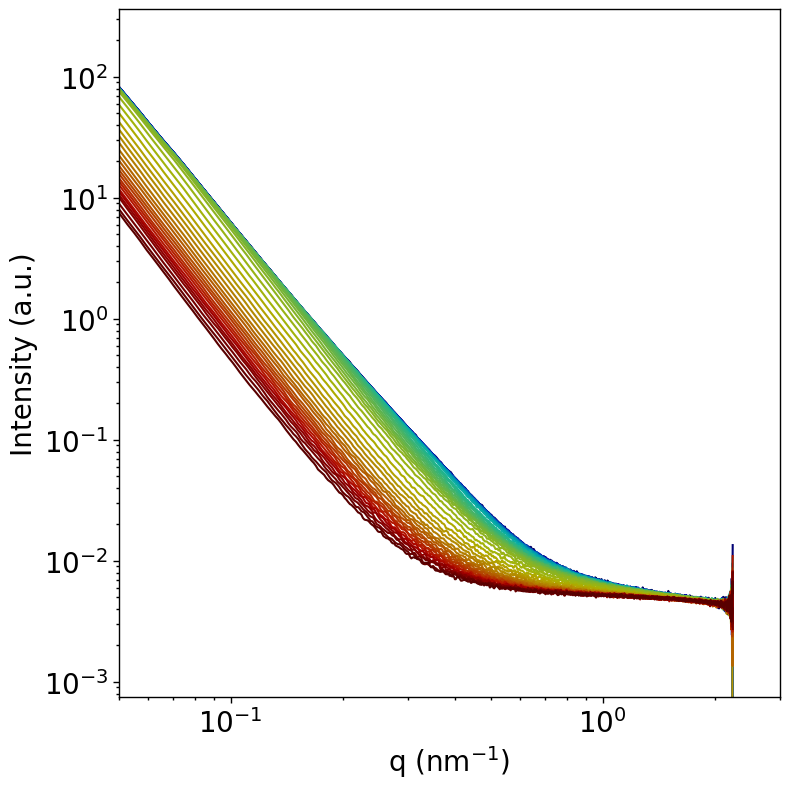

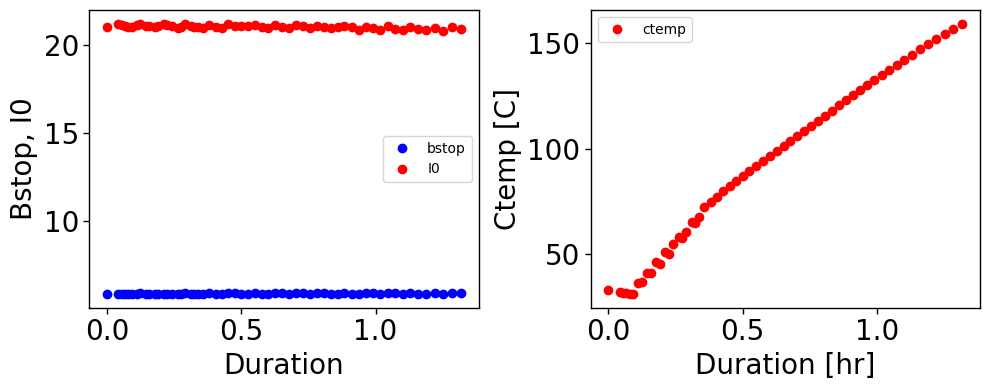

Processing WAXS data...
i0:21.05704, bstop: 5.82064, transmission factor: 0.27642251712491406, thickness: 0.0109542272852341, normfactor: 122.5654493056
i0:21.23013333333333, bstop: 5.858709999999999, transmission factor: 0.2759619974124829, thickness: 0.010968432140114486, normfactor: 124.38119446133331
i0:21.142776666666666, bstop: 5.845656666666667, transmission factor: 0.27648481364715105, thickness: 0.010952307549596516, normfactor: 123.59341337334445
i0:21.105406666666667, bstop: 5.828586666666666, transmission factor: 0.27616557021249843, thickness: 0.010962149961083778, normfactor: 123.01469189191111


i0:21.056683333333336, bstop: 5.819653333333332, transmission factor: 0.2763803416334164, thickness: 0.010955527214866936, normfactor: 122.54259734977776
i0:21.019013333333334, bstop: 5.808600000000001, transmission factor: 0.27634979377401797, thickness: 0.010956468882430369, normfactor: 122.09104084800002
i0:21.163529999999998, bstop: 5.843023333333334, transmission factor: 0.27608925984149785, thickness: 0.010964504327291959, normfactor: 123.6589996057
i0:21.209743333333332, bstop: 5.8690533333333335, transmission factor: 0.27671496260445083, thickness: 0.010945219006046645, normfactor: 124.48111480964444
i0:21.114103333333333, bstop: 5.849253333333333, transmission factor: 0.2770306292902801, thickness: 0.010935506115681939, normfactor: 123.50173930284444
i0:21.086219999999997, bstop: 5.839876666666666, transmission factor: 0.2769522781544851, thickness: 0.010937915904057571, normfactor: 123.14092416619998
i0:21.010003333333334, bstop: 5.814713333333334, transmission factor: 0.2767

i0:20.99325333333333, bstop: 5.81839, transmission factor: 0.2771552320936123, thickness: 0.010931675202147636, normfactor: 122.14693526213333
i0:21.046676666666666, bstop: 5.836336666666667, transmission factor: 0.27730442953543105, thickness: 0.010927090391516125, normfactor: 122.83549074114445
i0:21.217789999999997, bstop: 5.875896666666667, transmission factor: 0.27693254889725405, thickness: 0.010938522809787757, normfactor: 124.67354153503332
i0:21.086650000000002, bstop: 5.858896666666666, transmission factor: 0.27784862302293944, thickness: 0.010910388305419589, normfactor: 123.54450339616668
i0:21.04447, bstop: 5.844206666666666, transmission factor: 0.27770747691277875, thickness: 0.010914717139835972, normfactor: 122.98823187046665
i0:21.02475, bstop: 5.8358, transmission factor: 0.27756810425807676, thickness: 0.010918993743237954, normfactor: 122.69623605
i0:20.998166666666666, bstop: 5.829366666666668, transmission factor: 0.2776131249553533, thickness: 0.0109176120634171

i0:21.182846666666666, bstop: 5.893273333333333, transmission factor: 0.27820969608428453, thickness: 0.010899324493671864, normfactor: 124.83630538475555
i0:21.10849333333333, bstop: 5.870686666666667, transmission factor: 0.27811964473068346, thickness: 0.010902082455524159, normfactor: 123.92135036542221
i0:21.07555, bstop: 5.847393333333333, transmission factor: 0.2774491452575773, thickness: 0.010922645659438058, normfactor: 123.23703056633332
i0:21.078623333333333, bstop: 5.854020000000001, transmission factor: 0.2777230707824531, thickness: 0.010914238780659152, normfactor: 123.39468256580003
i0:21.15601, bstop: 5.8792599999999995, transmission factor: 0.27790022787850827, thickness: 0.010908806176147869, normfactor: 124.38168335259998
i0:21.05524, bstop: 5.85898, transmission factor: 0.27826707270969125, thickness: 0.010897567711418482, normfactor: 123.3622300552
i0:20.976583333333334, bstop: 5.83889, transmission factor: 0.27835276637838224, thickness: 0.010894944580121722, no

i0:21.152676666666668, bstop: 5.8949, transmission factor: 0.27868340696992955, thickness: 0.010884831049528988, normfactor: 124.69291368233334
i0:21.08053, bstop: 5.878313333333334, transmission factor: 0.27885035781042194, thickness: 0.010879728967697292, normfactor: 123.91796057273334
i0:20.969323333333335, bstop: 5.852883333333334, transmission factor: 0.2791164617138337, thickness: 0.010871603041465632, normfactor: 122.73100304894446
i0:21.11234333333333, bstop: 5.895303333333334, transmission factor: 0.27923491202539813, thickness: 0.01086798845518488, normfactor: 124.46366802747777
i0:21.053116666666668, bstop: 5.881466666666667, transmission factor: 0.27936322967224964, thickness: 0.010864074490716618, normfactor: 123.82320390444447
i0:20.97957, bstop: 5.858483333333333, transmission factor: 0.2792470643265488, thickness: 0.010867617706744685, normfactor: 122.90846118549999
i0:21.018839999999997, bstop: 5.862003333333334, transmission factor: 0.2788928091813504, thickness: 0.01

i0:21.056323333333335, bstop: 5.892599999999999, transmission factor: 0.27984942607105984, thickness: 0.010849260747010118, normfactor: 124.07649087399999
i0:20.996579999999998, bstop: 5.86971, transmission factor: 0.27955552761449726, thickness: 0.010858212354034447, normfactor: 123.24383559179999
i0:20.872556666666668, bstop: 5.842196666666667, transmission factor: 0.2798984695534024, thickness: 0.01084776788797017, normfactor: 121.94158098281113
i0:21.063390000000002, bstop: 5.890350000000001, transmission factor: 0.27964871751413234, thickness: 0.010855372942388081, normfactor: 124.07073928650003
i0:20.930443333333333, bstop: 5.86797, transmission factor: 0.28035574338049535, thickness: 0.010833861277794173, normfactor: 122.81921356669999
i0:20.85574, bstop: 5.8409699999999996, transmission factor: 0.28006534412109085, thickness: 0.010842690268217717, normfactor: 121.8177516678
i0:21.03934, bstop: 5.894156666666667, transmission factor: 0.2801493139360202, thickness: 0.010840136398

i0:21.03117333333333, bstop: 5.906739999999999, transmission factor: 0.28085641758456337, thickness: 0.010818660765357827, normfactor: 124.2256727749333
i0:20.92202, bstop: 5.871293333333334, transmission factor: 0.28062746012733636, thickness: 0.01082560856838735, normfactor: 122.83931654586668


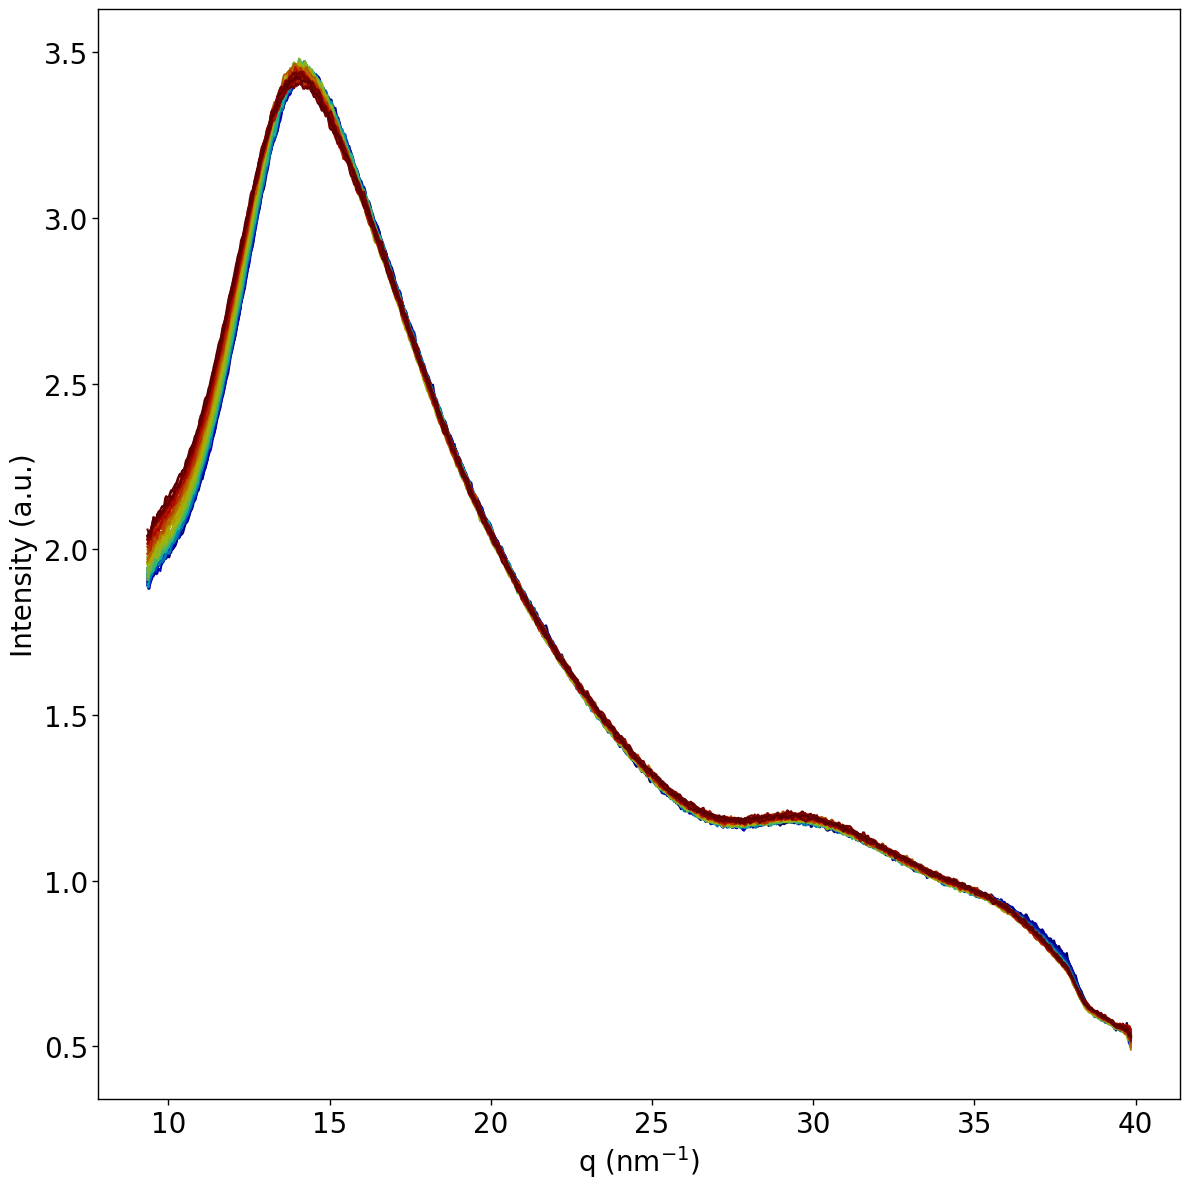

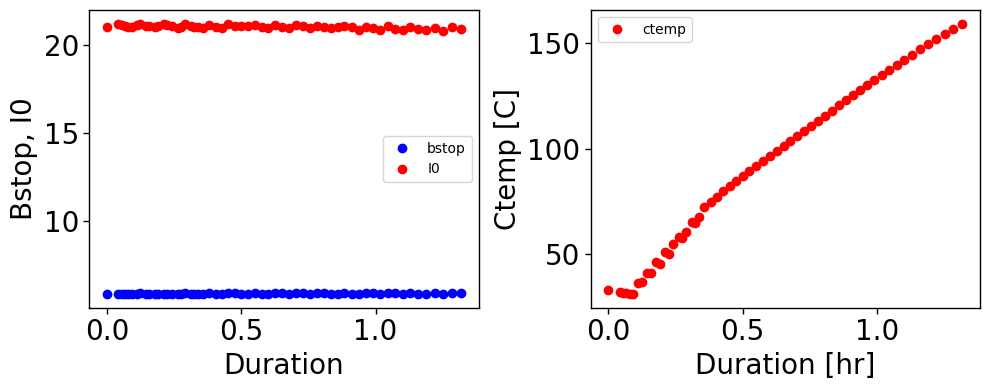

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:21.02577, bstop: 4.50954, transmission factor: 4.50954, thickness: -0.012831612055932728, normfactor: 94.81655084580001


i0:20.80592333333333, bstop: 4.479656666666666, transmission factor: 4.479656666666666, thickness: -0.012774969906173928, normfactor: 93.20339316632219
i0:20.87789666666667, bstop: 4.48876, transmission factor: 4.48876, thickness: -0.012792264676080725, normfactor: 93.71586744146667
i0:21.039330000000003, bstop: 4.517646666666667, transmission factor: 4.517646666666667, thickness: -0.012846913061760876, normfactor: 95.04825904340002
i0:20.999293333333334, bstop: 4.5087399999999995, transmission factor: 4.5087399999999995, thickness: -0.012830100597374858, normfactor: 94.68035382373333


i0:20.976256666666664, bstop: 4.50366, transmission factor: 4.50366, thickness: -0.01282049657263024, normfactor: 94.4699280994
i0:20.945543333333333, bstop: 4.49841, transmission factor: 4.49841, thickness: -0.012810559763726493, normfactor: 94.22164158609999
i0:20.838746666666665, bstop: 4.489443333333333, transmission factor: 4.489443333333333, thickness: -0.012793561476497147, normfactor: 93.55437229768887
i0:21.109063333333335, bstop: 4.5417966666666665, transmission factor: 4.5417966666666665, thickness: -0.012892333008637492, normfactor: 95.87307348378889
i0:21.023906666666665, bstop: 4.534473333333334, transmission factor: 4.534473333333334, thickness: -0.012878585263871048, normfactor: 95.33234414248889


i0:20.948066666666666, bstop: 4.527923333333334, transmission factor: 4.527923333333334, thickness: -0.012866270437898175, normfactor: 94.85123984822222
i0:20.908166666666666, bstop: 4.51907, transmission factor: 4.51907, thickness: -0.01284959671209627, normfactor: 94.48546873833334
i0:20.84386333333333, bstop: 4.5101233333333335, transmission factor: 4.5101233333333335, thickness: -0.012832713992101464, normfactor: 94.00839437647777
i0:21.032529999999998, bstop: 4.54782, transmission factor: 4.54782, thickness: -0.01290362372153238, normfactor: 95.65216058459998
i0:21.008453333333335, bstop: 4.551233333333333, transmission factor: 4.551233333333333, thickness: -0.012910015364132273, normfactor: 95.61437309244445


i0:20.93562, bstop: 4.54007, transmission factor: 4.54007, thickness: -0.01288909361772443, normfactor: 95.0491802934
i0:20.924903333333333, bstop: 4.532563333333334, transmission factor: 4.532563333333334, thickness: -0.012874996061279712, normfactor: 94.84344960221112
i0:20.87651333333333, bstop: 4.525996666666667, transmission factor: 4.525996666666667, thickness: -0.012862644670760122, normfactor: 94.48702975828888
i0:21.07784666666667, bstop: 4.57556, transmission factor: 4.57556, thickness: -0.012955429953032687, normfactor: 96.44295209413335
i0:21.03502333333333, bstop: 4.568883333333333, transmission factor: 4.568883333333333, thickness: -0.012942989606738632, normfactor: 96.10656752394443


i0:20.98246333333333, bstop: 4.55948, transmission factor: 4.55948, thickness: -0.01292543791276042, normfactor: 95.66912191906665
i0:20.923180000000002, bstop: 4.553593333333334, transmission factor: 4.553593333333334, thickness: -0.012914431783454989, normfactor: 95.27565296013334
i0:20.85607333333333, bstop: 4.547203333333333, transmission factor: 4.547203333333333, thickness: -0.012902468469801925, normfactor: 94.83680618157776
i0:21.026706666666666, bstop: 4.592406666666666, transmission factor: 4.592406666666666, thickness: -0.012986739113108171, normfactor: 96.56318787404443
i0:20.963886666666667, bstop: 4.582903333333333, transmission factor: 4.582903333333333, thickness: -0.01296909152566592, normfactor: 96.07546608428889


i0:20.891189999999998, bstop: 4.56999, transmission factor: 4.56999, thickness: -0.012945052867619572, normfactor: 95.47252938809999
i0:20.92907, bstop: 4.5894699999999995, transmission factor: 4.5894699999999995, thickness: -0.012981289656679097, normfactor: 96.05333889289999
i0:20.972559999999998, bstop: 4.61363, transmission factor: 4.61363, thickness: -0.013026019127223797, normfactor: 96.75963199279998
i0:20.91865, bstop: 4.59513, transmission factor: 4.59513, thickness: -0.012991789581996892, normfactor: 96.1239161745


i0:20.845016666666666, bstop: 4.58144, transmission factor: 4.58144, thickness: -0.01296637088059183, normfactor: 95.50019315733333
i0:21.010133333333332, bstop: 4.625733333333334, transmission factor: 4.625733333333334, thickness: -0.01304833907467129, normfactor: 97.18727409777777
i0:20.903373333333334, bstop: 4.607236666666666, transmission factor: 4.607236666666666, thickness: -0.013014205435155917, normfactor: 96.30678807835555
i0:20.8261, bstop: 4.597266666666667, transmission factor: 4.597266666666667, thickness: -0.012995749972377582, normfactor: 95.74313532666667


i0:21.030466666666666, bstop: 4.638656666666667, transmission factor: 4.638656666666667, thickness: -0.013072106819149762, normfactor: 97.55311440644445
i0:20.94466, bstop: 4.6298933333333325, transmission factor: 4.6298933333333325, thickness: -0.013055997112409033, normfactor: 96.97154170293331
i0:20.837413333333334, bstop: 4.617536666666666, transmission factor: 4.617536666666666, thickness: -0.013033229865984784, normfactor: 96.21752010515554
i0:21.029483333333335, bstop: 4.659986666666667, transmission factor: 4.659986666666667, thickness: -0.01311119108856405, normfactor: 97.99711194022223


i0:20.934026666666664, bstop: 4.64857, transmission factor: 4.64857, thickness: -0.013090293933616128, normfactor: 97.31328834186667
i0:20.80149, bstop: 4.632973333333333, transmission factor: 4.632973333333333, thickness: -0.01306166257388499, normfactor: 96.3727484636
i0:20.883960000000002, bstop: 4.642650000000001, transmission factor: 4.642650000000001, thickness: -0.013079437704685878, normfactor: 96.95691689400002
i0:20.949136666666664, bstop: 4.661526666666666, transmission factor: 4.661526666666666, thickness: -0.013114005996987374, normfactor: 97.6549592153111
i0:20.855413333333335, bstop: 4.650403333333333, transmission factor: 4.650403333333333, thickness: -0.013093653137850526, normfactor: 96.98608368337779


i0:20.761776666666666, bstop: 4.6380566666666665, transmission factor: 4.6380566666666665, thickness: -0.01307100480521632, normfactor: 96.29429668067777
i0:20.9706, bstop: 4.67649, transmission factor: 4.67649, thickness: -0.013141308599638751, normfactor: 98.06880119400002
i0:20.846723333333333, bstop: 4.6628533333333335, transmission factor: 4.6628533333333335, thickness: -0.013116430215855329, normfactor: 97.20521338391111
i0:20.733896666666666, bstop: 4.6456566666666665, transmission factor: 4.6456566666666665, thickness: -0.013084953126381454, normfactor: 96.32256527547777


i0:20.920103333333333, bstop: 4.685243333333333, transmission factor: 4.685243333333333, thickness: -0.013157239755933779, normfactor: 98.01577467514444
i0:20.834466666666668, bstop: 4.67155, transmission factor: 4.67155, thickness: -0.013132304580732283, normfactor: 97.32925275666666
i0:20.738666666666663, bstop: 4.667306666666667, transmission factor: 4.667306666666667, thickness: -0.013124562754131187, normfactor: 96.7937171911111
i0:20.92101, bstop: 4.717290000000001, transmission factor: 4.717290000000001, thickness: -0.013215312137101809, normfactor: 98.69047126290002
i0:20.805139999999998, bstop: 4.6992166666666675, transmission factor: 4.6992166666666675, thickness: -0.013182609788437888, normfactor: 97.76786064033334


i0:20.67779333333333, bstop: 4.6795800000000005, transmission factor: 4.6795800000000005, thickness: -0.013146935834010949, normfactor: 96.7633881268
i0:20.879413333333332, bstop: 4.715623333333333, transmission factor: 4.715623333333333, thickness: -0.0132123016769653, normfactor: 98.45944870097777
i0:20.76327, bstop: 4.696983333333333, transmission factor: 4.696983333333333, thickness: -0.013178560009896293, normfactor: 97.52473313549999
i0:20.768496666666667, bstop: 4.7005799999999995, transmission factor: 4.7005799999999995, thickness: -0.013185081020717252, normfactor: 97.62398006139999
i0:20.83052, bstop: 4.7135533333333335, transmission factor: 4.7135533333333335, thickness: -0.013208561203738286, normfactor: 98.18576698106666


i0:20.747903333333333, bstop: 4.685743333333333, transmission factor: 4.685743333333333, thickness: -0.013158148862209436, normfactor: 97.2193497248111
i0:20.88469, bstop: 4.72222, transmission factor: 4.72222, thickness: -0.013224210855811271, normfactor: 98.6221008118


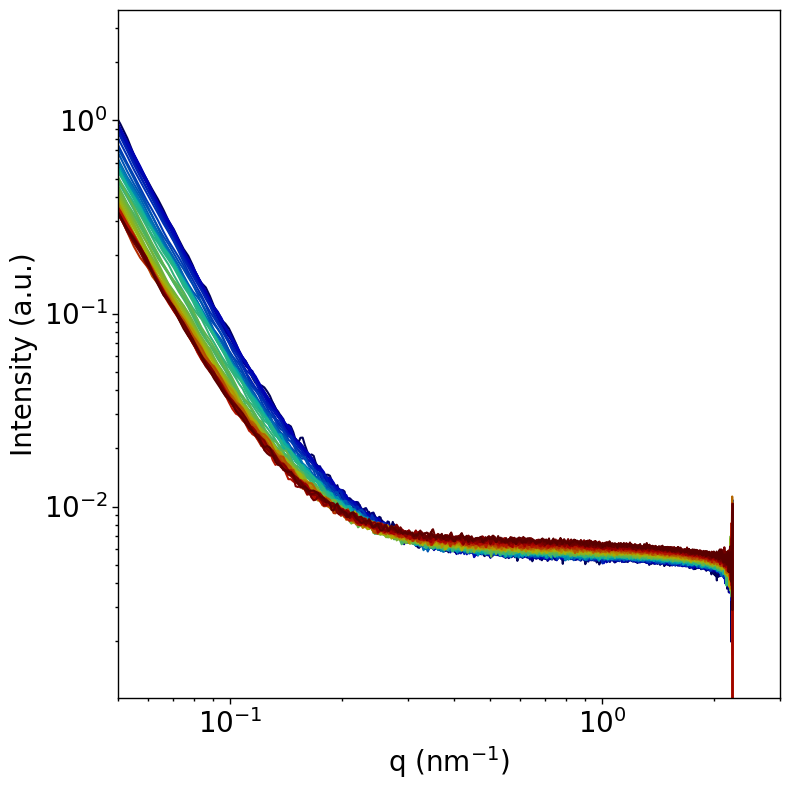

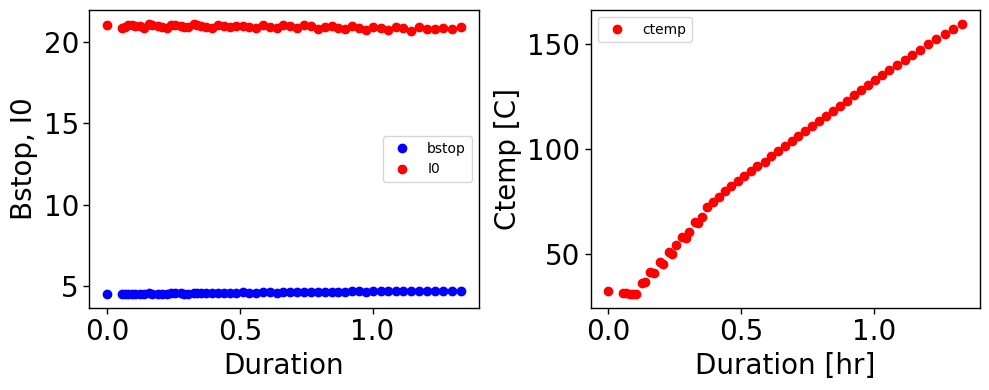

Processing WAXS data...
i0:21.02577, bstop: 4.50954, transmission factor: 0.2144768063191027, thickness: 0.013115800742940173, normfactor: 94.81655084580001
i0:20.80592333333333, bstop: 4.479656666666666, transmission factor: 0.21530679484384016, thickness: 0.01308289643520095, normfactor: 93.20339316632219
i0:20.87789666666667, bstop: 4.48876, transmission factor: 0.21500058514834428, thickness: 0.013095021112465865, normfactor: 93.71586744146667
i0:21.039330000000003, bstop: 4.517646666666667, transmission factor: 0.2147238845850446, thickness: 0.01310599220782499, normfactor: 95.04825904340002


i0:20.999293333333334, bstop: 4.5087399999999995, transmission factor: 0.21470912989452975, thickness: 0.013106577623903177, normfactor: 94.68035382373333
i0:20.976256666666664, bstop: 4.50366, transmission factor: 0.21470275042718936, thickness: 0.013106830751988277, normfactor: 94.4699280994
i0:20.945543333333333, bstop: 4.49841, transmission factor: 0.21476692814366397, thickness: 0.01310428461522711, normfactor: 94.22164158609999
i0:20.838746666666665, bstop: 4.489443333333333, transmission factor: 0.21543730077176745, thickness: 0.0130777341631261, normfactor: 93.55437229768887
i0:21.109063333333335, bstop: 4.5417966666666665, transmission factor: 0.21515860722700625, thickness: 0.013088761916444251, normfactor: 95.87307348378889
i0:21.023906666666665, bstop: 4.534473333333334, transmission factor: 0.2156817667252455, thickness: 0.01306807251603152, normfactor: 95.33234414248889
i0:20.948066666666666, bstop: 4.527923333333334, transmission factor: 0.21614993905563284, thickness: 0

i0:20.924903333333333, bstop: 4.532563333333334, transmission factor: 0.2166109568646355, thickness: 0.013031449230183125, normfactor: 94.84344960221112
i0:20.87651333333333, bstop: 4.525996666666667, transmission factor: 0.2167984947678045, thickness: 0.01302407663011441, normfactor: 94.48702975828888
i0:21.07784666666667, bstop: 4.57556, transmission factor: 0.217079100743055, thickness: 0.013013057185116543, normfactor: 96.44295209413335
i0:21.03502333333333, bstop: 4.568883333333333, transmission factor: 0.21720362563578488, thickness: 0.013008171633528059, normfactor: 96.10656752394443
i0:20.98246333333333, bstop: 4.55948, transmission factor: 0.21729955761470016, thickness: 0.013004409792672299, normfactor: 95.66912191906665
i0:20.923180000000002, bstop: 4.553593333333334, transmission factor: 0.21763390332317234, thickness: 0.012991311852905432, normfactor: 95.27565296013334
i0:20.85607333333333, bstop: 4.547203333333333, transmission factor: 0.2180277783194088, thickness: 0.012

i0:20.845016666666666, bstop: 4.58144, transmission factor: 0.21978586408741976, thickness: 0.012907487652731984, normfactor: 95.50019315733333
i0:21.010133333333332, bstop: 4.625733333333334, transmission factor: 0.22016677666649748, thickness: 0.012892735701585422, normfactor: 97.18727409777777
i0:20.903373333333334, bstop: 4.607236666666666, transmission factor: 0.22040637141182312, thickness: 0.012883469765963176, normfactor: 96.30678807835555
i0:20.8261, bstop: 4.597266666666667, transmission factor: 0.22074544281774633, thickness: 0.012870373932189278, normfactor: 95.74313532666667
i0:21.030466666666666, bstop: 4.638656666666667, transmission factor: 0.22056841344462164, thickness: 0.012877208762900758, normfactor: 97.55311440644445
i0:20.94466, bstop: 4.6298933333333325, transmission factor: 0.22105364008455294, thickness: 0.012858487979033039, normfactor: 96.97154170293331
i0:20.837413333333334, bstop: 4.617536666666666, transmission factor: 0.22159836217675127, thickness: 0.01

i0:20.855413333333335, bstop: 4.650403333333333, transmission factor: 0.22298303366160407, thickness: 0.012784453386265451, normfactor: 96.98608368337779
i0:20.761776666666666, bstop: 4.6380566666666665, transmission factor: 0.22339401589427238, thickness: 0.012768765974955153, normfactor: 96.29429668067777
i0:20.9706, bstop: 4.67649, transmission factor: 0.22300220308431803, thickness: 0.012783721036540378, normfactor: 98.06880119400002
i0:20.846723333333333, bstop: 4.6628533333333335, transmission factor: 0.22367320076040728, thickness: 0.01275812579248642, normfactor: 97.20521338391111
i0:20.733896666666666, bstop: 4.6456566666666665, transmission factor: 0.22406095397086478, thickness: 0.012743369907663366, normfactor: 96.32256527547777
i0:20.920103333333333, bstop: 4.685243333333333, transmission factor: 0.2239589001392759, thickness: 0.012747251072008593, normfactor: 98.01577467514444
i0:20.834466666666668, bstop: 4.67155, transmission factor: 0.2242222023121942, thickness: 0.012

i0:20.83052, bstop: 4.7135533333333335, transmission factor: 0.22628111700203996, thickness: 0.01265937057505493, normfactor: 98.18576698106666
i0:20.747903333333333, bstop: 4.685743333333333, transmission factor: 0.22584177581959686, thickness: 0.012675927341575799, normfactor: 97.2193497248111
i0:20.88469, bstop: 4.72222, transmission factor: 0.22610917375359654, thickness: 0.012665846500552979, normfactor: 98.6221008118


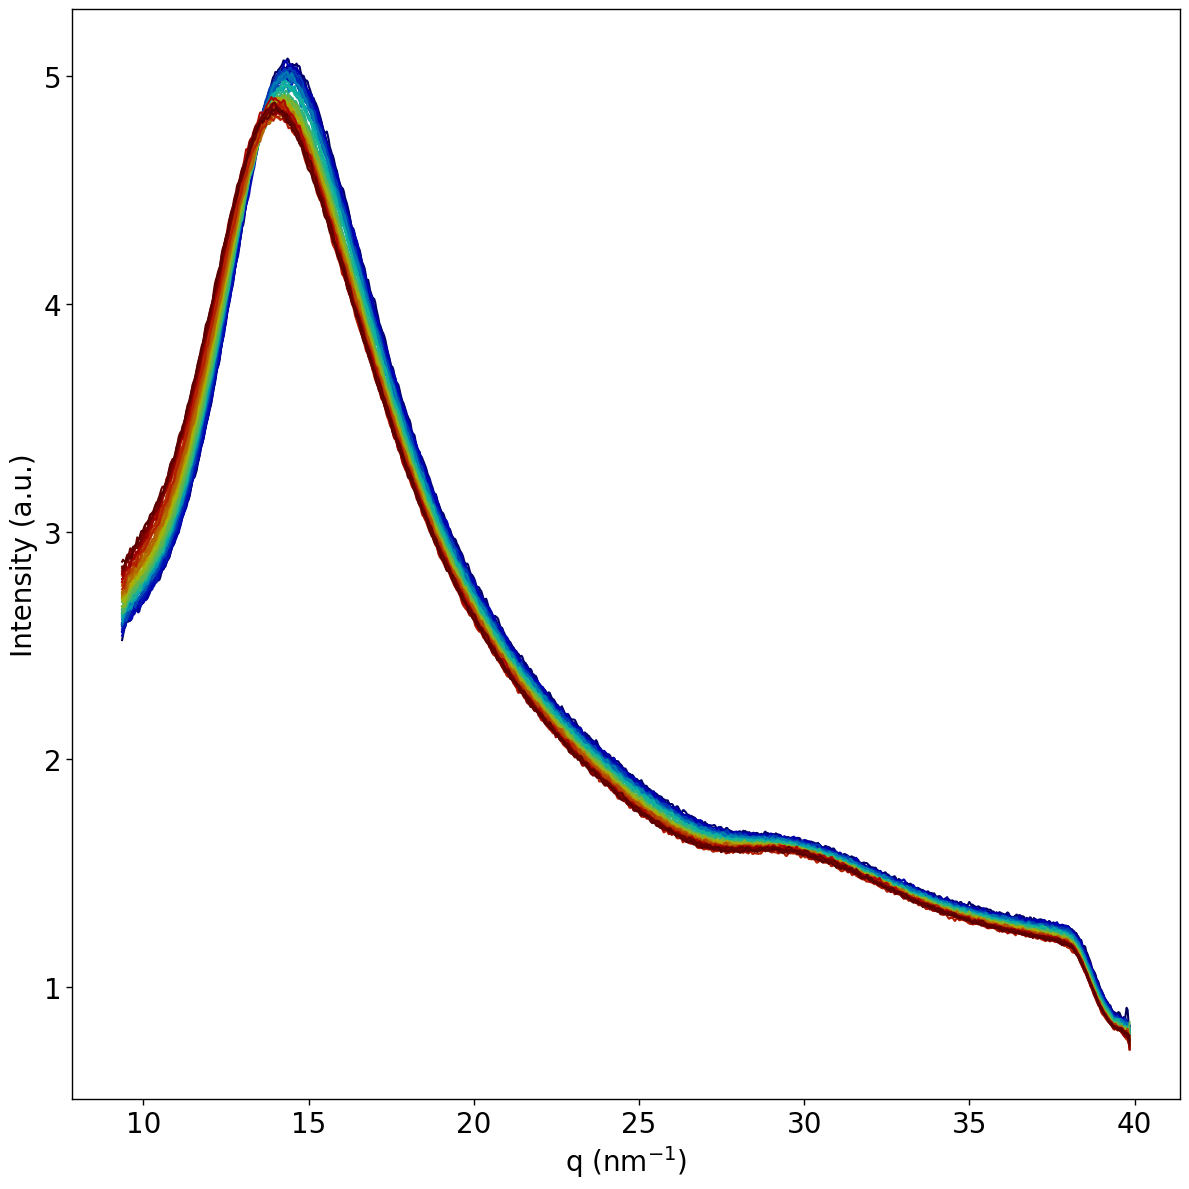

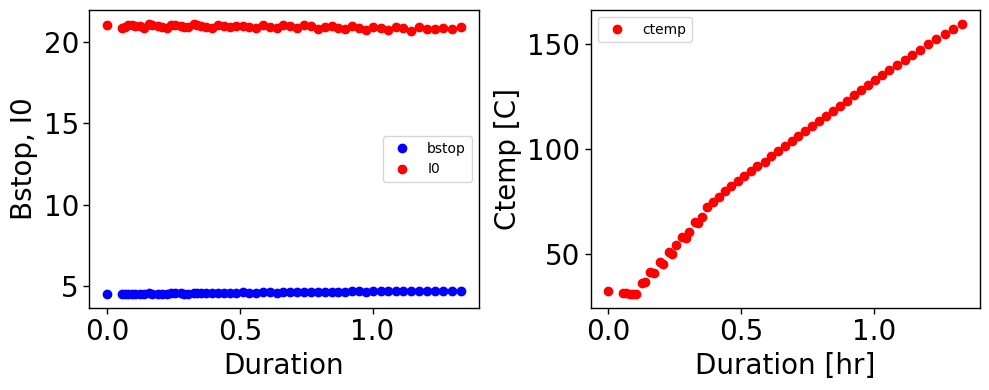

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
58
i0:20.81616, bstop: 4.10896, transmission factor: 4.10896, thickness: -0.012039109673266615, normfactor: 85.5327687936


i0:20.767226666666666, bstop: 4.1611400000000005, transmission factor: 4.1611400000000005, thickness: -0.01214661476840764, normfactor: 86.41533757173335
i0:21.005726666666668, bstop: 4.203413333333333, transmission factor: 4.203413333333333, thickness: -0.012232725525586578, normfactor: 88.29575154702222
i0:20.951330000000002, bstop: 4.194793333333334, transmission factor: 4.194793333333334, thickness: -0.012215237095243248, normfactor: 87.88649940846669
i0:20.900686666666665, bstop: 4.187196666666666, transmission factor: 4.187196666666666, thickness: -0.012199795007281812, normfactor: 87.5152855417111
i0:20.809596666666668, bstop: 4.18037, transmission factor: 4.18037, thickness: -0.012185894214041378, normfactor: 86.99181361743334


i0:20.775199999999998, bstop: 4.17499, transmission factor: 4.17499, thickness: -0.012174923190676989, normfactor: 86.736252248
i0:20.937536666666663, bstop: 4.2221400000000004, transmission factor: 4.2221400000000004, thickness: -0.01227059530140908, normfactor: 88.4012110618
i0:20.958940000000002, bstop: 4.2115, transmission factor: 4.2115, thickness: -0.01224909934510363, normfactor: 88.26857581
i0:20.836413333333336, bstop: 4.206213333333333, transmission factor: 4.206213333333333, thickness: -0.012238398506233655, normfactor: 87.64239958151113
i0:20.82045666666667, bstop: 4.202590000000001, transmission factor: 4.202590000000001, thickness: -0.012231056680159596, normfactor: 87.4998429827667


i0:20.828276666666667, bstop: 4.2106666666666674, transmission factor: 4.2106666666666674, thickness: -0.012247413471949953, normfactor: 87.70093028444447
i0:20.97756, bstop: 4.237513333333333, transmission factor: 4.237513333333333, thickness: -0.012301558507711674, normfactor: 88.8926902008
i0:20.907236666666666, bstop: 4.230823333333333, transmission factor: 4.230823333333333, thickness: -0.012288098104684233, normfactor: 88.45482472485556
i0:20.81612, bstop: 4.22635, transmission factor: 4.22635, thickness: -0.012279085796366444, normfactor: 87.97620876200001
i0:20.786126666666664, bstop: 4.217973333333333, transmission factor: 4.217973333333333, thickness: -0.012262183858798348, normfactor: 87.67532798328888


i0:20.774559999999997, bstop: 4.213076666666666, transmission factor: 4.213076666666666, thickness: -0.012252288104674802, normfactor: 87.52481399626664
i0:20.961956666666666, bstop: 4.255883333333334, transmission factor: 4.255883333333334, thickness: -0.01233841028153916, normfactor: 89.21164201172223
i0:20.910853333333336, bstop: 4.2468900000000005, transmission factor: 4.2468900000000005, thickness: -0.012320388811186916, normfactor: 88.80609391280002
i0:20.870703333333335, bstop: 4.244386666666666, transmission factor: 4.244386666666666, thickness: -0.01231536566665553, normfactor: 88.58333495195555


i0:20.795393333333333, bstop: 4.241813333333333, transmission factor: 4.241813333333333, thickness: -0.012310198972345941, normfactor: 88.21017671324444
i0:20.83084666666667, bstop: 4.253616666666667, transmission factor: 4.253616666666667, thickness: -0.012333871768405056, normfactor: 88.60643656211113
i0:20.927456666666668, bstop: 4.27199, transmission factor: 4.27199, thickness: -0.012370590976389687, normfactor: 89.40188560543334
i0:20.854896666666665, bstop: 4.260233333333333, transmission factor: 4.260233333333333, thickness: -0.012347113455477508, normfactor: 88.84672594255554


i0:20.753383333333336, bstop: 4.25047, transmission factor: 4.25047, thickness: -0.012327567233510032, normfactor: 88.21163325683334
i0:20.960873333333335, bstop: 4.293216666666667, transmission factor: 4.293216666666667, thickness: -0.012412816477642042, normfactor: 89.98957074255557
i0:20.877683333333334, bstop: 4.281076666666666, transmission factor: 4.281076666666666, thickness: -0.012388692405923404, normfactor: 89.37896297238889
i0:20.77370333333333, bstop: 4.271233333333333, transmission factor: 4.271233333333333, thickness: -0.012369081894473263, normfactor: 88.72933413411108


i0:20.797063333333334, bstop: 4.273476666666666, transmission factor: 4.273476666666666, thickness: -0.012373555178382224, normfactor: 88.87576489018889
i0:20.860863333333334, bstop: 4.300106666666667, transmission factor: 4.300106666666667, thickness: -0.01242647765510581, normfactor: 89.7039374920889
i0:20.805766666666667, bstop: 4.284916666666667, transmission factor: 4.284916666666667, thickness: -0.012396330473428795, normfactor: 89.15097635277777
i0:20.698603333333335, bstop: 4.27601, transmission factor: 4.27601, thickness: -0.01237860390996459, normfactor: 88.50743483936668


i0:20.900656666666666, bstop: 4.310926666666667, transmission factor: 4.310926666666667, thickness: -0.012447886941406324, normfactor: 90.10119817517779
i0:20.786640000000002, bstop: 4.299526666666667, transmission factor: 4.299526666666667, thickness: -0.012425328501641195, normfactor: 89.37271299040002
i0:20.675463333333337, bstop: 4.284823333333333, transmission factor: 4.284823333333333, thickness: -0.01239614490713169, normfactor: 88.59070771814444
i0:20.894936666666666, bstop: 4.3229766666666665, transmission factor: 4.3229766666666665, thickness: -0.012471666846551386, normfactor: 90.32832366147777


i0:20.80241333333333, bstop: 4.3136399999999995, transmission factor: 4.3136399999999995, thickness: -0.012453247324785158, normfactor: 89.73412225119998
i0:20.7178, bstop: 4.296436666666667, transmission factor: 4.296436666666667, thickness: -0.012419203673392797, normfactor: 89.01271557266666
i0:20.918836666666667, bstop: 4.3435999999999995, transmission factor: 4.3435999999999995, thickness: -0.012512212291314606, normfactor: 90.86305894533332
i0:20.808609999999998, bstop: 4.326630000000001, transmission factor: 4.326630000000001, thickness: -0.012478863373192494, normfactor: 90.03115628430001


i0:20.714996666666664, bstop: 4.31677, transmission factor: 4.31677, thickness: -0.012459426676280512, normfactor: 89.42187616076666
i0:20.629423333333335, bstop: 4.308696666666666, transmission factor: 4.308696666666666, thickness: -0.012443478890964239, normfactor: 88.88592755158889
i0:20.55781, bstop: 4.29896, transmission factor: 4.29896, thickness: -0.012424205615773183, normfactor: 88.3772028776
i0:20.483430000000002, bstop: 4.28034, transmission factor: 4.28034, thickness: -0.01238722633372822, normfactor: 87.67604476620001


i0:20.505570000000002, bstop: 4.296003333333334, transmission factor: 4.296003333333334, thickness: -0.012418344391696874, normfactor: 88.09199707190002
i0:20.861353333333334, bstop: 4.3559833333333335, transmission factor: 4.3559833333333335, thickness: -0.012536465509573737, normfactor: 90.87170743077779
i0:20.74536, bstop: 4.3404533333333335, transmission factor: 4.3404533333333335, thickness: -0.012506038410411074, normfactor: 90.04426696320002
i0:20.72923, bstop: 4.347956666666667, transmission factor: 4.347956666666667, thickness: -0.012520752859694255, normfactor: 90.12979377336667


i0:20.74663, bstop: 4.362496666666666, transmission factor: 4.362496666666666, thickness: -0.012549194459580625, normfactor: 90.50710421956666
i0:20.694836666666664, bstop: 4.35202, transmission factor: 4.35202, thickness: -0.012528710684350143, normfactor: 90.06434307006667
i0:20.732380000000003, bstop: 4.369783333333333, transmission factor: 4.369783333333333, thickness: -0.012563412224256712, normfactor: 90.59600858433335
i0:20.75709, bstop: 4.374739999999999, transmission factor: 4.374739999999999, thickness: -0.012573070143960457, normfactor: 90.8068719066


i0:20.615956666666666, bstop: 4.360373333333333, transmission factor: 4.360373333333333, thickness: -0.012545046937019938, normfactor: 89.89326769048888
i0:20.783126666666664, bstop: 4.399346666666666, transmission factor: 4.399346666666666, thickness: -0.012620854086095578, normfactor: 91.43217902391109
i0:20.70889, bstop: 4.379270000000001, transmission factor: 4.379270000000001, thickness: -0.012581887150712045, normfactor: 90.68982071030003
i0:20.57885333333333, bstop: 4.362753333333333, transmission factor: 4.362753333333333, thickness: -0.01254969567169812, normfactor: 89.78046097617776


i0:20.70726, bstop: 4.402163333333333, transmission factor: 4.402163333333333, thickness: -0.012626306744025546, normfactor: 91.1567407058
i0:20.60725, bstop: 4.38464, transmission factor: 4.38464, thickness: -0.012592327292624113, normfactor: 90.35537264


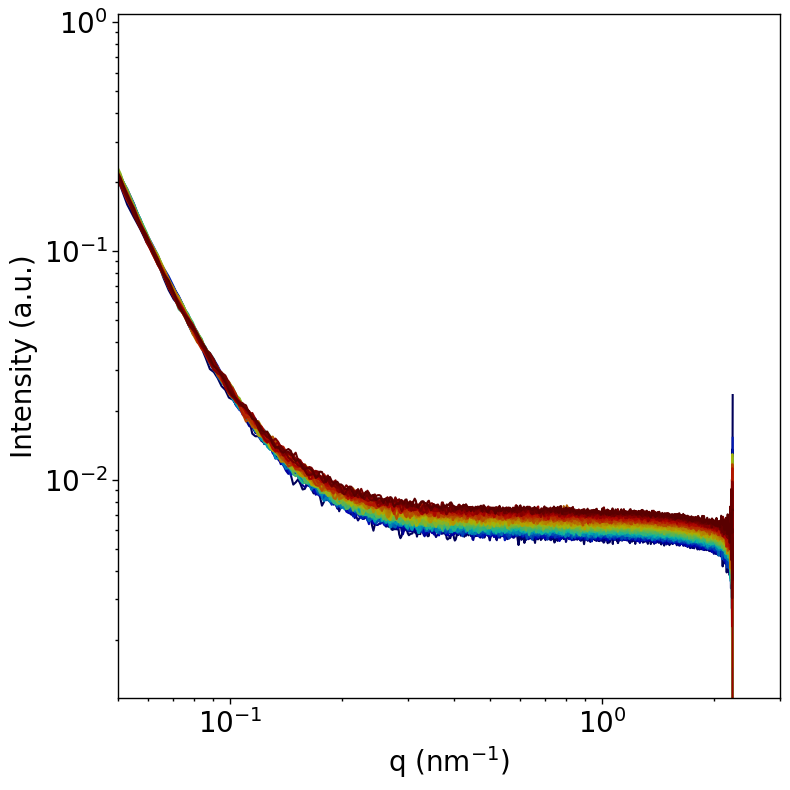

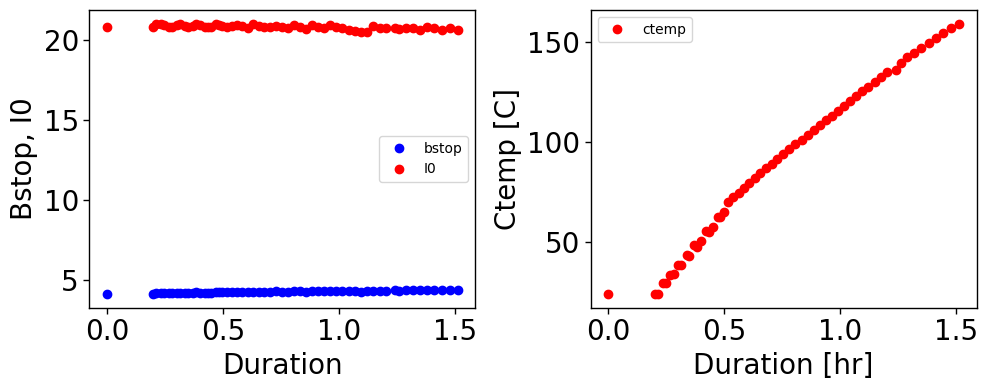

Processing WAXS data...
i0:20.81616, bstop: 4.10896, transmission factor: 0.19739279482863312, thickness: 0.01382294715732115, normfactor: 85.5327687936
i0:20.767226666666666, bstop: 4.1611400000000005, transmission factor: 0.20037051970348155, thickness: 0.013695392028074802, normfactor: 86.41533757173335
i0:21.005726666666668, bstop: 4.203413333333333, transmission factor: 0.20010797055660057, thickness: 0.013706562240946343, normfactor: 88.29575154702222
i0:20.951330000000002, bstop: 4.194793333333334, transmission factor: 0.2002160881115105, thickness: 0.013701960581170352, normfactor: 87.88649940846669


i0:20.900686666666665, bstop: 4.187196666666666, transmission factor: 0.20033775604820636, thickness: 0.013696785165655824, normfactor: 87.5152855417111
i0:20.809596666666668, bstop: 4.18037, transmission factor: 0.2008866422046623, thickness: 0.013673476082833372, normfactor: 86.99181361743334
i0:20.775199999999998, bstop: 4.17499, transmission factor: 0.20096027956409568, thickness: 0.013670353833822823, normfactor: 86.736252248
i0:20.937536666666663, bstop: 4.2221400000000004, transmission factor: 0.20165409461571496, thickness: 0.01364099188739103, normfactor: 88.4012110618
i0:20.958940000000002, bstop: 4.2115, transmission factor: 0.2009405055790035, thickness: 0.013671192145120565, normfactor: 88.26857581
i0:20.836413333333336, bstop: 4.206213333333333, transmission factor: 0.2018683957763684, thickness: 0.013631943174892172, normfactor: 87.64239958151113
i0:20.82045666666667, bstop: 4.202590000000001, transmission factor: 0.20184907887867334, thickness: 0.013632758423006673, nor

i0:20.961956666666666, bstop: 4.255883333333334, transmission factor: 0.20302891571667853, thickness: 0.013583107311057515, normfactor: 89.21164201172223
i0:20.910853333333336, bstop: 4.2468900000000005, transmission factor: 0.2030950115856901, thickness: 0.013580334337587874, normfactor: 88.80609391280002
i0:20.870703333333335, bstop: 4.244386666666666, transmission factor: 0.20336577061530106, thickness: 0.01356898437746842, normfactor: 88.58333495195555
i0:20.795393333333333, bstop: 4.241813333333333, transmission factor: 0.2039785093429346, thickness: 0.013543354648904975, normfactor: 88.21017671324444
i0:20.83084666666667, bstop: 4.253616666666667, transmission factor: 0.20419797307006562, thickness: 0.013534193608795063, normfactor: 88.60643656211113
i0:20.927456666666668, bstop: 4.27199, transmission factor: 0.20413326225180728, thickness: 0.013536893798415281, normfactor: 89.40188560543334
i0:20.854896666666665, bstop: 4.260233333333333, transmission factor: 0.20427976227485503

i0:20.797063333333334, bstop: 4.273476666666666, transmission factor: 0.20548462050491423, thickness: 0.013480682562210996, normfactor: 88.87576489018889
i0:20.860863333333334, bstop: 4.300106666666667, transmission factor: 0.20613272796795404, thickness: 0.013453854847363148, normfactor: 89.7039374920889
i0:20.805766666666667, bstop: 4.284916666666667, transmission factor: 0.20594851106984763, thickness: 0.013461471718749767, normfactor: 89.15097635277777
i0:20.698603333333335, bstop: 4.27601, transmission factor: 0.20658447003106972, thickness: 0.01343520530801662, normfactor: 88.50743483936668
i0:20.900656666666666, bstop: 4.310926666666667, transmission factor: 0.206257953298756, thickness: 0.013448681003374846, normfactor: 90.10119817517779
i0:20.786640000000002, bstop: 4.299526666666667, transmission factor: 0.20684086830130635, thickness: 0.013424638397563918, normfactor: 89.37271299040002
i0:20.675463333333337, bstop: 4.284823333333333, transmission factor: 0.207241949757192, t

i0:20.629423333333335, bstop: 4.308696666666666, transmission factor: 0.20886171159736727, thickness: 0.013341809227419371, normfactor: 88.88592755158889
i0:20.55781, bstop: 4.29896, transmission factor: 0.20911565969332338, thickness: 0.013331457276243422, normfactor: 88.3772028776
i0:20.483430000000002, bstop: 4.28034, transmission factor: 0.20896597884241064, thickness: 0.013337557350734741, normfactor: 87.67604476620001
i0:20.505570000000002, bstop: 4.296003333333334, transmission factor: 0.2095042143833765, thickness: 0.013315642523422384, normfactor: 88.09199707190002
i0:20.861353333333334, bstop: 4.3559833333333335, transmission factor: 0.20880636379295303, thickness: 0.013344067098234566, normfactor: 90.87170743077779
i0:20.74536, bstop: 4.3404533333333335, transmission factor: 0.2092252596885922, thickness: 0.013326993420309418, normfactor: 90.04426696320002
i0:20.72923, bstop: 4.347956666666667, transmission factor: 0.2097500325225137, thickness: 0.013305652500680686, normfac

i0:20.75709, bstop: 4.374739999999999, transmission factor: 0.2107588298745151, thickness: 0.013264777329492768, normfactor: 90.8068719066
i0:20.615956666666666, bstop: 4.360373333333333, transmission factor: 0.21150477777165166, thickness: 0.013234678107995949, normfactor: 89.89326769048888
i0:20.783126666666664, bstop: 4.399346666666666, transmission factor: 0.21167876889874446, thickness: 0.013227672782441226, normfactor: 91.43217902391109
i0:20.70889, bstop: 4.379270000000001, transmission factor: 0.21146811828156897, thickness: 0.013236154847364833, normfactor: 90.68982071030003
i0:20.57885333333333, bstop: 4.362753333333333, transmission factor: 0.2120017701018651, thickness: 0.013214683185387334, normfactor: 89.78046097617776
i0:20.70726, bstop: 4.402163333333333, transmission factor: 0.21259033466201385, thickness: 0.013191064678291002, normfactor: 91.1567407058
i0:20.60725, bstop: 4.38464, transmission factor: 0.21277171869123732, thickness: 0.013183799098133532, normfactor: 9

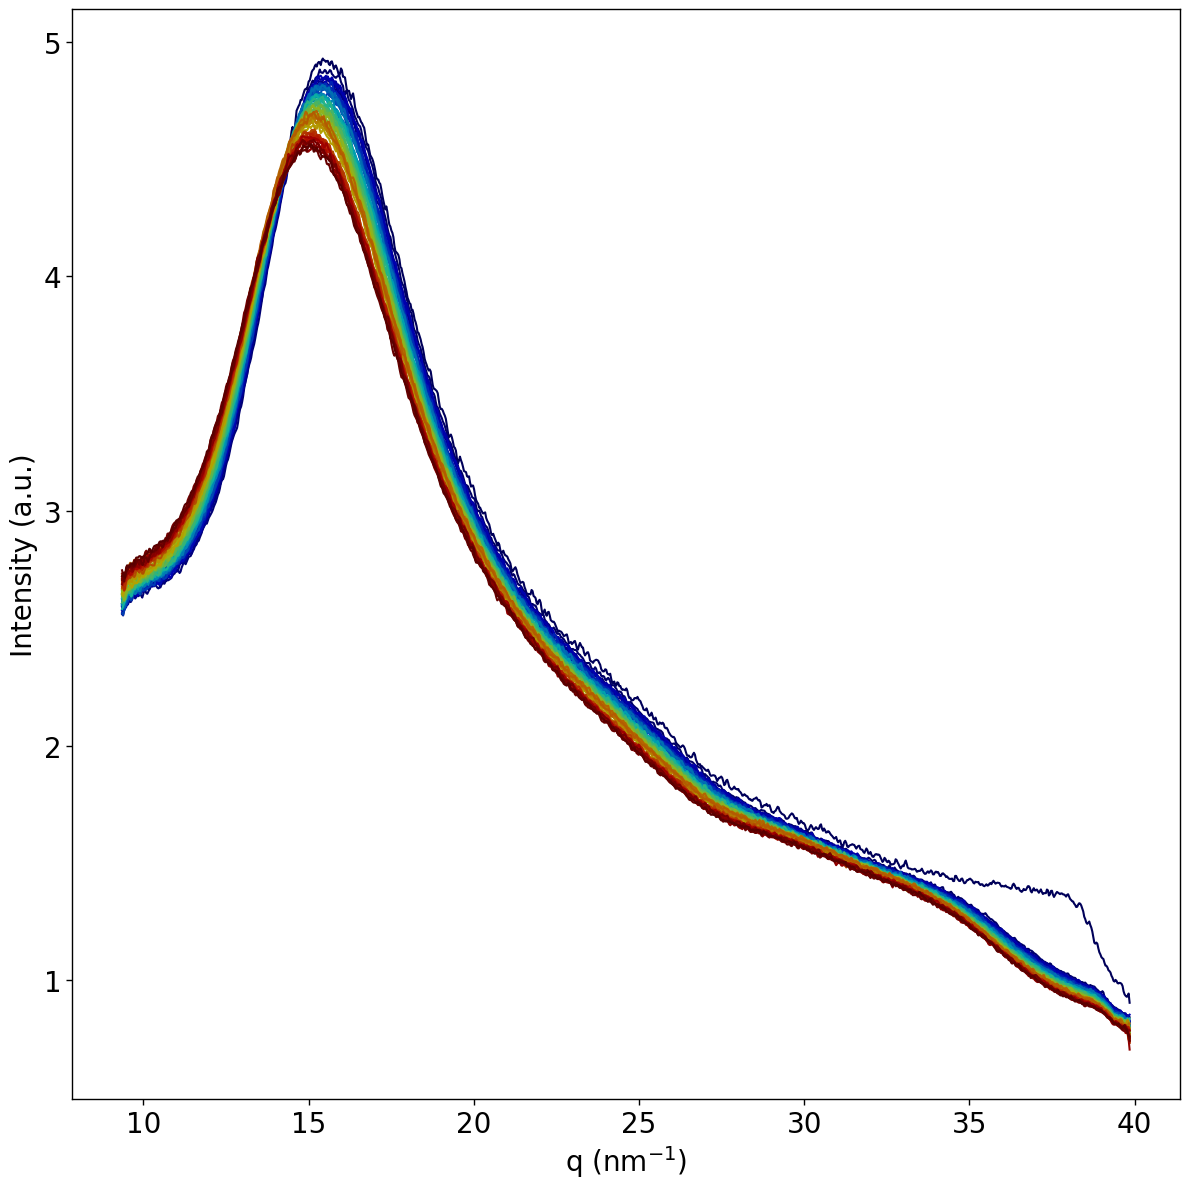

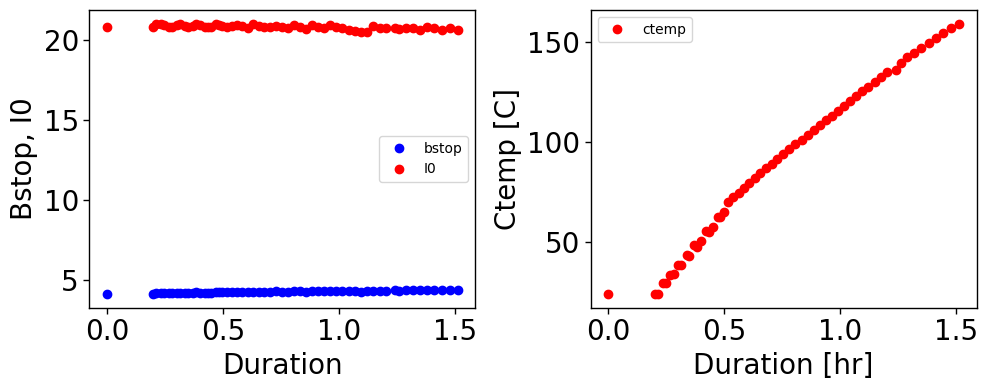

In [42]:
#raw_dir_meth = r'X:\bl1-5\Anjani\Autoxidation\Jan2025\RT\RTSoak'
# Run 23c
#common_keyword = ""  # folder name
#keyword = "*Empty*" # file name

#keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir_meth, common_keyword, keyword)

#process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai)
#process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w)


raw_dir = os.path.join(base_dir, '')

#raw_dir_meth = r'X:\bl1-5\Anjani\RedesignedPlastic\Jan2025\Fibers3'


common_keyword = ""  # folder name
keywords = [#"*Run1_*RampT*",
            "*Run2_*RampT*","*Run3*RampT*","*Run4*RampT*", '*Run5*RampT*','*Run6*RampT*','*Run7*RampT*','*Run8*RampT*','*Run9*RampT*','*Run10*RampT*','*Run11*RampT*','*Run12*RampT*','*Run13*RampT*',"*Run14*RampT*" ]# file name
# loop over the keywords
for keyword in keywords:
     keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir, common_keyword, keyword)
     
     process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai, saxs_mask, i0_offset=0, bstop_offset=0, i0_air=0, bstop_air=0)
     process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w, mask=None, i0_offset=0, bstop_offset=0, i0_air=0, bstop_air=0)


In [43]:
print(SAXS_folder_name)
sorted(os.listdir(SAXS_folder_name))

/Users/akmaurya/OneDrive - Stanford/Data_01/Autoxidation/Autoxidation/Jan2025/atT/OneD_integrated_SAXS_01/Reduction/


['.DS_Store',
 'Figure_saxs_waxs_Reduced',
 'Hor_all_SAXS.dat',
 'Run10_AcOH_RampT100_ctr32_all_SAXS.dat',
 'Run10_AcOH_RampT102_ctr33_all_SAXS.dat',
 'Run10_AcOH_RampT105_ctr34_all_SAXS.dat',
 'Run10_AcOH_RampT107_ctr35_all_SAXS.dat',
 'Run10_AcOH_RampT110_ctr36_all_SAXS.dat',
 'Run10_AcOH_RampT112_ctr37_all_SAXS.dat',
 'Run10_AcOH_RampT115_ctr38_all_SAXS.dat',
 'Run10_AcOH_RampT117_ctr39_all_SAXS.dat',
 'Run10_AcOH_RampT120_ctr40_all_SAXS.dat',
 'Run10_AcOH_RampT122_ctr41_all_SAXS.dat',
 'Run10_AcOH_RampT125_ctr42_all_SAXS.dat',
 'Run10_AcOH_RampT127_ctr43_all_SAXS.dat',
 'Run10_AcOH_RampT130_ctr44_all_SAXS.dat',
 'Run10_AcOH_RampT132_ctr45_all_SAXS.dat',
 'Run10_AcOH_RampT135_ctr46_all_SAXS.dat',
 'Run10_AcOH_RampT137_ctr47_all_SAXS.dat',
 'Run10_AcOH_RampT140_ctr48_all_SAXS.dat',
 'Run10_AcOH_RampT142_ctr49_all_SAXS.dat',
 'Run10_AcOH_RampT145_ctr50_all_SAXS.dat',
 'Run10_AcOH_RampT147_ctr51_all_SAXS.dat',
 'Run10_AcOH_RampT150_ctr52_all_SAXS.dat',
 'Run10_AcOH_RampT152_ctr53_all_S

# Plotting T

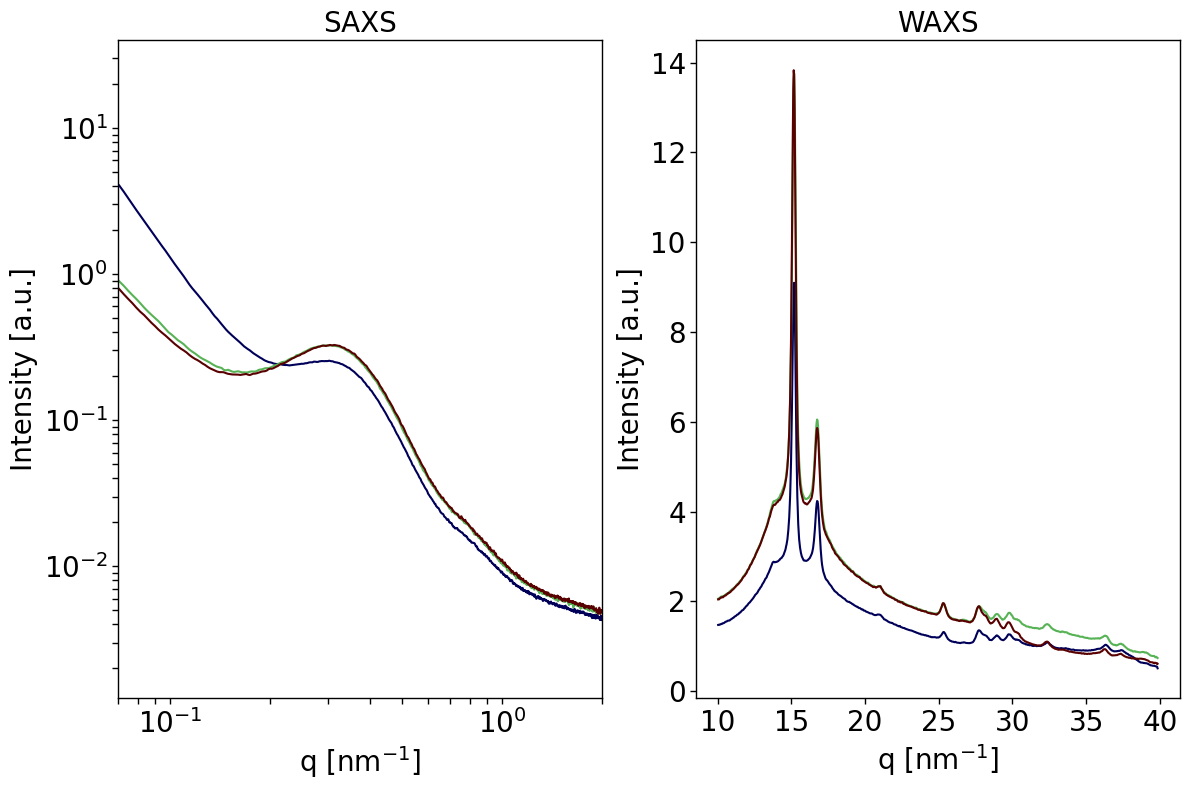

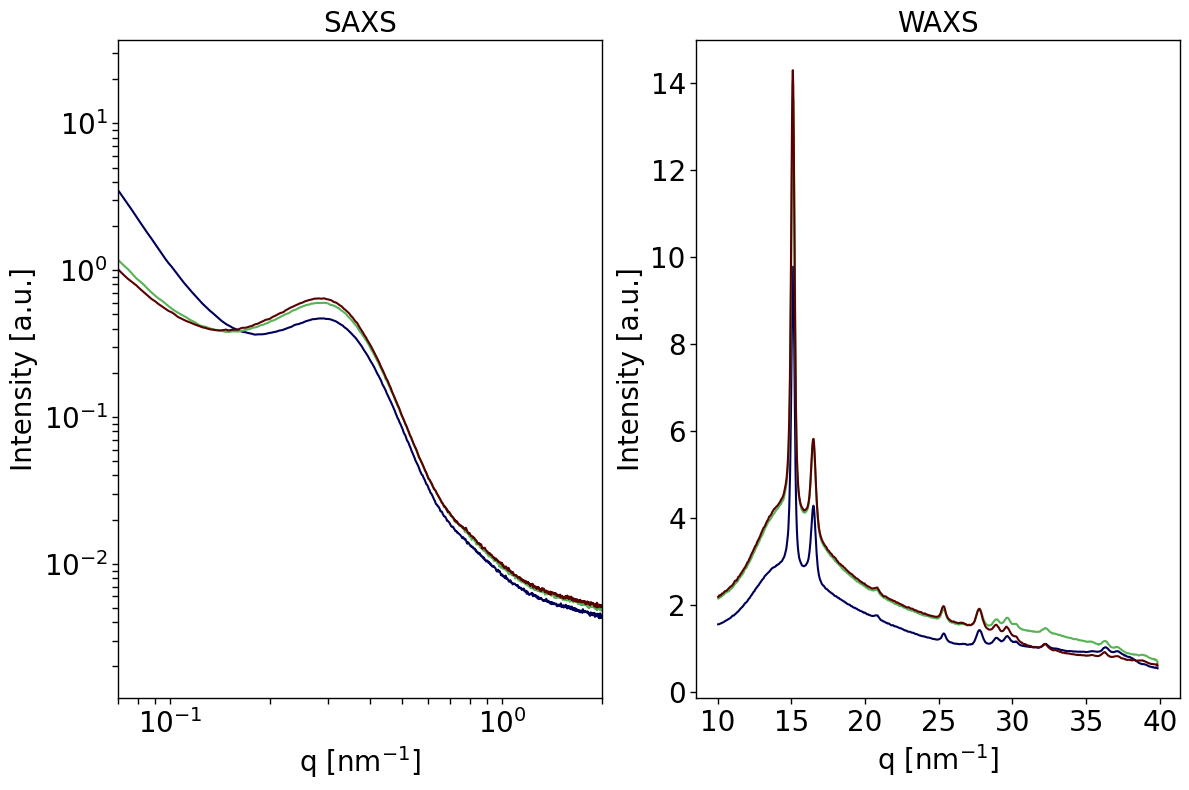

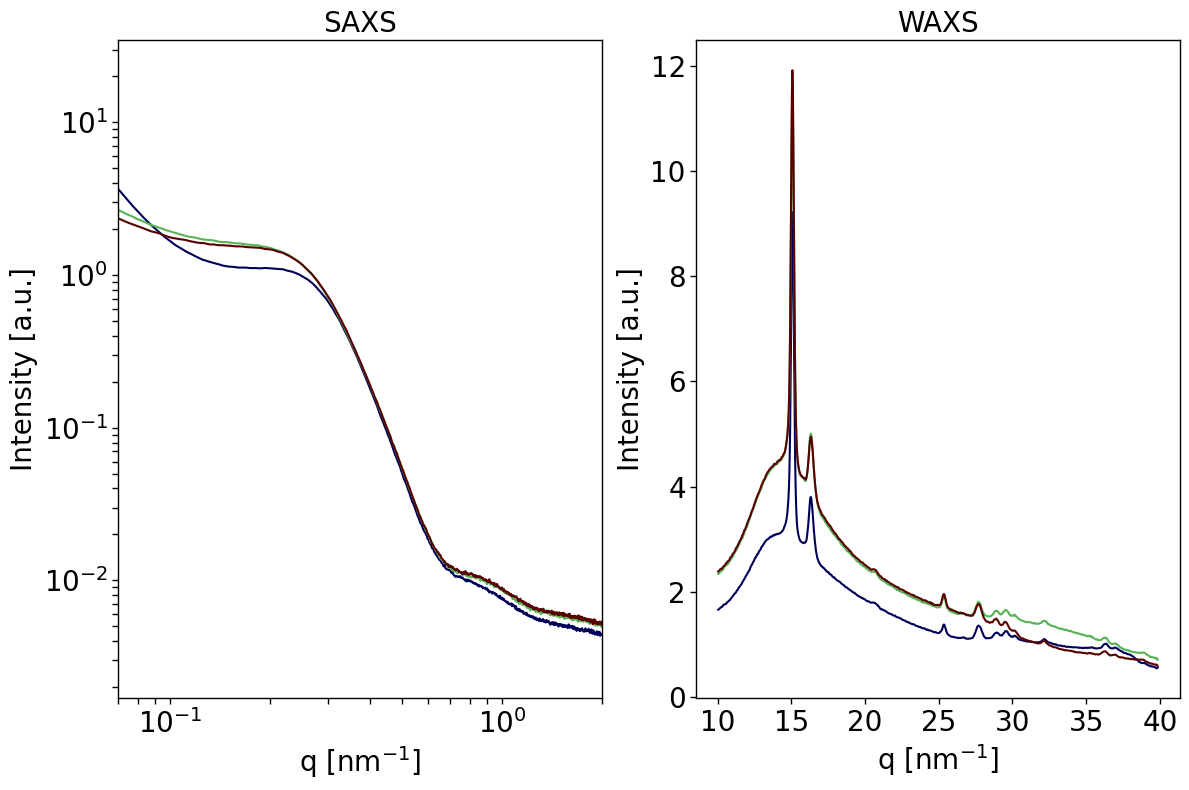

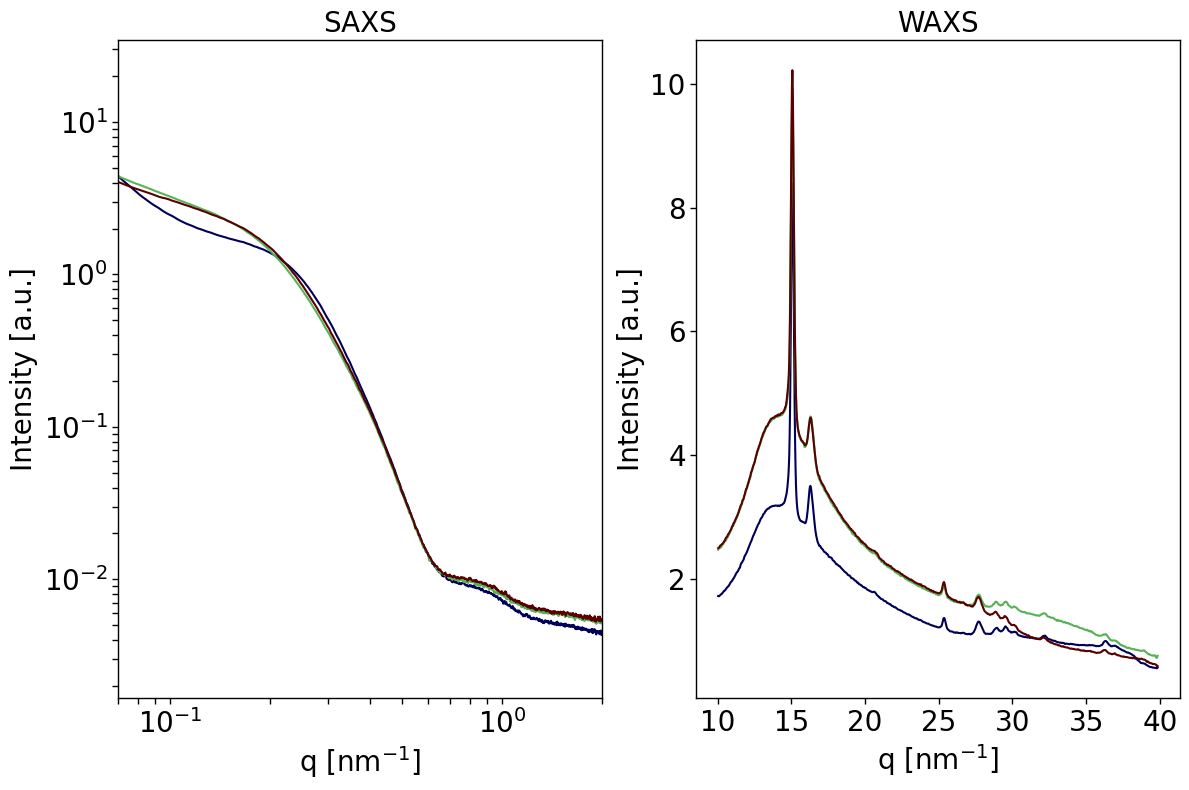

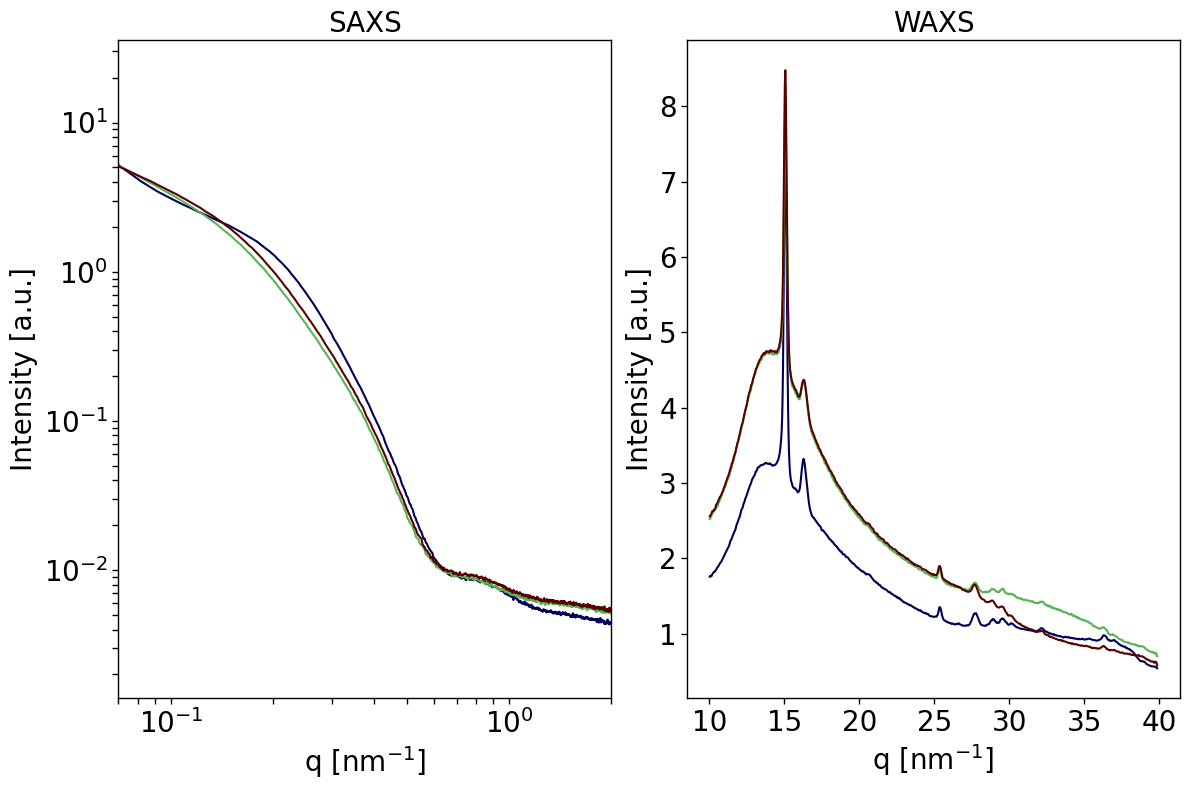

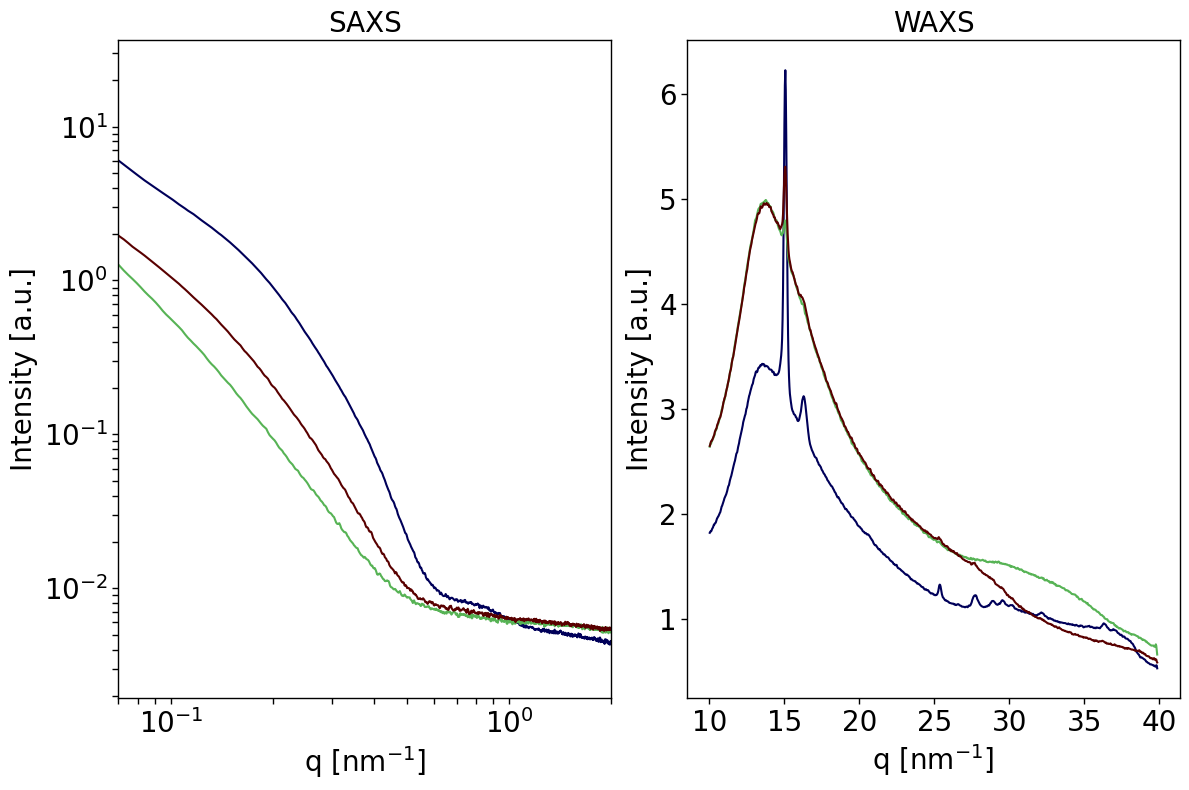

In [44]:
# Run 5

#Run7_PEAcOH2_poly_Solv_10s_03_T25_x19_dy1_ctr0_all_SAXS_Norm_sub_fitted.dat
#Run7_PEAcOH3_poly_Solv_10s_03_T25_x14_dy1_ctr0_all_SAXS_Norm_sub_fitted.dat

all_keywords = [
     ["Run7*RampT50_*", "Run6*RampT50*", "Run8*RampT50*"],
     ["Run7*RampT*_ctr30*",'Run6*RampT*ctr30*','Run8*RampT*ctr30*'],
     ['Run7*RampT*_ctr40*','Run6*RampT*ctr40*','Run8*RampT*ctr40*'],
     ['Run7*RampT*_ctr42*','Run6*RampT*ctr42*','Run8*RampT*ctr42*'],
     ['Run7*RampT*_ctr43*','Run6*RampT*ctr43*','Run8*RampT*ctr43*'],
     ['Run7*RampT*_ctr44*','Run6*RampT*ctr44*','Run8*RampT*ctr44*'],
     #["Run6*RampT30_*"],['Run7*RampT*'], ['Run8*RampT*'],



]

plot_saxs_waxs_data(all_keywords, Run_number="")

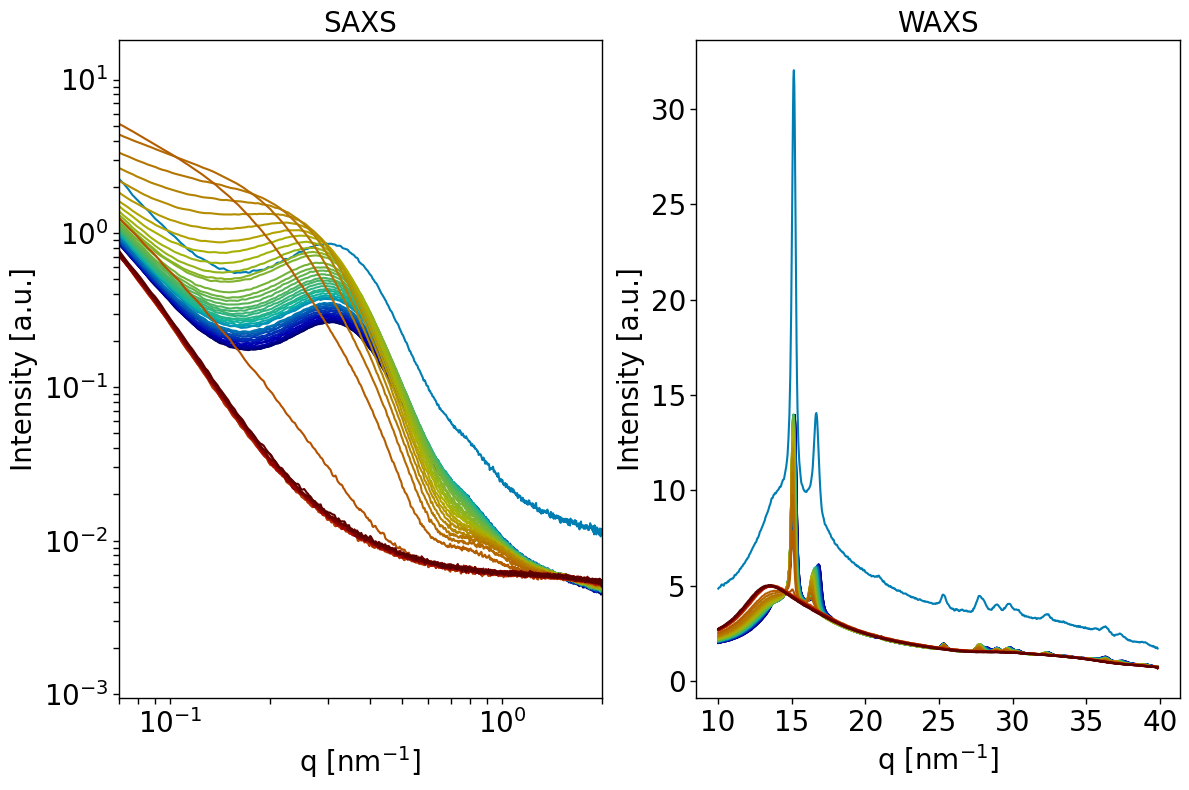

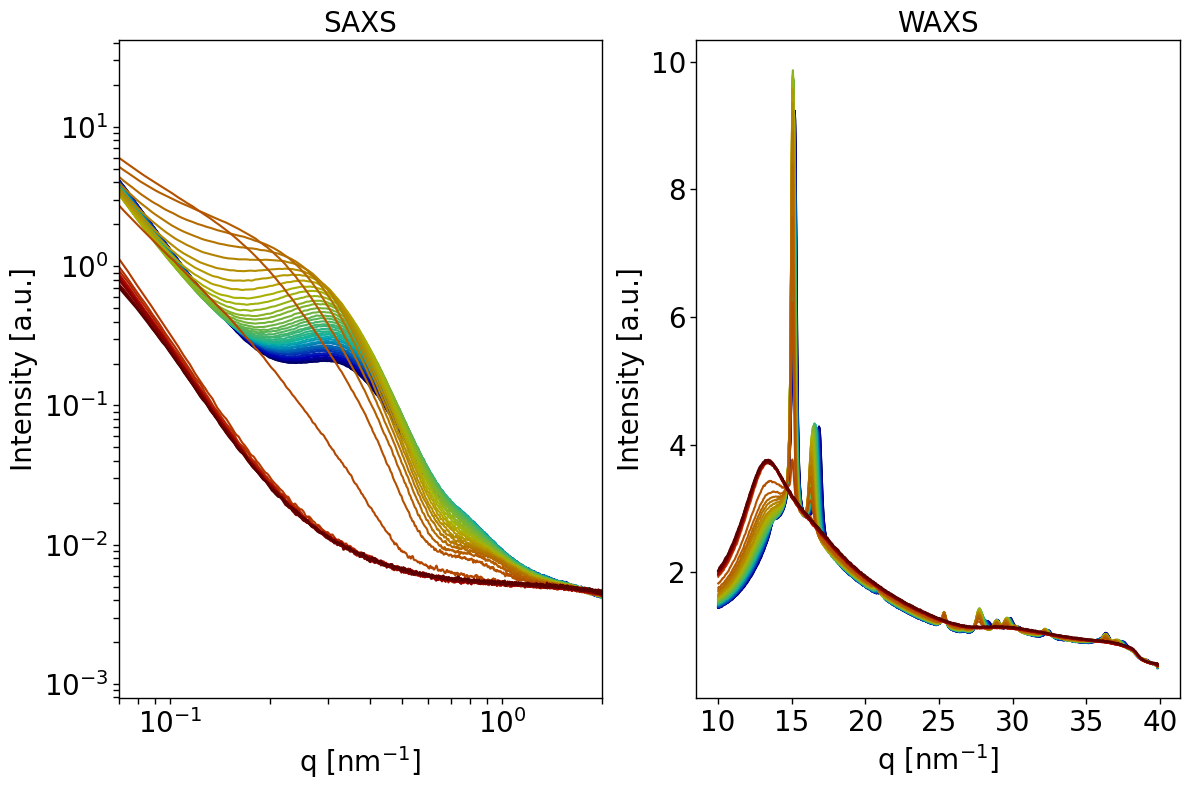

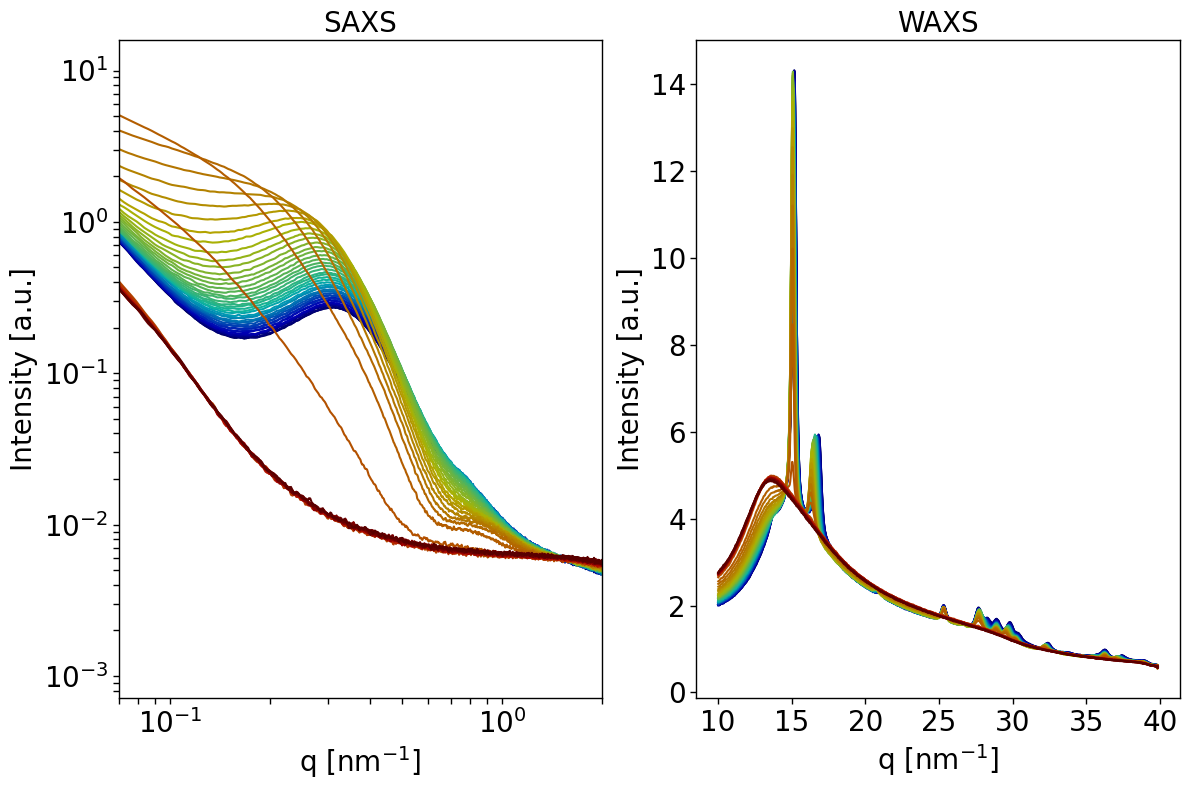

In [45]:
# Run 5



all_keywords = [
     #['Run']
     ["Run6*RampT*"],['Run7*RampT*'], ['Run8*RampT*'],# ['Run9*RampT*'], 
     #['Run10*RampT*'], ['Run11*RampT*'], ['Run12*RampT*'], ['Run13*RampT*'], ['Run14*RampT*']

]

plot_saxs_waxs_data(all_keywords, Run_number="")


